In [1506]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# data partition
from sklearn.model_selection import train_test_split

# Imputing
from sklearn.impute import KNNImputer

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler


# embedded methods
from sklearn.linear_model import LassoCV

# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Modelling and report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

# Exploration

In [1507]:
data_train_val = pd.read_csv('train.csv')

In [1508]:
data_test = pd.read_csv('test.csv')

In [1509]:
# data_train_val.set_index('encounter_id', inplace = True)
# data_test.set_index('encounter_id', inplace = True)

In [1510]:
# replace ? with nan
data_train_val.replace('?', np.nan, inplace = True)
data_test.replace('?', np.nan, inplace = True)

In [1511]:
# train and validation set
data_train, data_val = train_test_split(data_train_val, test_size = 0.2, random_state = 42)

In [1512]:
# Checking for missing values and their proportions in the dataset
def missing_values(data):
    missing = pd.DataFrame(data.isnull().sum())
    missing.columns = ['count']
    missing['percentage'] = (missing['count']/len(data))*100
    missing.sort_values(by = 'percentage', ascending = False, inplace = True)
    return missing

In [1513]:
# print missing values for each dataset
print('Missing values in train set')
print(missing_values(data_train))
print('Missing values in validation set')
print(missing_values(data_val))
print('Missing values in test set')
print(missing_values(data_test))

Missing values in train set
                                       count  percentage
weight                                 55165   96.801081
glucose_test_result                    54066   94.872605
a1c_test_result                        47492   83.336843
medical_specialty                      27985   49.106830
payer_code                             22529   39.532884
race                                    4029    7.069909
admission_source                        3769    6.613673
admission_type                          2966    5.204604
age                                     2827    4.960693
discharge_disposition                   2078    3.646382
additional_diagnosis                     813    1.426616
secondary_diagnosis                      210    0.368499
primary_diagnosis                         14    0.024567
number_of_medications                      0    0.000000
prescribed_diabetes_meds                   0    0.000000
number_diagnoses                           0    0.000000
med

In [1514]:
# replace readmitted binary and multiclass with numerical values
data_train['readmitted_binary'] = data_train['readmitted_binary'].replace({'Yes':1, 'No':0})
data_val['readmitted_binary'] = data_val['readmitted_binary'].replace({'Yes':1, 'No':0})

data_train['readmitted_multiclass'] = data_train['readmitted_multiclass'].replace({'No': 0, '<30 days': 1, '>30 days': 2})
data_val['readmitted_multiclass'] = data_val['readmitted_multiclass'].replace({'No': 0, '<30 days': 1, '>30 days': 2})


# PreProcessing

## Functions

In [1515]:
# def plot_categorical_distribution(df, col):
#     """
#     Plots the percentage and distribution of a categorical variable against 
#     both 'readmitted_binary' and 'readmitted_multiclass'.

#     Parameters:
#     df (DataFrame): The dataframe containing the data.
#     col (str): The name of the categorical column to plot.
#     """
#     target_cols = ['readmitted_binary', 'readmitted_multiclass']
#     fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
#     fig.suptitle(f'Distribution and Percentage of {col} for Readmission Types', fontsize=16)

#     for i, target_col in enumerate(target_cols):
#         # Plotting the percentage distribution
#         ax = axes[0, i]
#         (df.groupby([col, target_col]).size().groupby(level=0)
#          .apply(lambda x: 100 * x / x.sum()).unstack()
#          .plot(kind='bar', stacked=True, ax=ax))
#         ax.set_title(f'Percentage of {target_col} for {col}')
#         ax.set_ylabel('Percentage')
#         ax.set_xlabel(col)

#         # Plotting the count distribution
#         ax = axes[1, i]
#         (df.groupby([col, target_col]).size().unstack()
#          .plot(kind='bar', stacked=True, ax=ax))
#         ax.set_title(f'Distribution of {target_col} for {col}')
#         ax.set_ylabel('Count')
#         ax.set_xlabel(col)

#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()


def plot_categorical_distribution(df, col):
    """
    Plots the percentage and distribution of a categorical variable against 
    both 'readmitted_binary' and 'readmitted_multiclass', with increased figure size for better visibility.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    col (str): The name of the categorical column to plot.
    """
    target_cols = ['readmitted_binary', 'readmitted_multiclass']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 16))  # Increased figure size for better visibility

    fig.suptitle(f'Distribution and Percentage of {col} for Readmission Types', fontsize=16)

    for i, target_col in enumerate(target_cols):
        # Plotting the percentage distribution
        ax = axes[0, i]
        (df.groupby([col, target_col]).size().groupby(level=0)
         .apply(lambda x: 100 * x / x.sum()).unstack()
         .plot(kind='bar', stacked=True, ax=ax))
        ax.set_title(f'Percentage of {target_col} for {col}')
        ax.set_ylabel('Percentage')
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)  # Hides x-axis labels for the upper plots

        # Plotting the count distribution
        ax = axes[1, i]
        (df.groupby([col, target_col]).size().unstack()
         .plot(kind='bar', stacked=True, ax=ax))
        ax.set_title(f'Distribution of {target_col} for {col}')
        ax.set_ylabel('Count')
        ax.set_xlabel(col)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [1516]:
def plot_continuous_distribution(df, feature_name):
    """
    Plots the distribution and boxplot of a continuous feature with respect to both 
    'readmitted_binary' and 'readmitted_multiclass' target variables using a vibrant color palette.

    Parameters:
    df (DataFrame): The pandas DataFrame containing the data.
    feature_name (str): The name of the continuous feature.
    """
    target_cols = ['readmitted_binary', 'readmitted_multiclass']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex='col', sharey='row')
    fig.suptitle(f'Distribution and Boxplot of {feature_name} for Readmission Types', fontsize=16)

    # Vibrant color palette
    palette = sns.color_palette("bright")

    for i, target_col in enumerate(target_cols):
        # Create a KDE plot in the first row
        sns.kdeplot(data=df, x=feature_name, hue=target_col, fill=True, palette=palette, ax=axes[0, i])
        axes[0, i].set_title(f'Distribution of {feature_name} by {target_col}')
        axes[0, i].set_xlabel(feature_name)
        axes[0, i].set_ylabel('Density')

        # Create a boxplot in the second row
        sns.boxplot(data=df, x=target_col, y=feature_name, palette=palette, ax=axes[1, i])
        axes[1, i].set_title(f'Boxplot of {feature_name} by {target_col}')
        axes[1, i].set_xlabel(target_col)
        axes[1, i].set_ylabel(feature_name)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [1517]:
def cap_outliers(df, feature, percentile_cap):
    cap_value = df[feature].quantile(percentile_cap)
    df[feature] = df[feature].clip(upper=cap_value)
    return cap_value

## Columns

#### patient_id

In [1518]:
# Calculate the number of previous admissions in the training set
train_admission_counts = data_train.groupby('patient_id').apply(lambda x: x.index.size)
train_previous_admissions = train_admission_counts - 1
train_previous_admissions_df = train_previous_admissions.reset_index()
train_previous_admissions_df.columns = ['patient_id', 'train_previous_admissions']

# Merge this information with the training set
data_train = data_train.merge(train_previous_admissions_df, on='patient_id', how='left')

# Calculate additional admissions in data_val and data_test
additional_admissions_val = data_val.groupby('patient_id').apply(lambda x: x.index.size)
additional_admissions_test = data_test.groupby('patient_id').apply(lambda x: x.index.size)

# Convert additional admissions to DataFrame
additional_admissions_val_df = additional_admissions_val.reset_index()
additional_admissions_test_df = additional_admissions_test.reset_index()
additional_admissions_val_df.columns = ['patient_id', 'val_additional_admissions']
additional_admissions_test_df.columns = ['patient_id', 'test_additional_admissions']

# Merge with the counts from data_train
additional_admissions_val_df = additional_admissions_val_df.merge(train_previous_admissions_df, on='patient_id', how='left')
additional_admissions_test_df = additional_admissions_test_df.merge(train_previous_admissions_df, on='patient_id', how='left')

# Calculate total previous admissions for data_val and data_test
additional_admissions_val_df['previous_admissions'] = additional_admissions_val_df['val_additional_admissions'] + additional_admissions_val_df['train_previous_admissions'].fillna(0) - 1
additional_admissions_test_df['previous_admissions'] = additional_admissions_test_df['test_additional_admissions'] + additional_admissions_test_df['train_previous_admissions'].fillna(0) - 1

# Merge with data_val and data_test
data_val = data_val.merge(additional_admissions_val_df[['patient_id', 'previous_admissions']], on='patient_id', how='left')
data_test = data_test.merge(additional_admissions_test_df[['patient_id', 'previous_admissions']], on='patient_id', how='left')

# Handle missing and negative values
data_train['previous_admissions'] = data_train['train_previous_admissions'].fillna(0).clip(lower=0)
data_val['previous_admissions'] = data_val['previous_admissions'].fillna(0).clip(lower=0)
data_test['previous_admissions'] = data_test['previous_admissions'].fillna(0).clip(lower=0)

# drop train_previous_admissions
data_train.drop('train_previous_admissions', axis = 1, inplace = True)



In [1519]:
# drop patient_id
data_train.drop('patient_id', axis = 1, inplace = True)
data_val.drop('patient_id', axis = 1, inplace = True)
data_test.drop('patient_id', axis = 1, inplace = True)

In [1520]:
# we will now set the index to encounter_id
data_train.set_index('encounter_id', inplace = True)
data_val.set_index('encounter_id', inplace = True)
data_test.set_index('encounter_id', inplace = True)

#### country

In [1521]:
# delete country column since there is only one country
data_train.drop(['country'], axis=1, inplace=True)
data_val.drop(['country'], axis=1, inplace=True)
data_test.drop(['country'], axis=1, inplace=True)

#### race

In [1522]:
# Replace missing values in 'race' column with 'Unknown' since 7% missing values might be too high for imputation and want to avoid biasing the model
data_train['race'] = data_train['race'].fillna('Unknown')
data_val['race'] = data_val['race'].fillna('Unknown')
data_test['race'] = data_test['race'].fillna('Unknown')

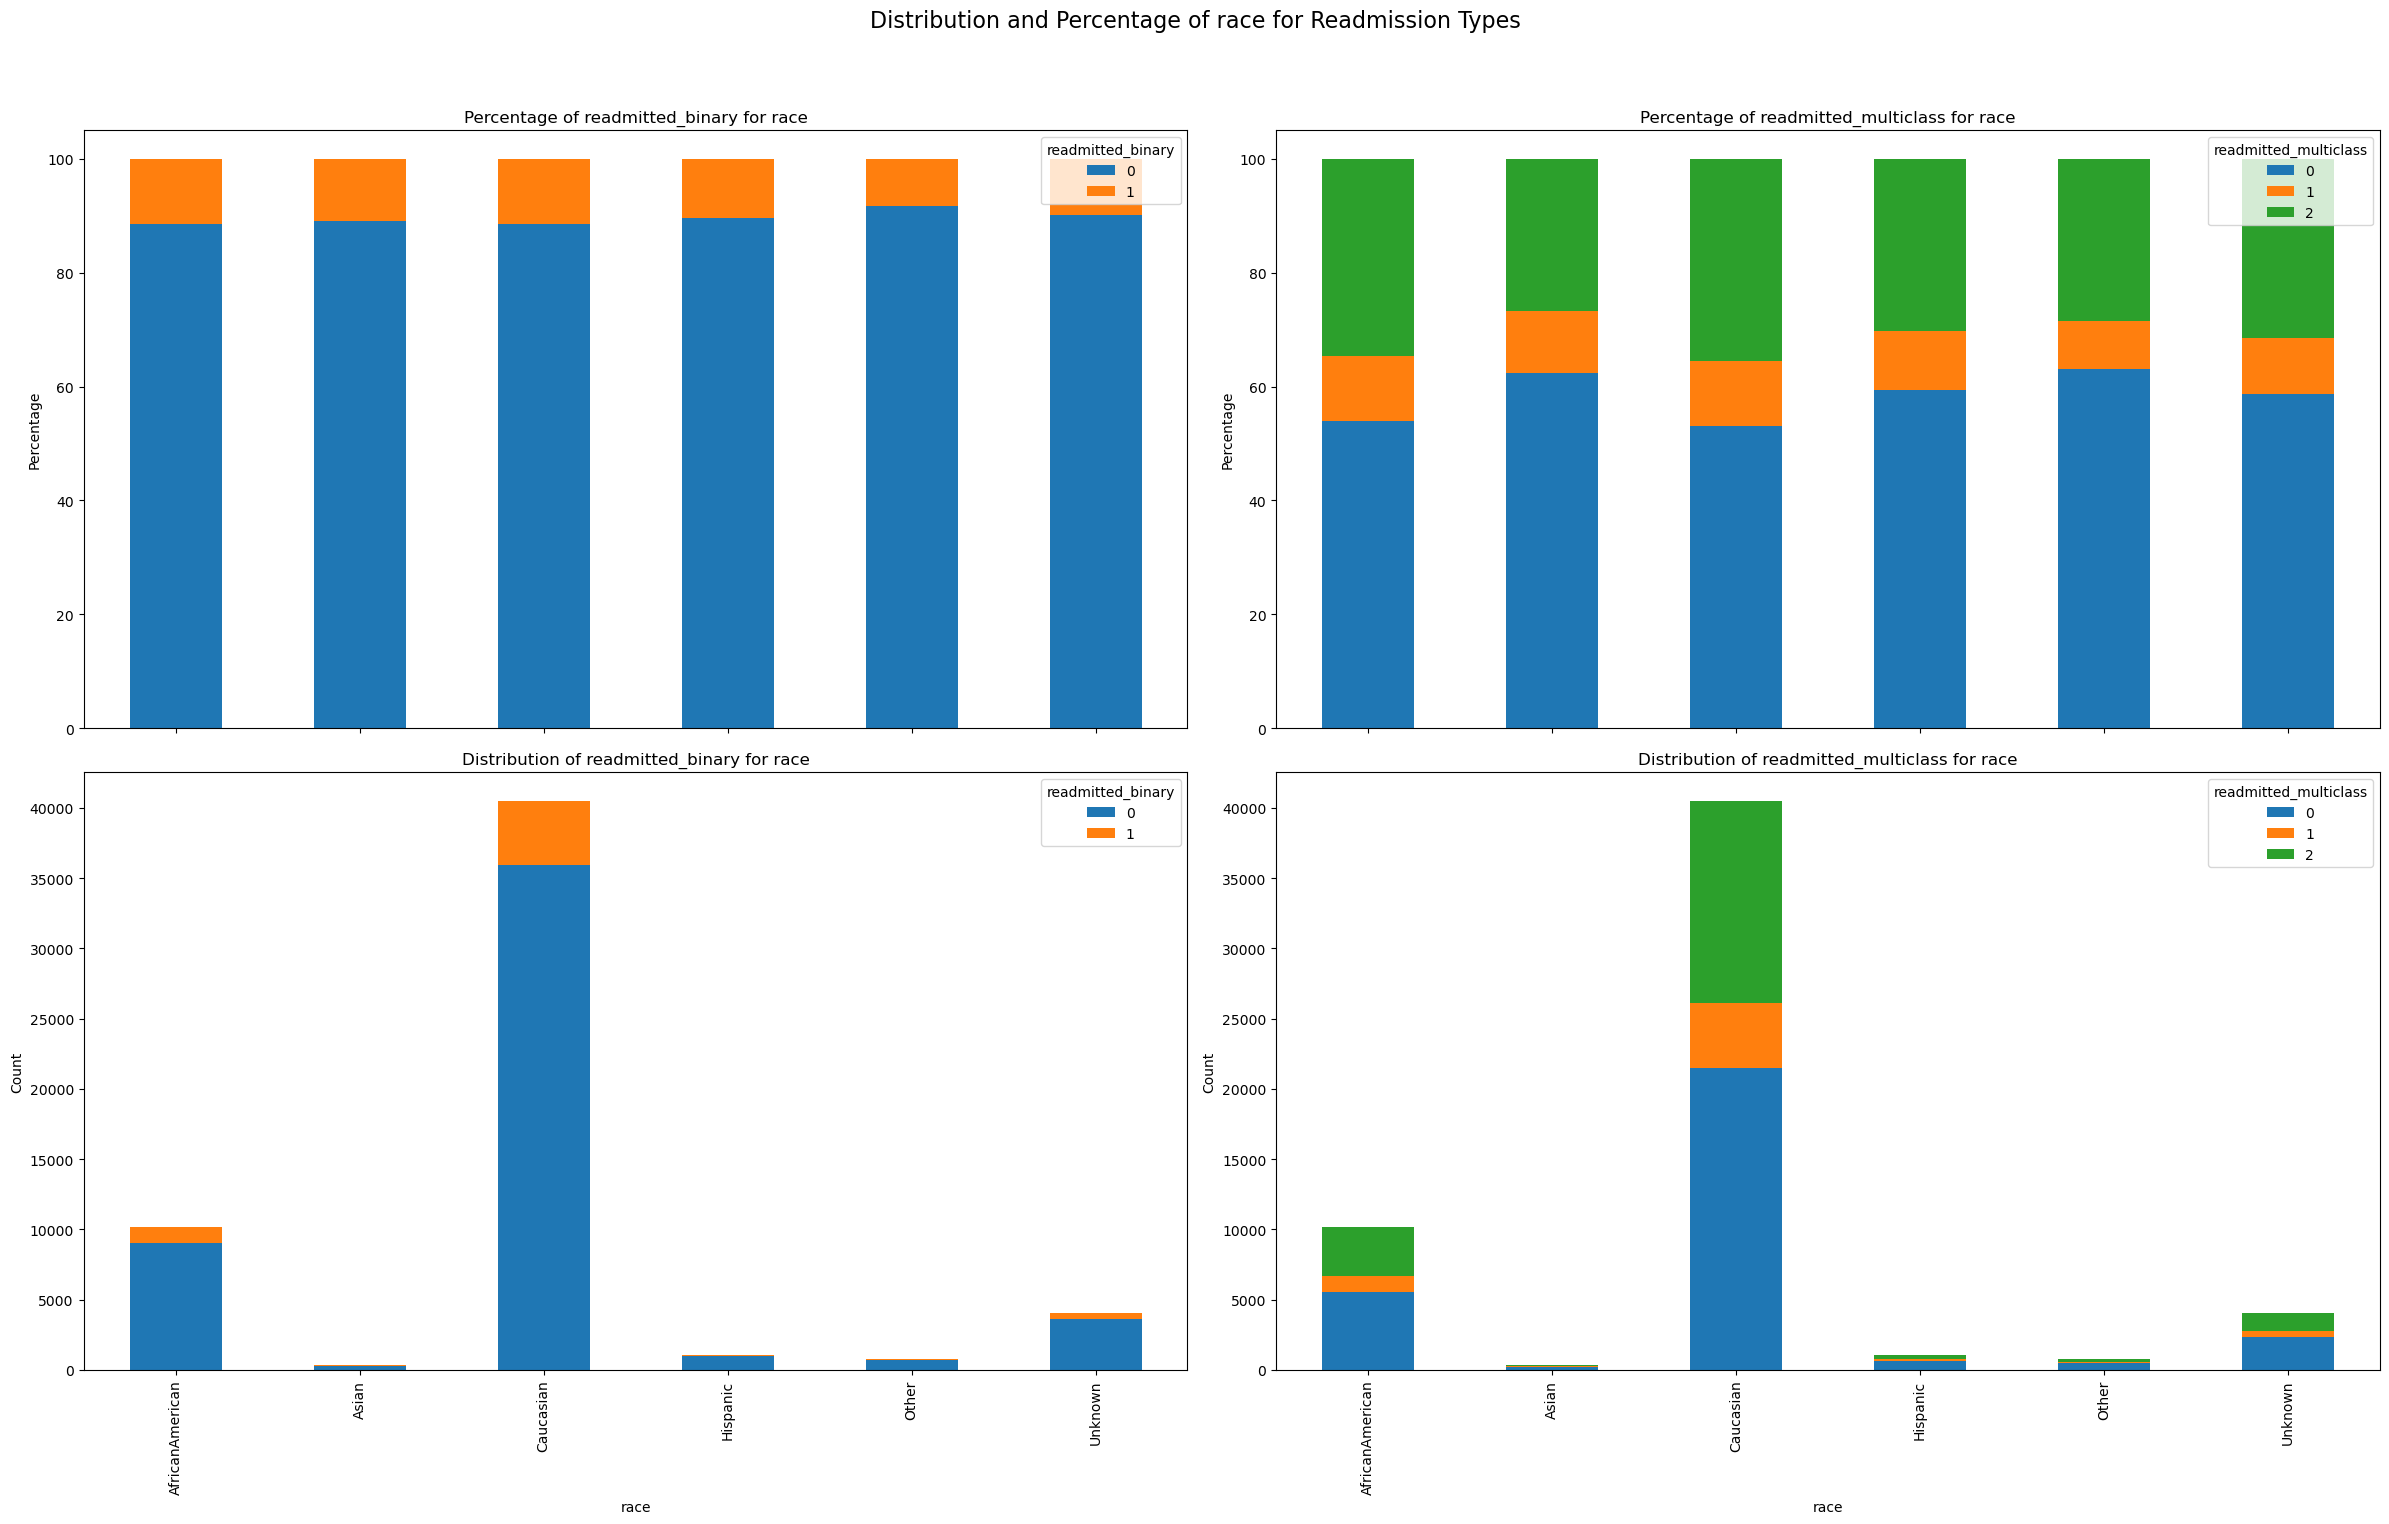

In [1523]:
plot_categorical_distribution(data_train, 'race')

#### gender

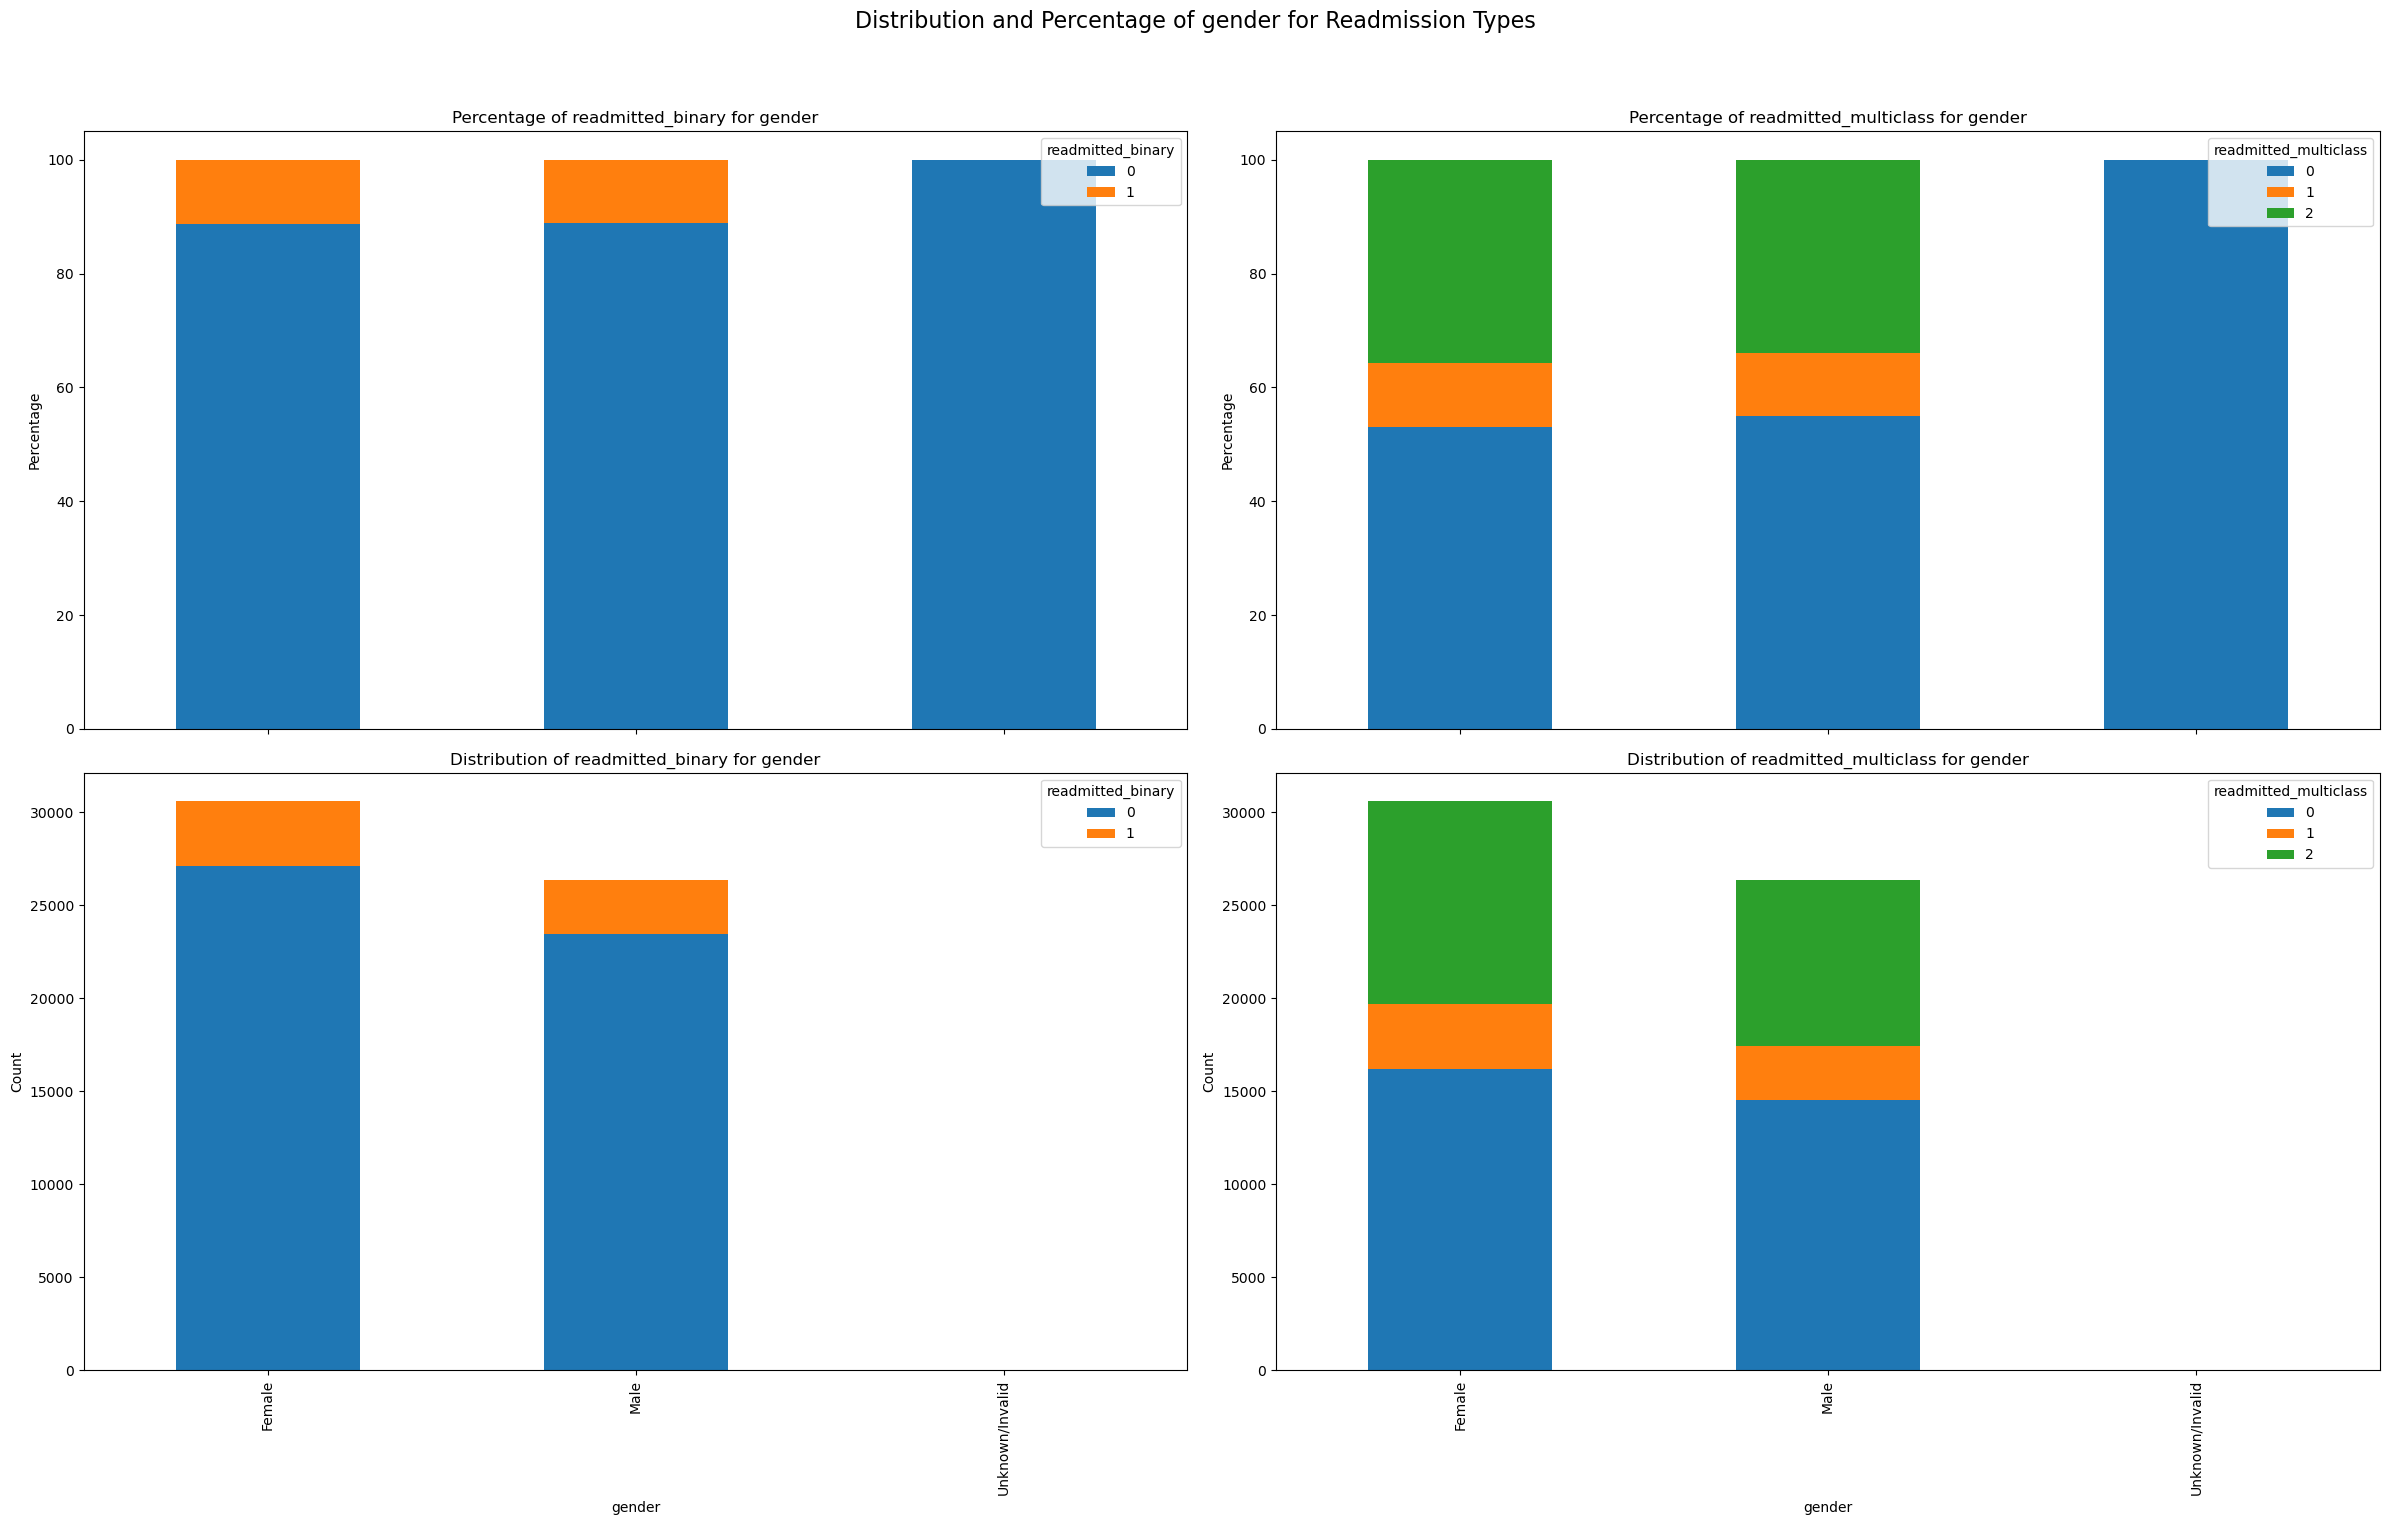

In [1524]:
plot_categorical_distribution(data_train, 'gender')

In [1525]:
# replace the few 'Unknown/Invalid' values with the mode in data_train
mode_gender_train = data_train['gender'].mode()[0]
data_train['gender'] = data_train['gender'].replace('Unknown/Invalid', mode_gender_train)

# Replace 'Unknown/Invalid' with the mode in data_val and data_test
data_val['gender'] = data_val['gender'].replace('Unknown/Invalid', mode_gender_train)
data_test['gender'] = data_test['gender'].replace('Unknown/Invalid', mode_gender_train)

In [1526]:
# make gender column numeric
data_train['gender'] = data_train['gender'].map({'Male': 1, 'Female': 0})
data_val['gender'] = data_val['gender'].map({'Male': 1, 'Female': 0})
data_test['gender'] = data_test['gender'].map({'Male': 1, 'Female': 0})

#### age

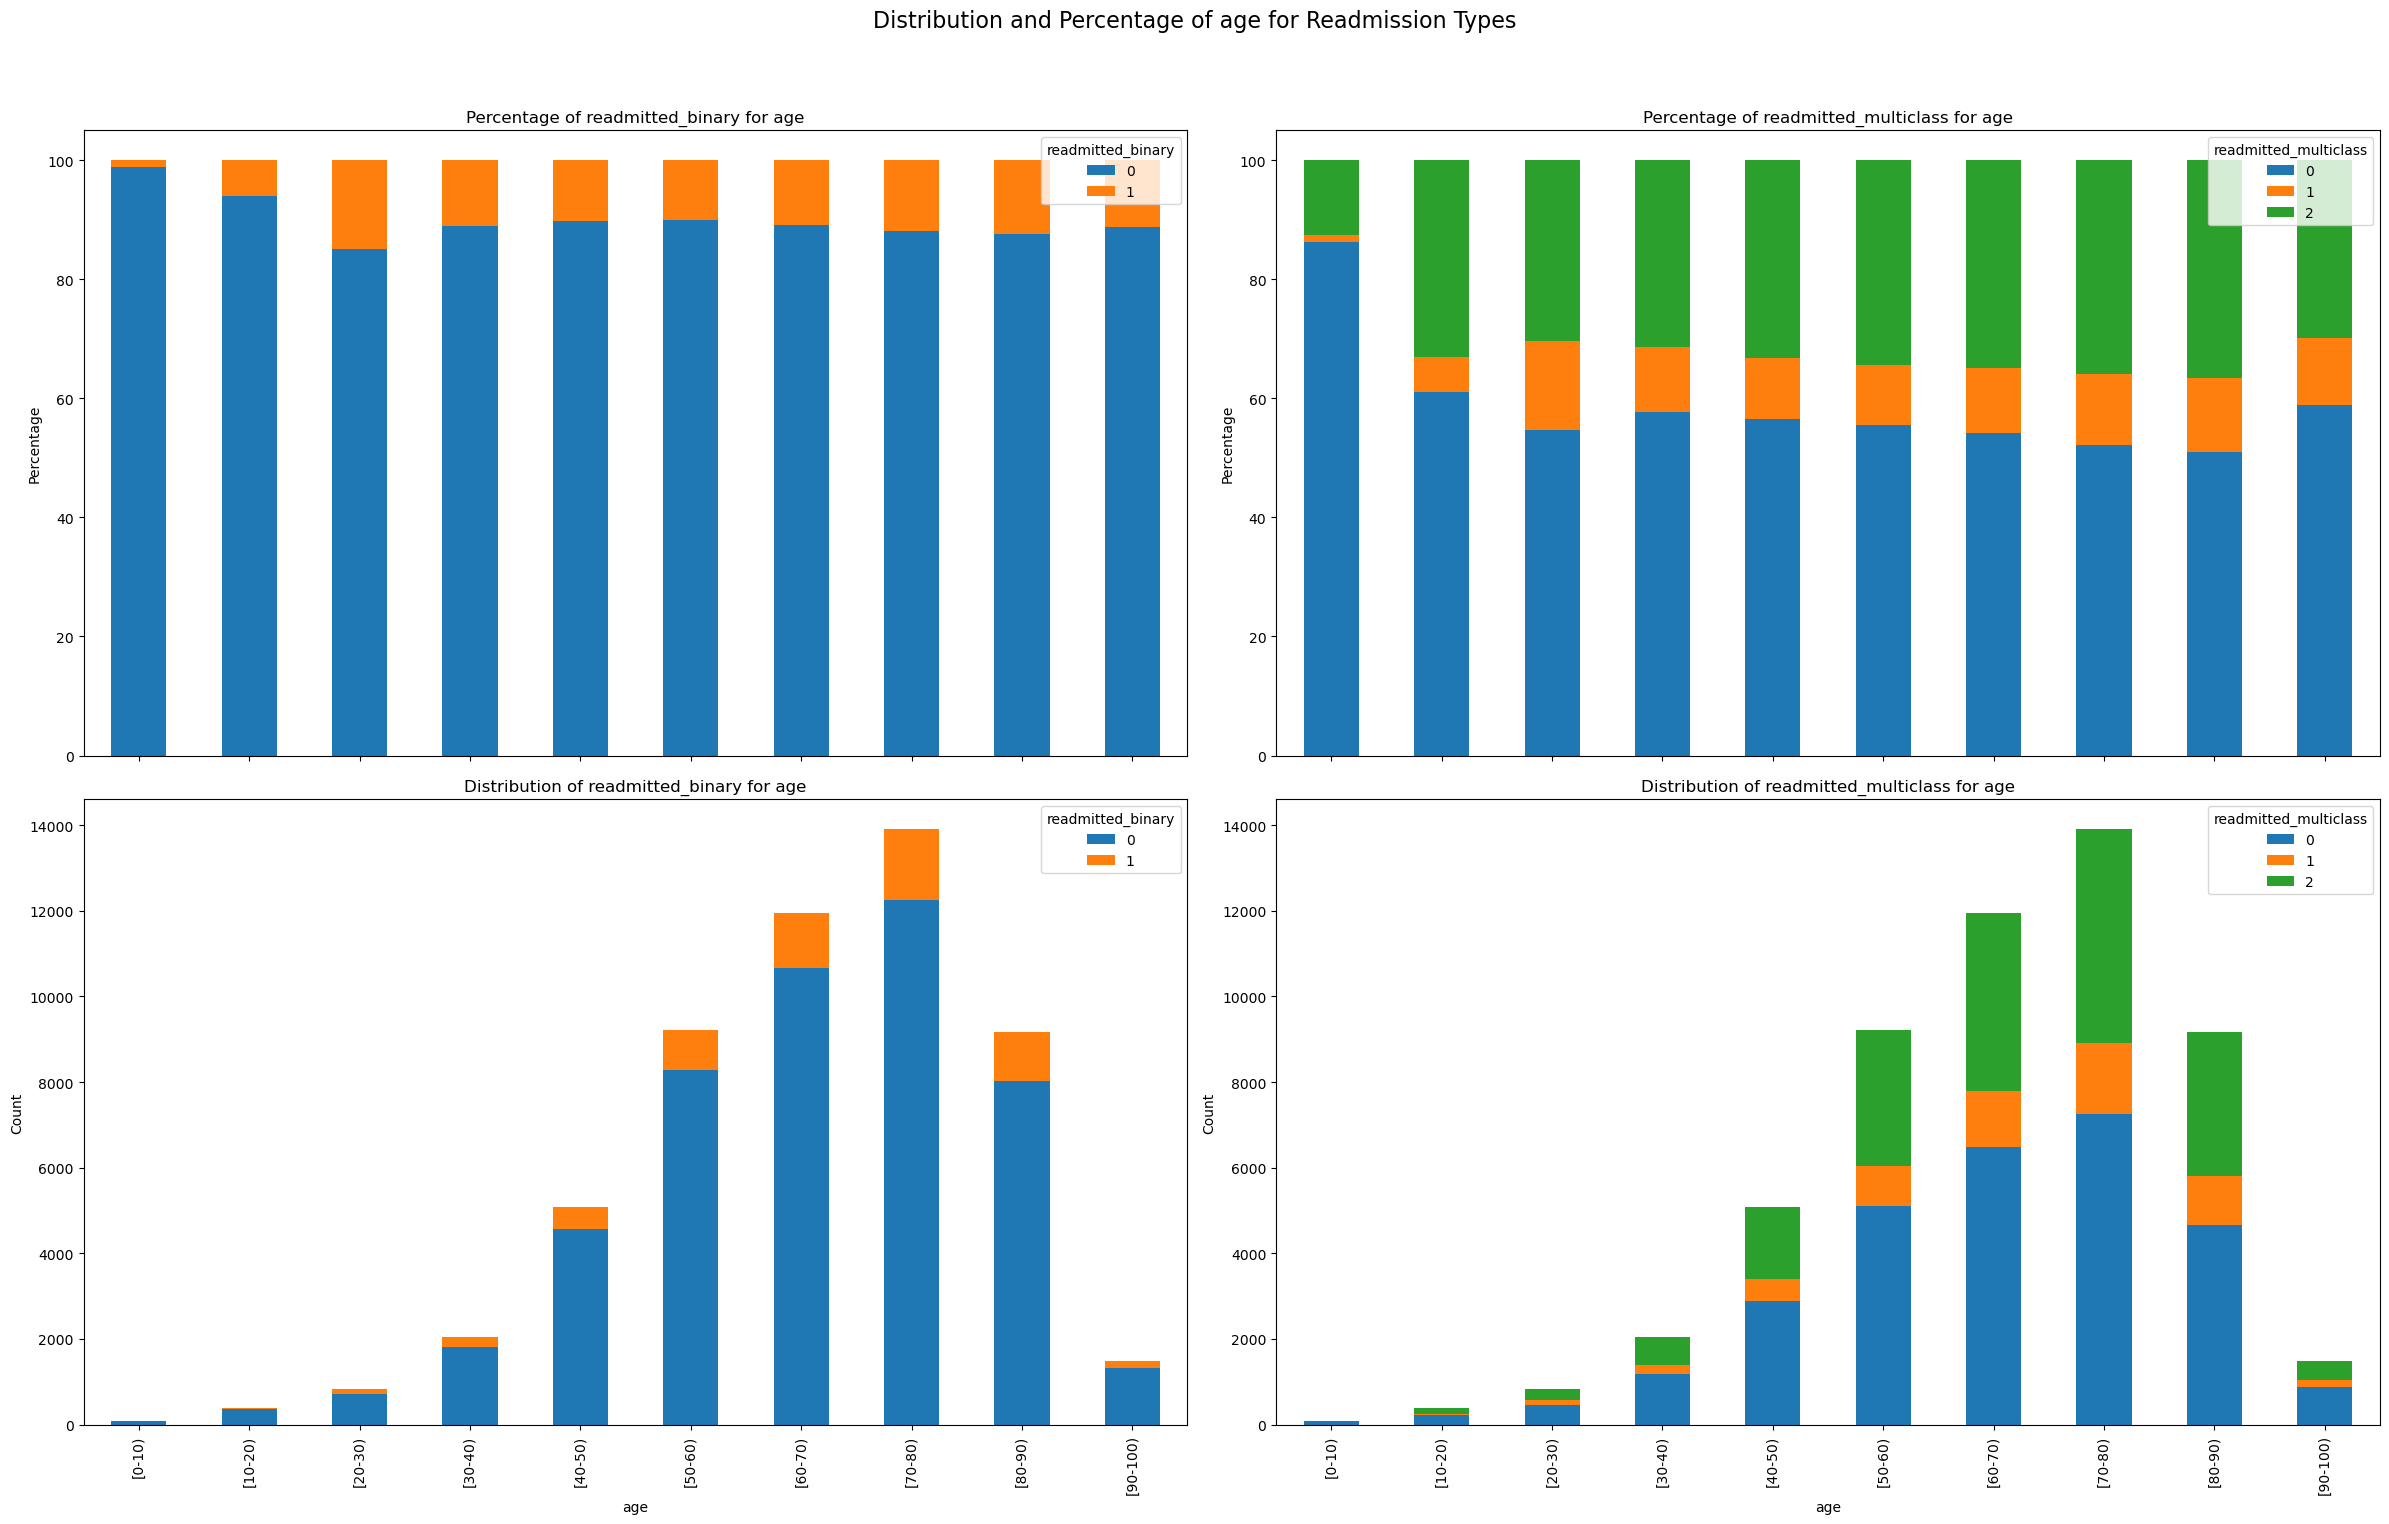

In [1527]:
plot_categorical_distribution(data_train, 'age')

In [1528]:
## Encode age seperate

# Define the mapping
age_mapping = {
    '[0-10)': 1,
    '[10-20)': 2,
    '[20-30)': 3,
    '[30-40)': 4,
    '[40-50)': 5,
    '[50-60)': 6,
    '[60-70)': 7,
    '[70-80)': 8,
    '[80-90)': 9,
    '[90-100)': 10
}

# Apply the mapping to the 'age' column
data_train['age'] = data_train['age'].map(age_mapping)
data_val['age'] = data_val['age'].map(age_mapping)
data_test['age'] = data_test['age'].map(age_mapping)

#### weight

In [1529]:
# drop weight column since it has too many missing values
data_train.drop(['weight'], axis=1, inplace=True)
data_val.drop(['weight'], axis=1, inplace=True)
data_test.drop(['weight'], axis=1, inplace=True)

#### payer_code

In [1530]:
# drop payer_code column since it has too many missing values
data_train.drop(['payer_code'], axis=1, inplace=True)
data_val.drop(['payer_code'], axis=1, inplace=True)
data_test.drop(['payer_code'], axis=1, inplace=True)

#### outpatient_visits_in_previous_year

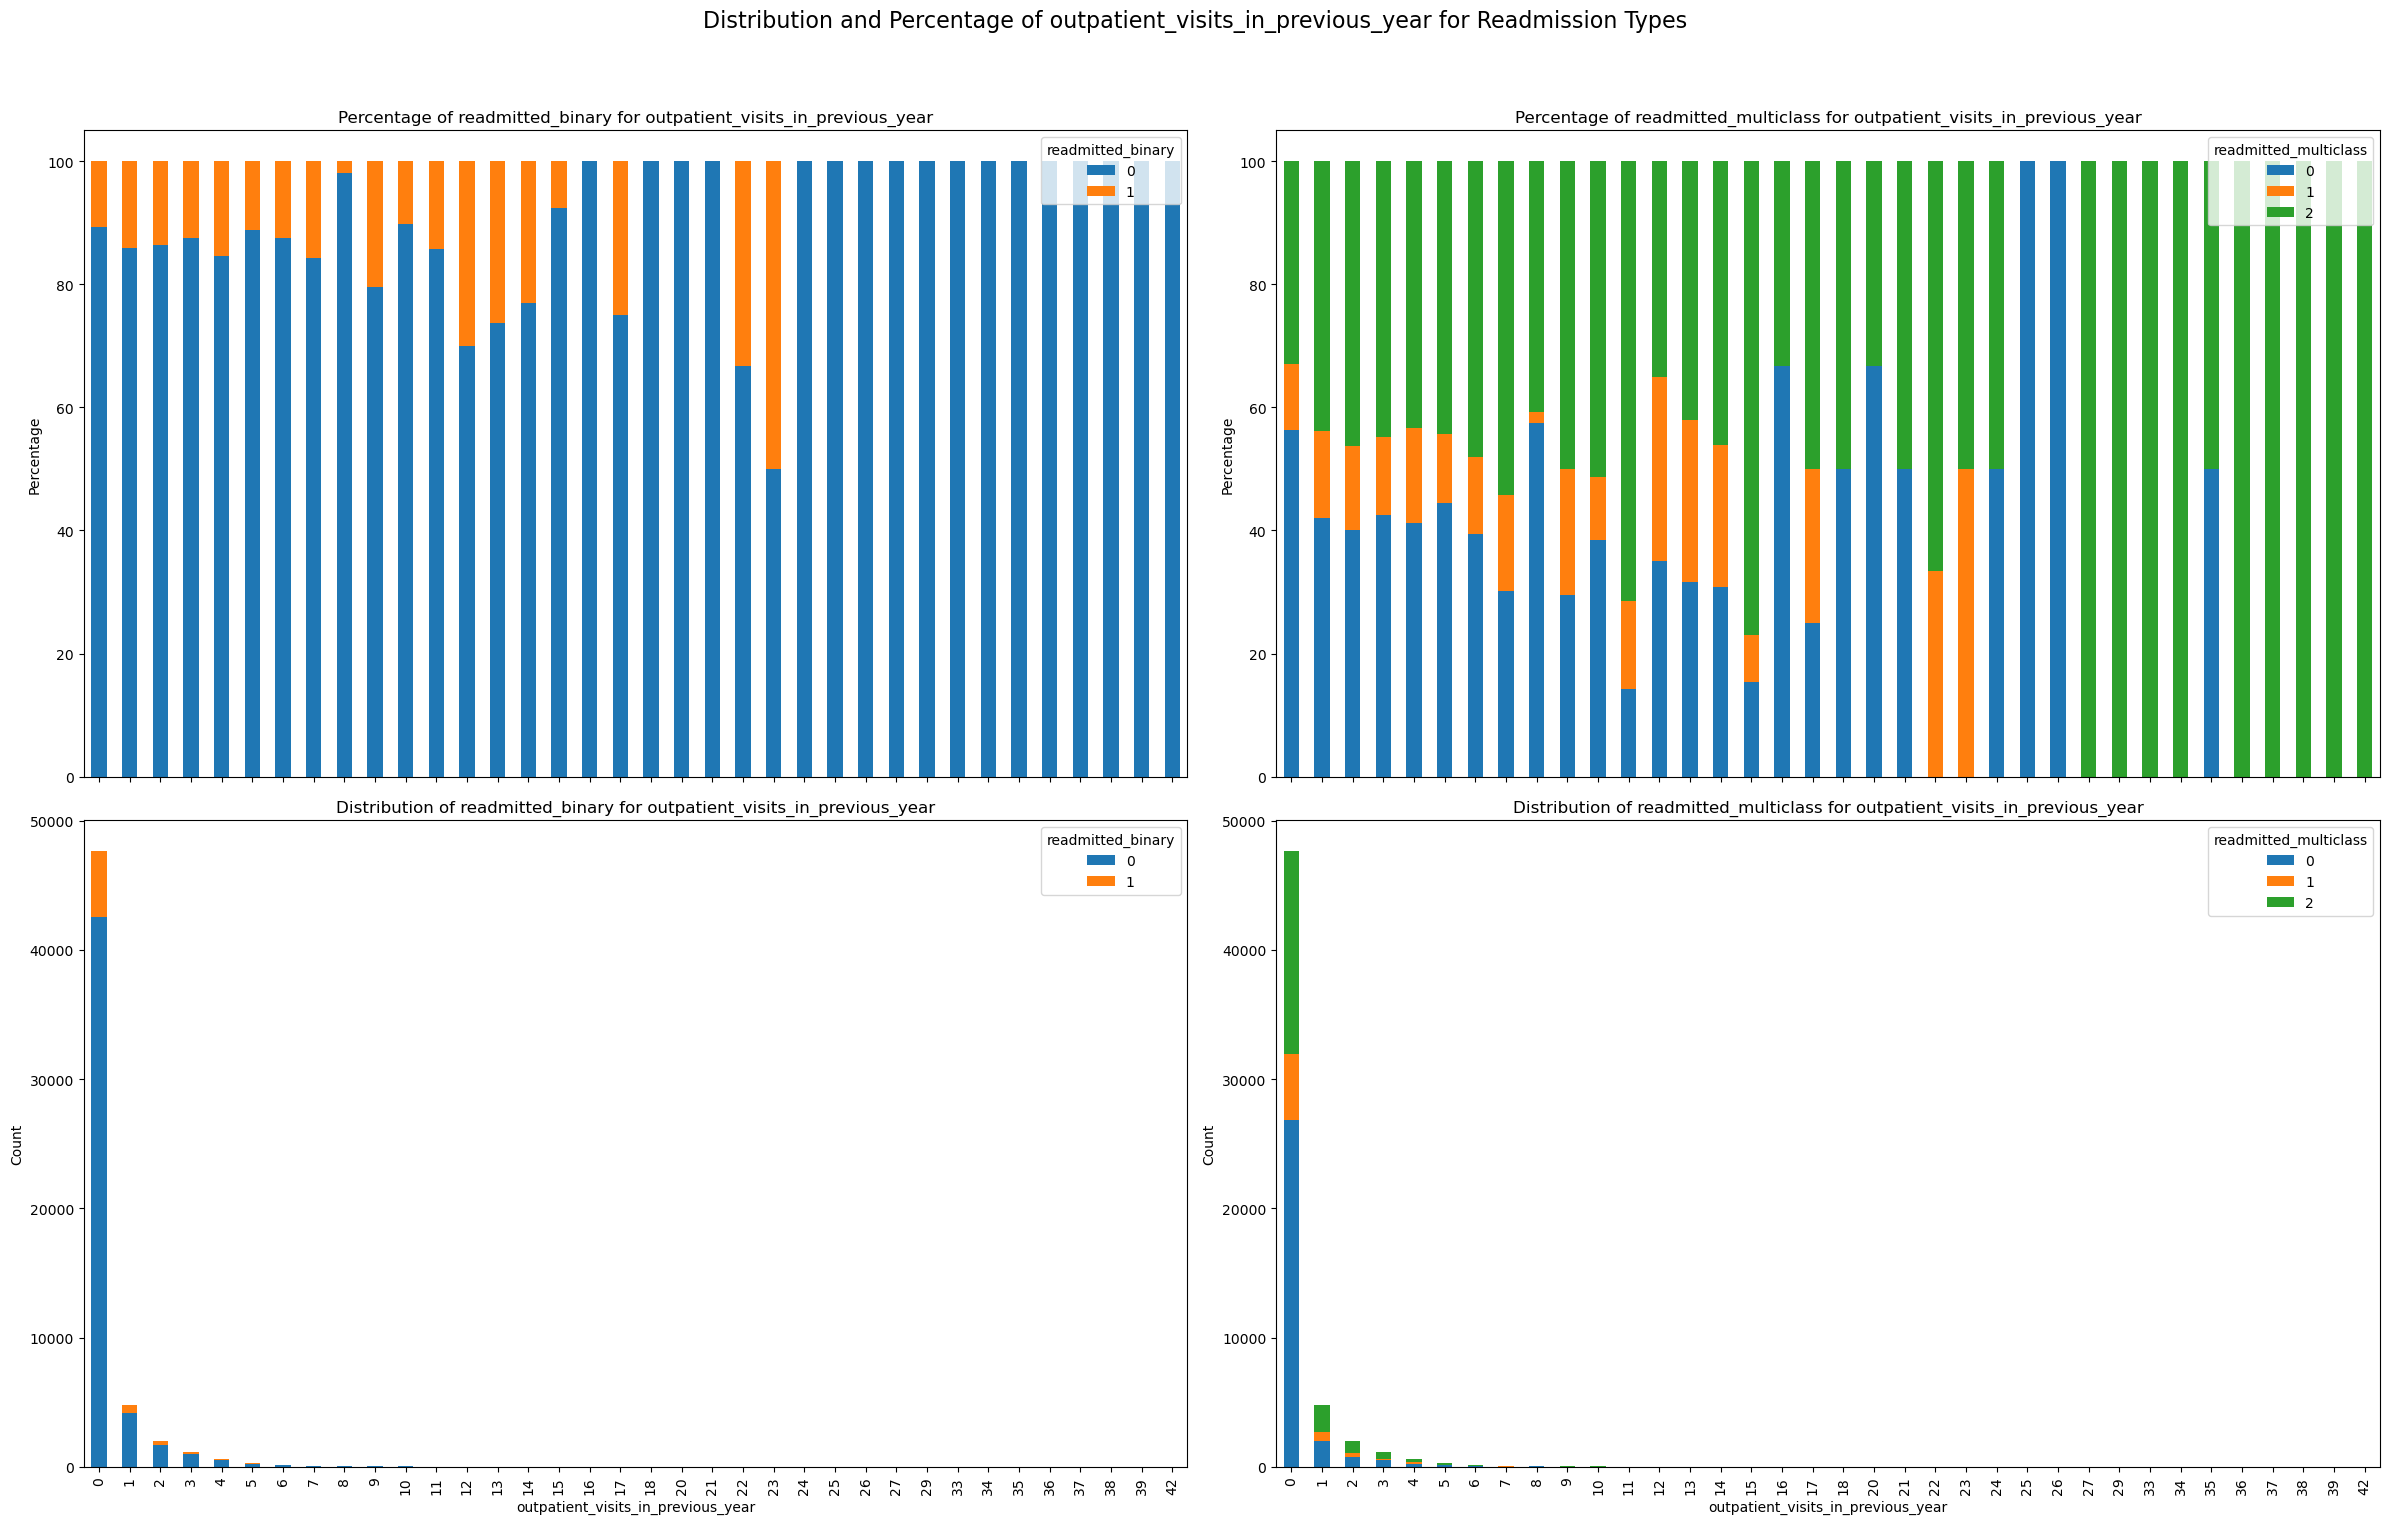

In [1531]:
plot_categorical_distribution(data_train, 'outpatient_visits_in_previous_year')

In [1532]:
# Outpatient Visits
cap_outpatient = cap_outliers(data_train, 'outpatient_visits_in_previous_year', 0.99)
data_val['outpatient_visits_in_previous_year'] = data_val['outpatient_visits_in_previous_year'].clip(upper=cap_outpatient)
data_test['outpatient_visits_in_previous_year'] = data_test['outpatient_visits_in_previous_year'].clip(upper=cap_outpatient)

#### inpatient_visits_in_previous_year

In [1533]:
cap_inpatient = cap_outliers(data_train, 'inpatient_visits_in_previous_year', 0.99)
data_val['inpatient_visits_in_previous_year'] = data_val['inpatient_visits_in_previous_year'].clip(upper=cap_inpatient)
data_test['inpatient_visits_in_previous_year'] = data_test['inpatient_visits_in_previous_year'].clip(upper=cap_inpatient)

#### emergency_visits_in_previous_year

In [1534]:
# Emergency Visits
cap_emergency = cap_outliers(data_train, 'emergency_visits_in_previous_year', 0.99)
data_val['emergency_visits_in_previous_year'] = data_val['emergency_visits_in_previous_year'].clip(upper=cap_emergency)
data_test['emergency_visits_in_previous_year'] = data_test['emergency_visits_in_previous_year'].clip(upper=cap_emergency)

#### admission_type

In [1535]:
data_train['admission_type'].value_counts()

admission_type
Emergency        30157
Elective         10624
Urgent           10435
Not Available     2616
Not Mapped         175
Trauma Center       10
Newborn              5
Name: count, dtype: int64

In [1536]:
# fill missing values with 'Not Available'
data_train['admission_type'] = data_train['admission_type'].fillna('Not Available')
# replace not mapped values with 'Not Available'
data_train['admission_type'] = data_train['admission_type'].replace('Not Mapped', 'Not Available')

data_val['admission_type'] = data_val['admission_type'].fillna('Not Available')
data_val['admission_type'] = data_val['admission_type'].replace('Not Mapped', 'Not Available')

data_test['admission_type'] = data_test['admission_type'].fillna('Not Available')
data_test['admission_type'] = data_test['admission_type'].replace('Not Mapped', 'Not Available')

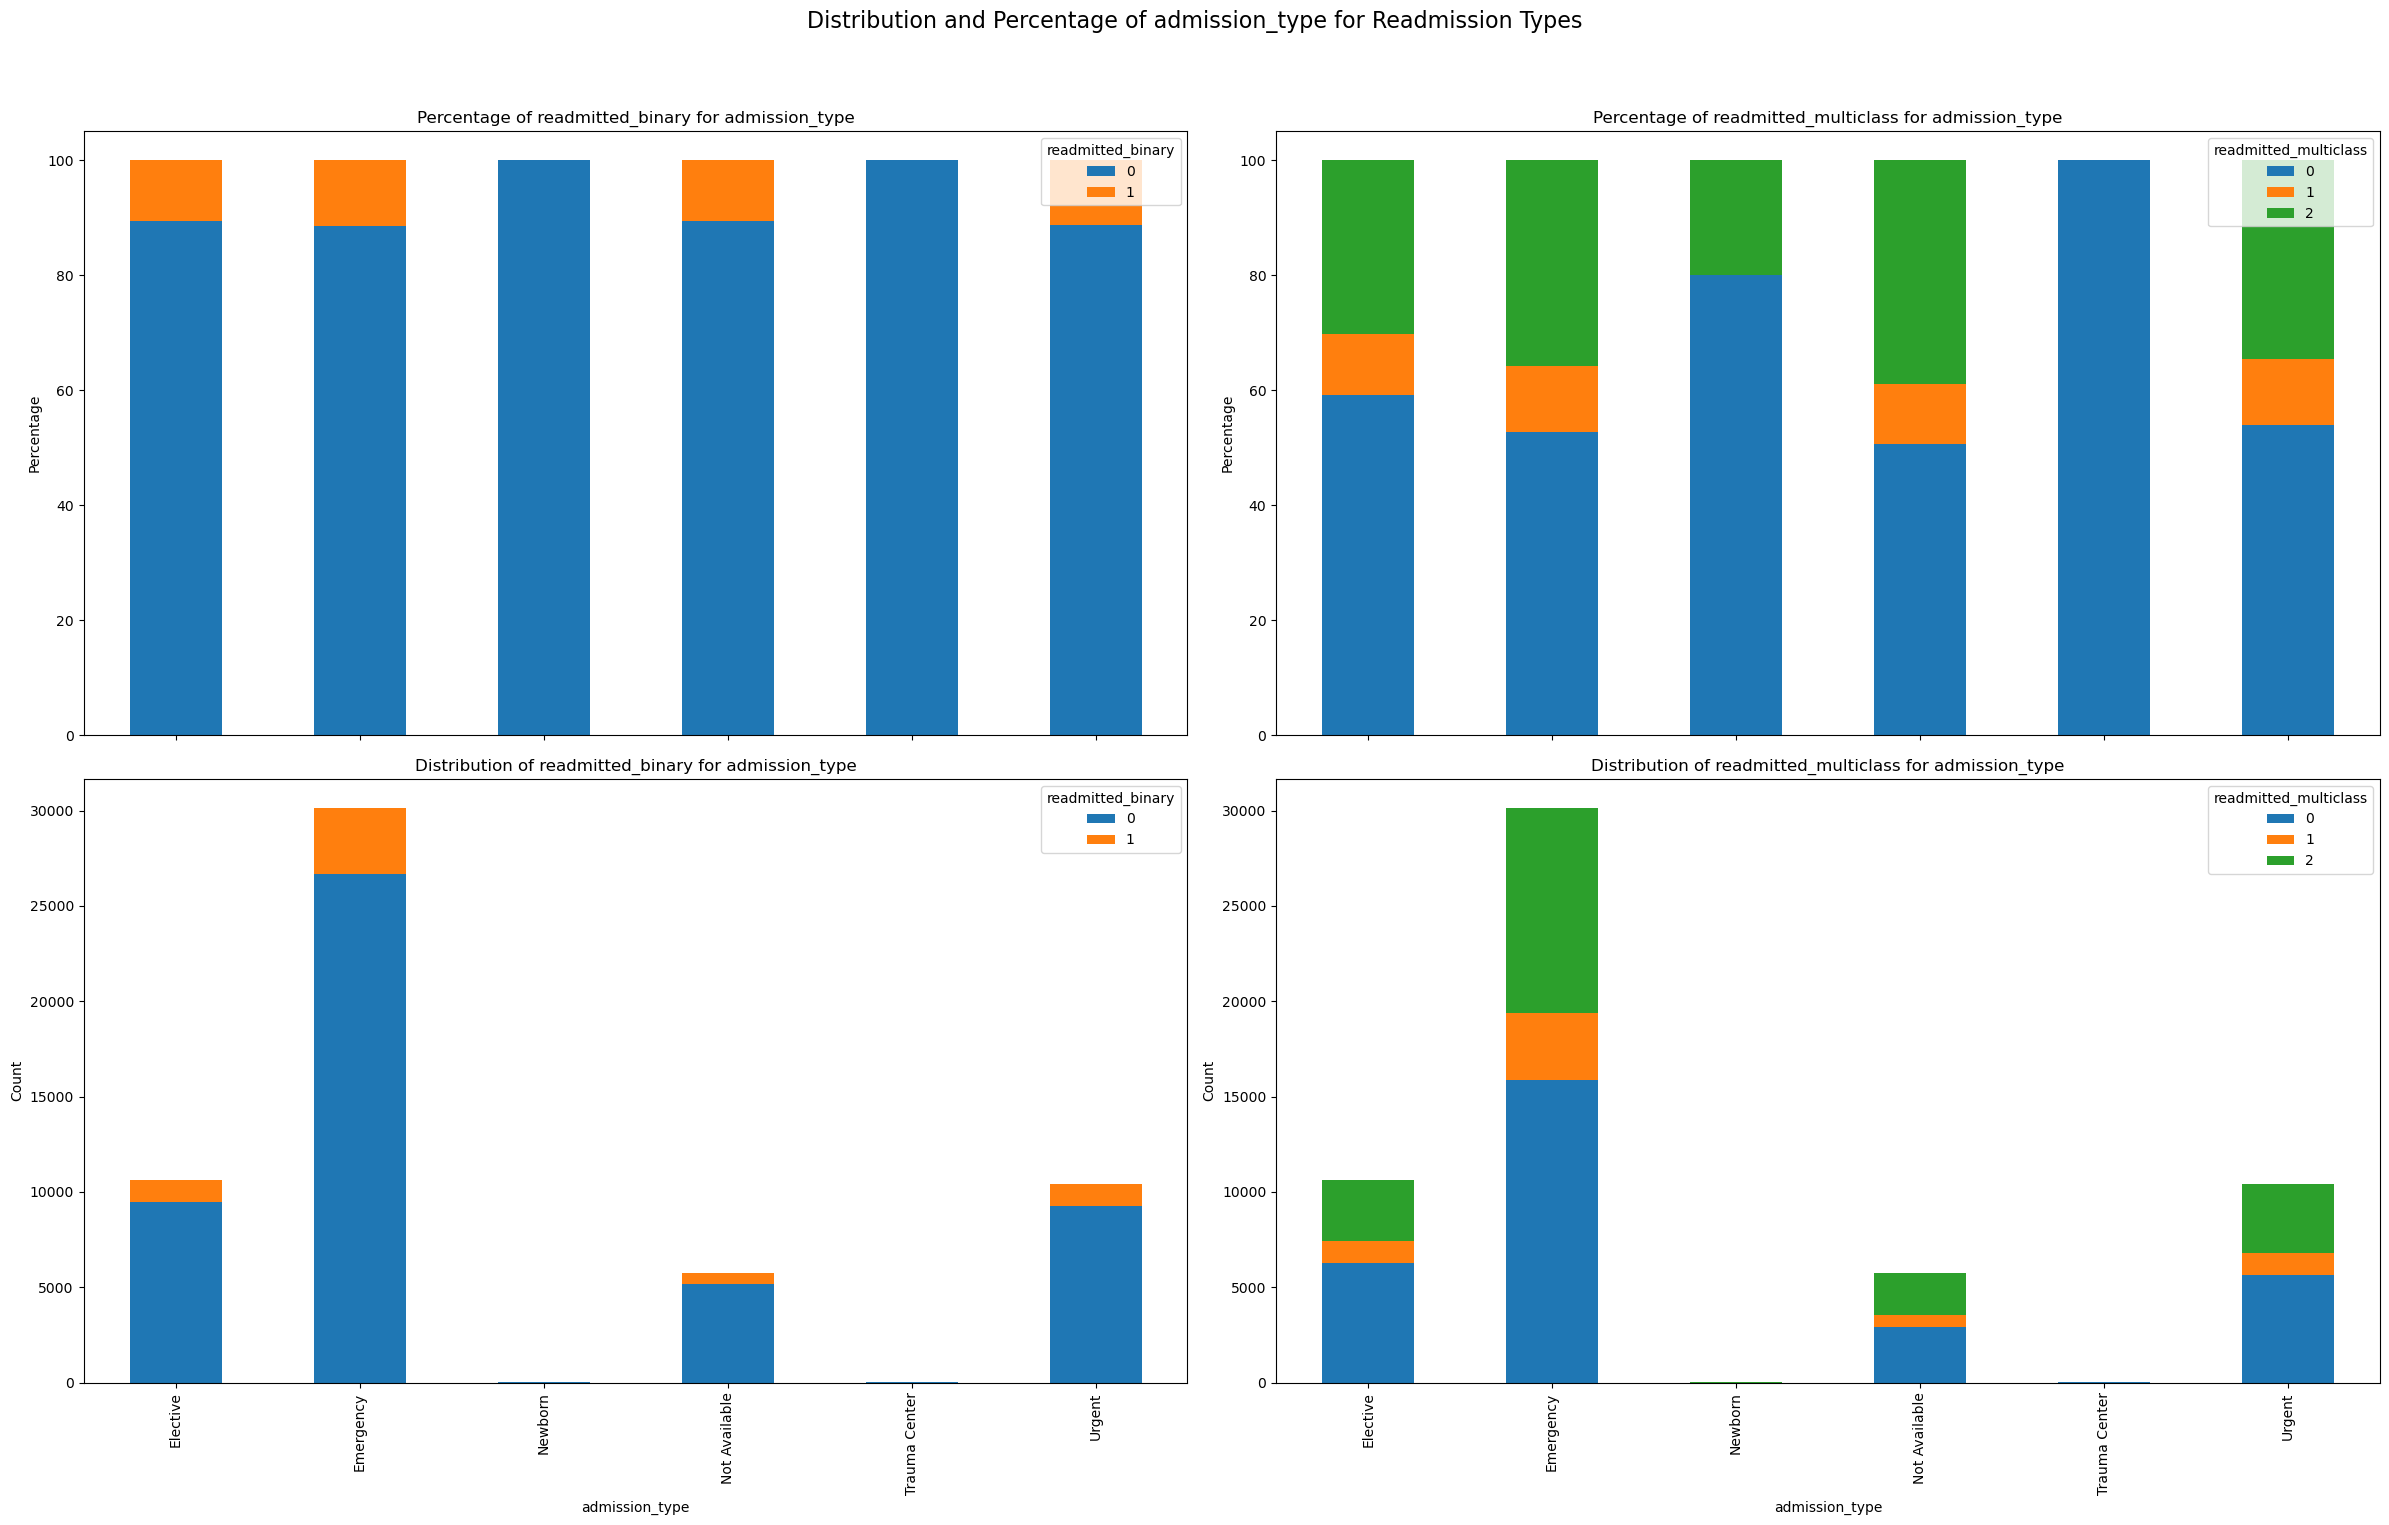

In [1537]:
plot_categorical_distribution(data_train, 'admission_type')

#### medical_specialty

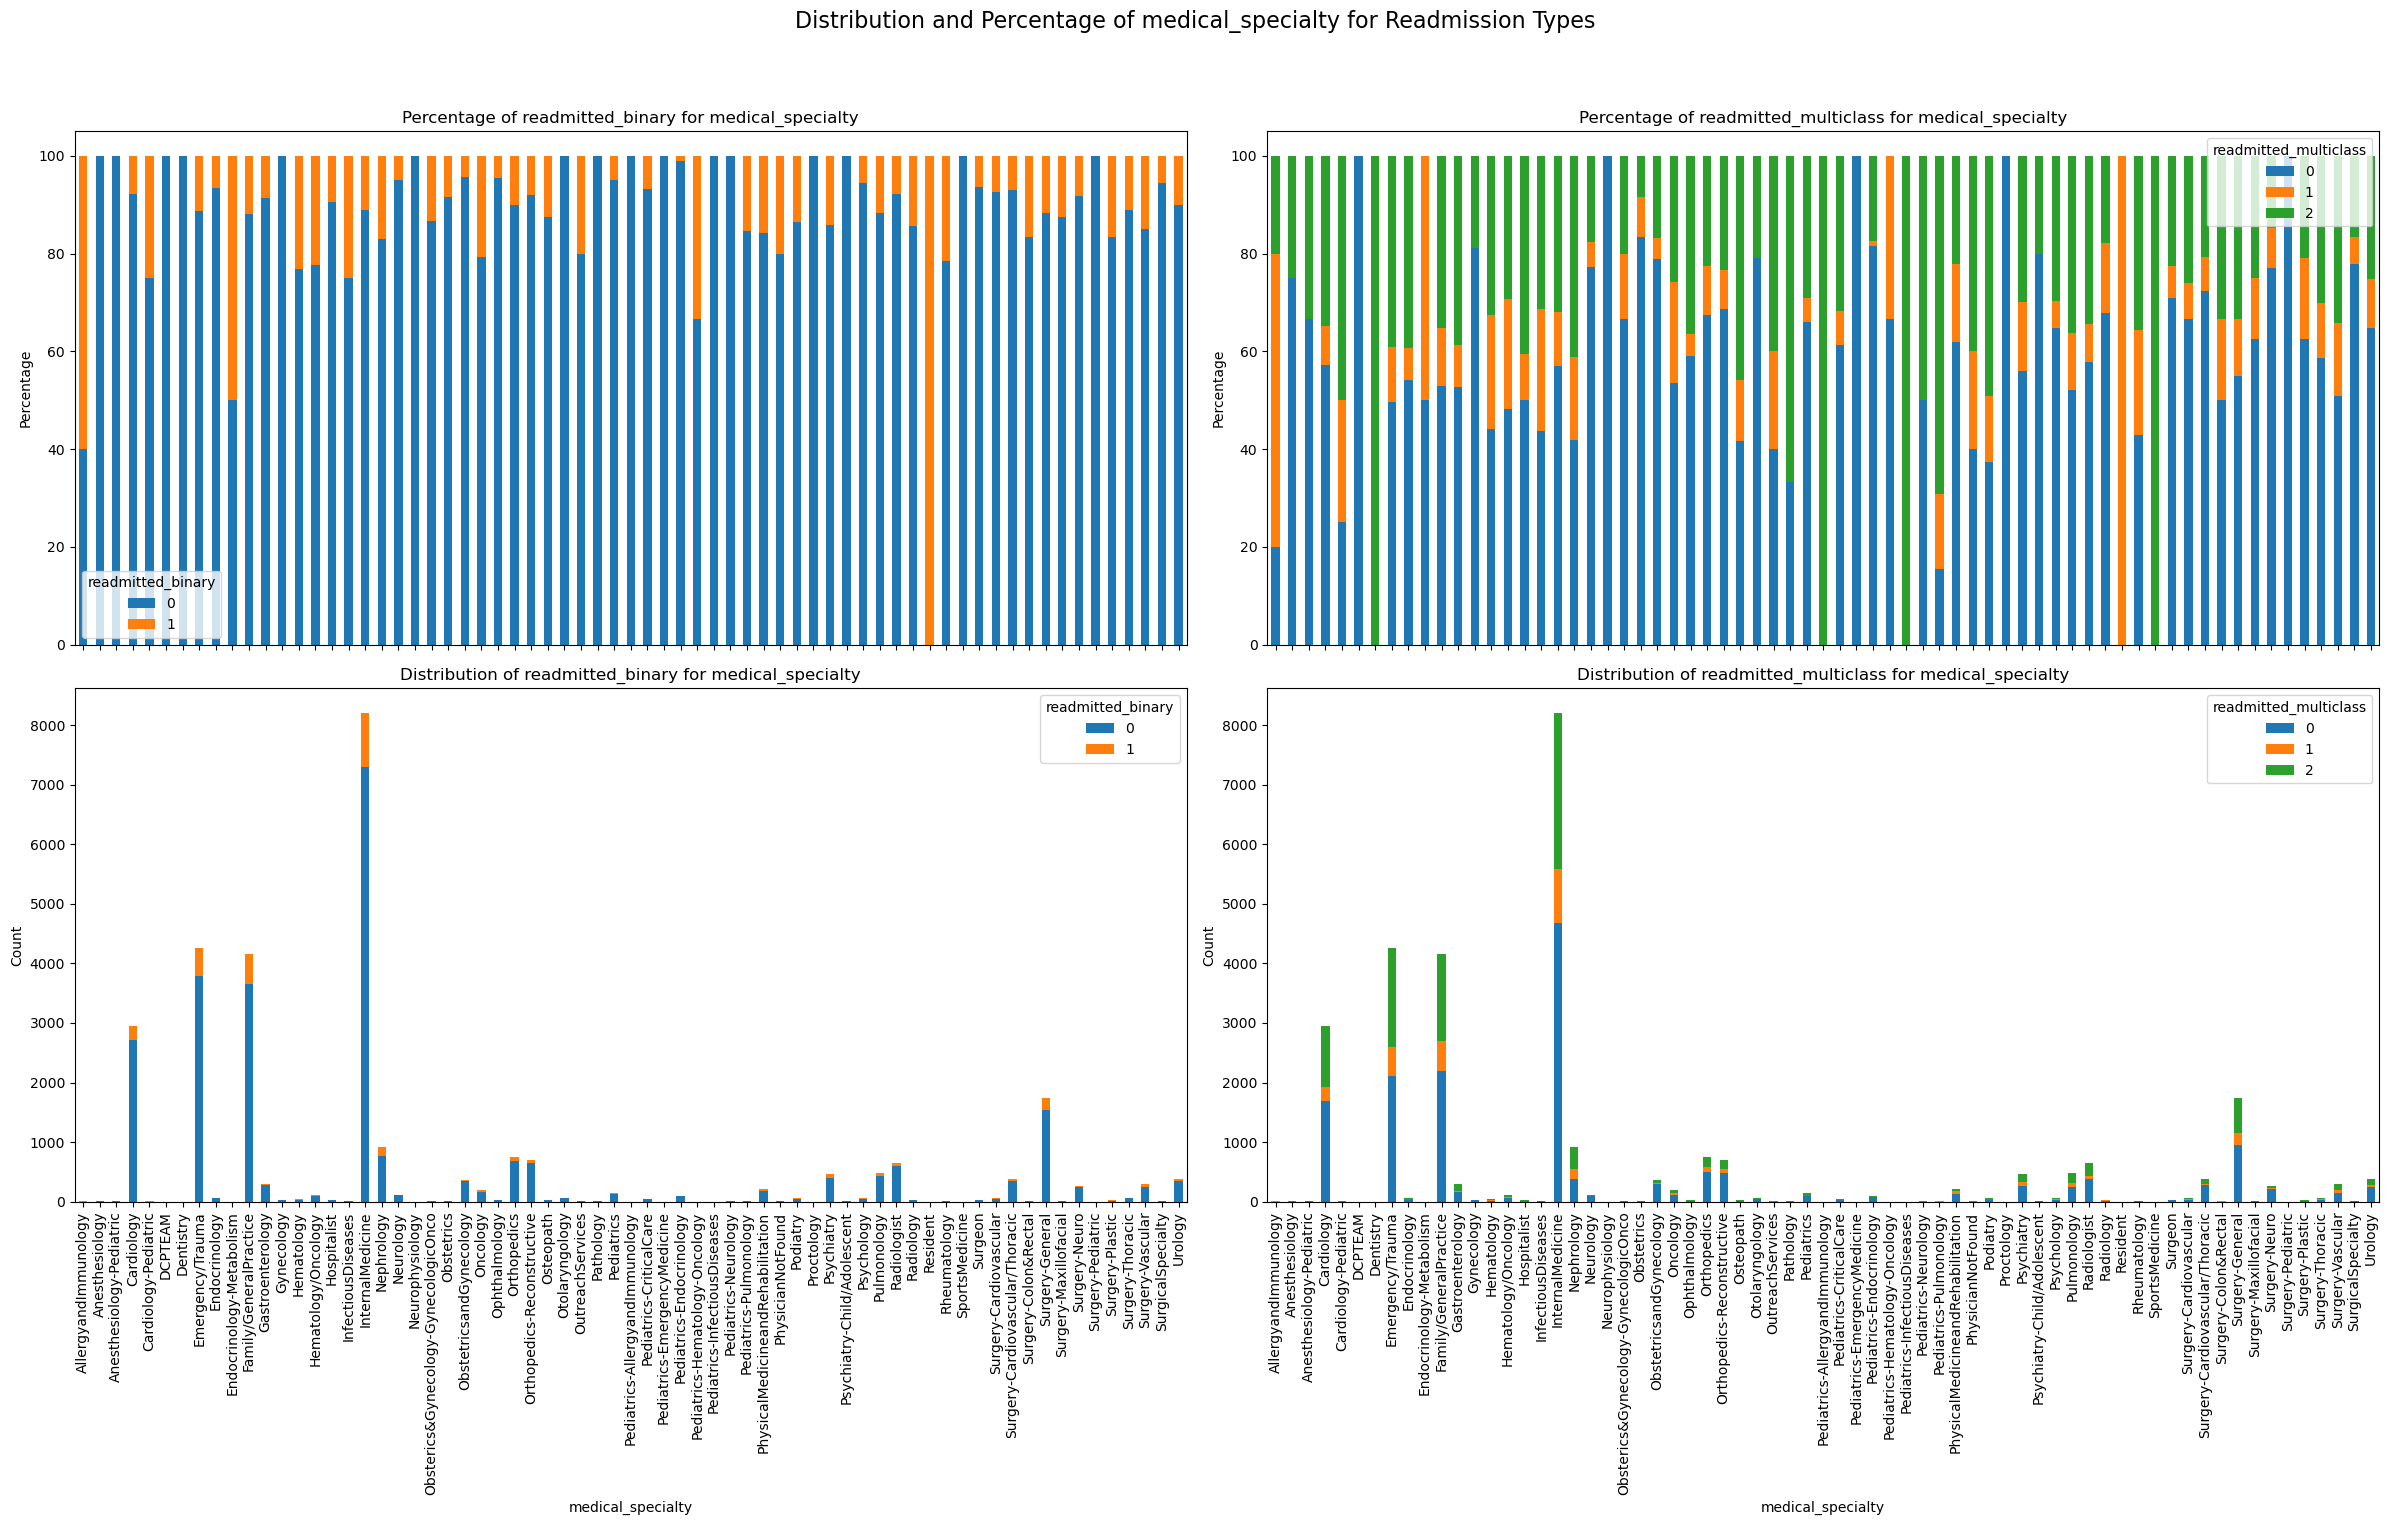

In [1538]:
plot_categorical_distribution(data_train, 'medical_specialty')

In [1539]:
# medical_specialty replace missing values with 'Not Specified' as they might be missing for a reason like the patient not having a medical specialty
data_train['medical_specialty'] = data_train['medical_specialty'].fillna('Not Specified')
data_val['medical_specialty'] = data_val['medical_specialty'].fillna('Not Specified')
data_test['medical_specialty'] = data_test['medical_specialty'].fillna('Not Specified')

In [1540]:
# drop medical_specialty column since it has too many missing values
data_train.drop(['medical_specialty'], axis=1, inplace=True)
data_val.drop(['medical_specialty'], axis=1, inplace=True)
data_test.drop(['medical_specialty'], axis=1, inplace=True)


#### average_pulse_bpm

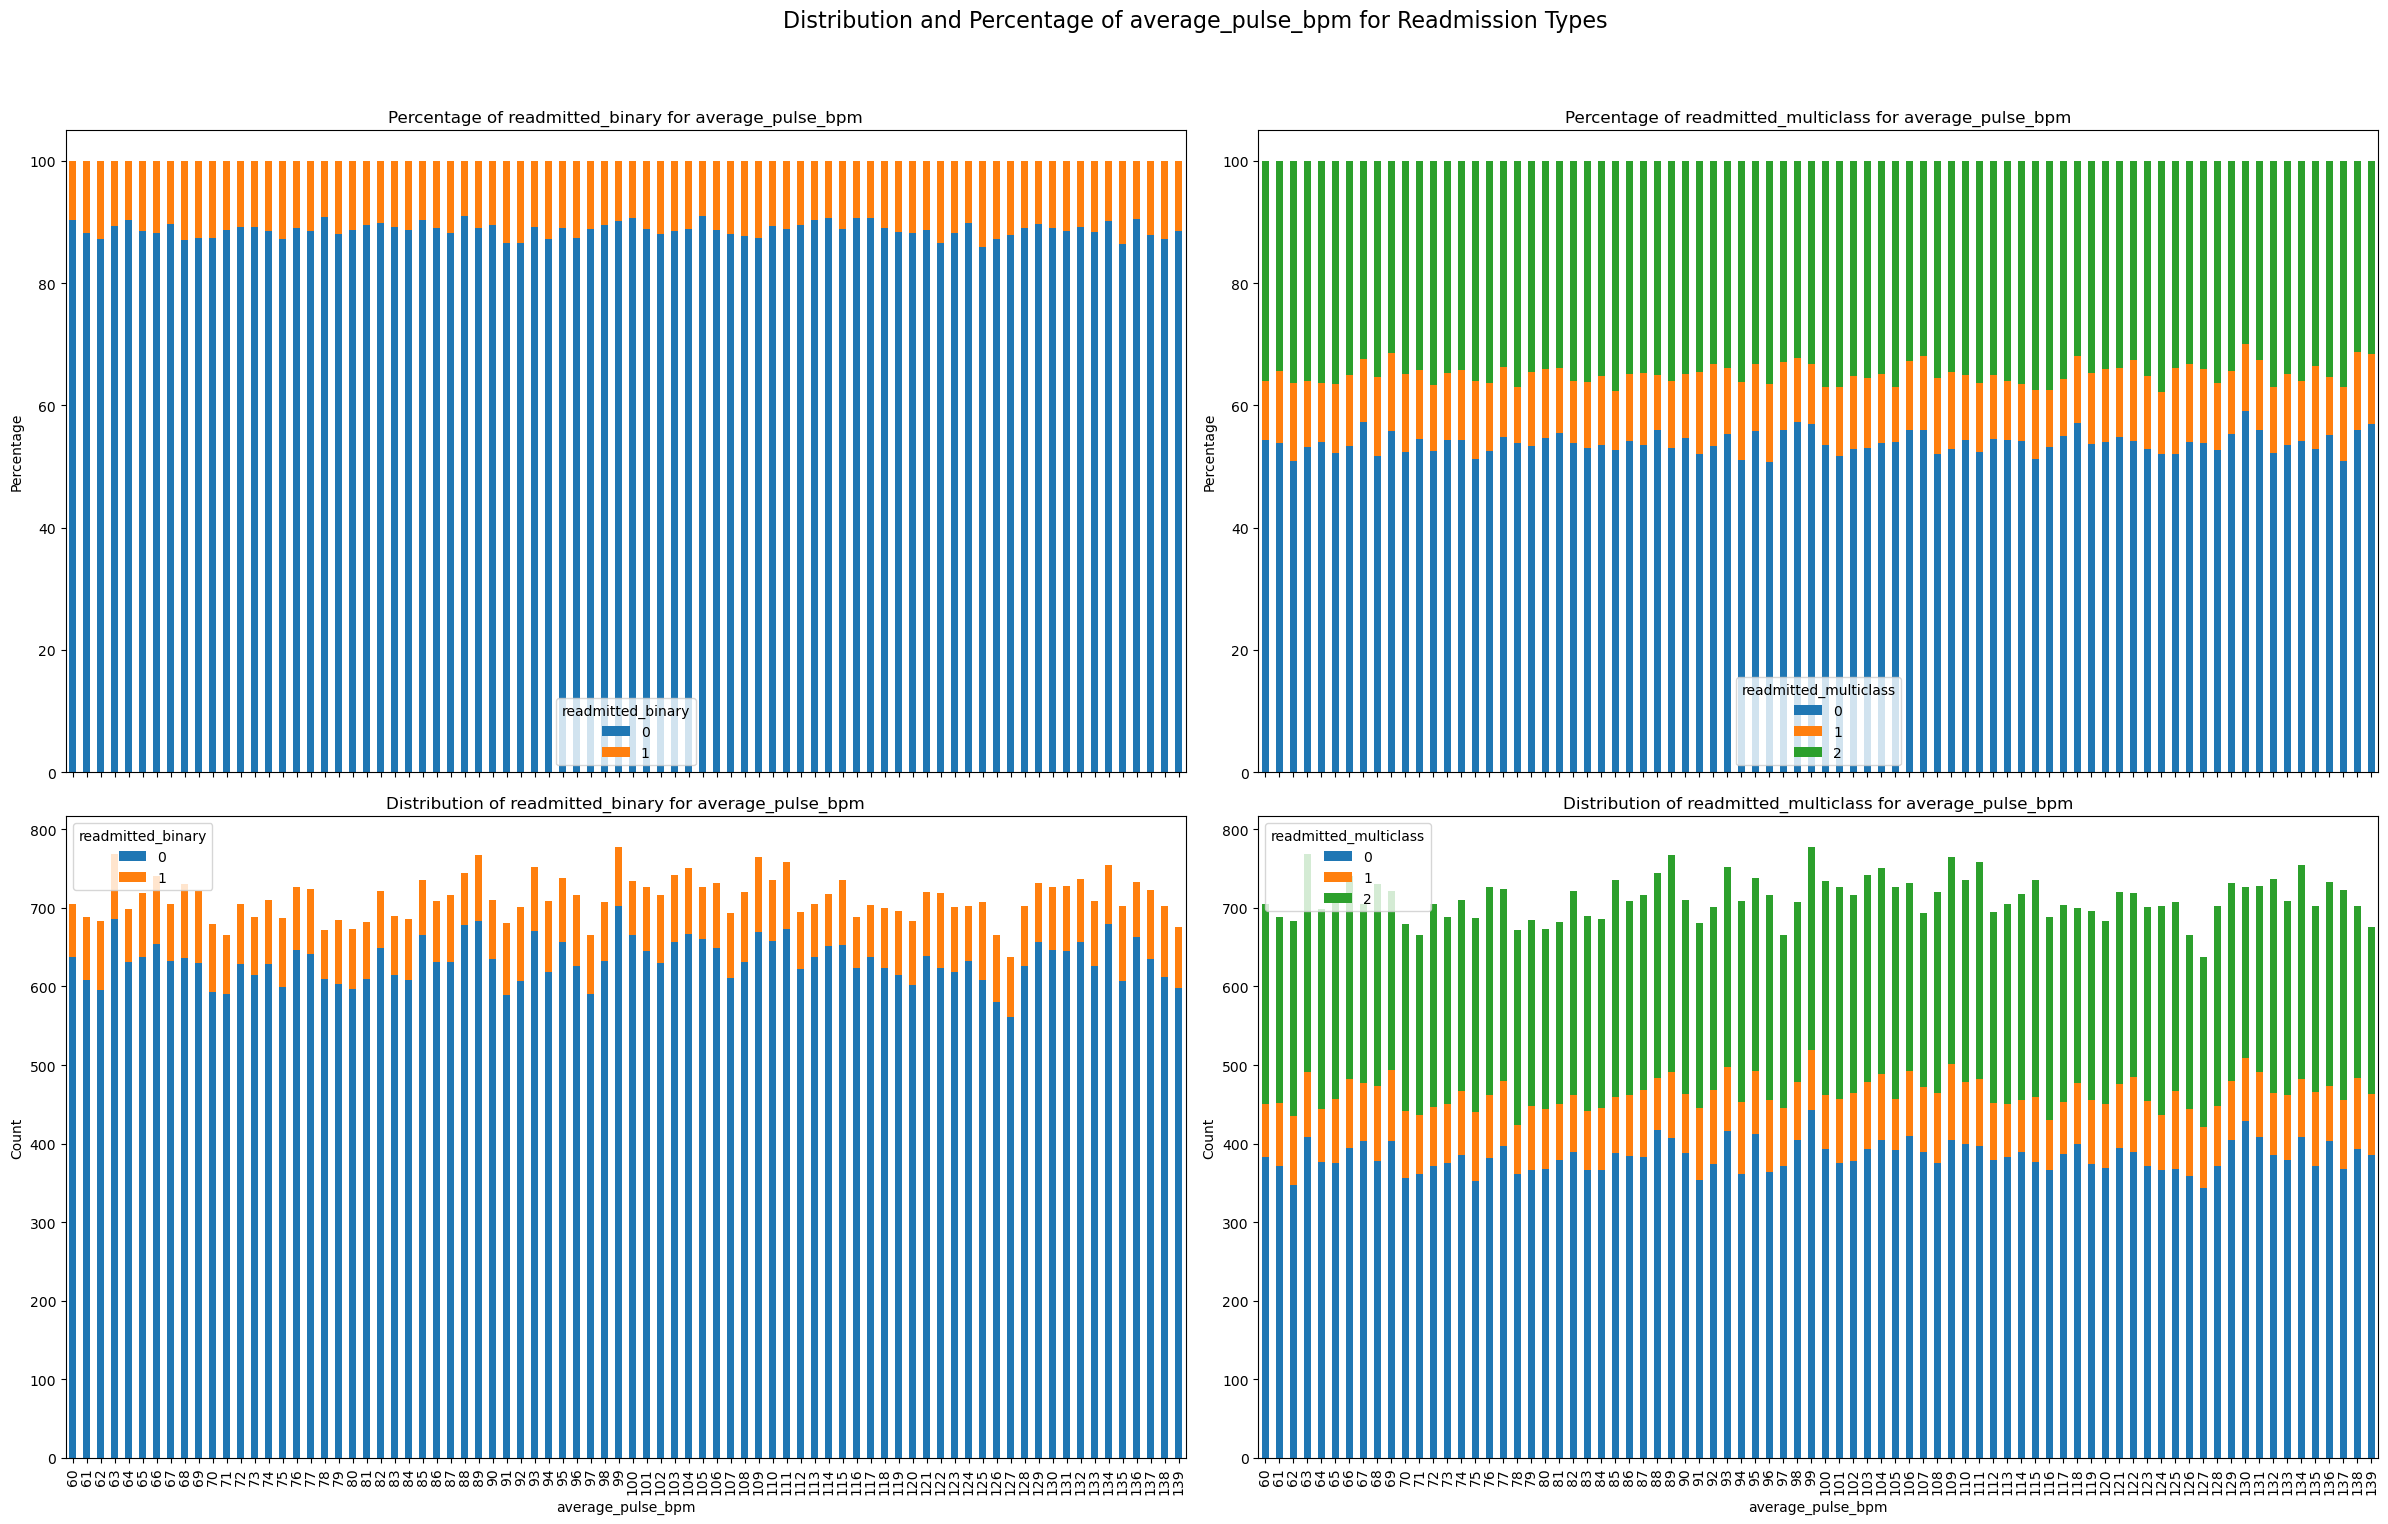

In [1541]:
plot_categorical_distribution(data_train, 'average_pulse_bpm')

In [1542]:
# as there is almost no variance in the data, we will drop
data_train.drop(['average_pulse_bpm'], axis=1, inplace=True)
data_val.drop(['average_pulse_bpm'], axis=1, inplace=True)
data_test.drop(['average_pulse_bpm'], axis=1, inplace=True)

#### discharge_disposition

In [1543]:
data_train['discharge_disposition'].value_counts()

discharge_disposition
Discharged to home                                                                                           33801
Discharged/transferred to SNF                                                                                 7825
Discharged/transferred to home with home health service                                                       7204
Discharged/transferred to another short term hospital                                                         1197
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1109
Expired                                                                                                        922
Discharged/transferred to another type of inpatient care institution                                           658
Not Mapped                                                                                                     549
Discharged/transferred to ICF                             

In [1544]:
# fill missing values with 'Not Mapped'
data_train['discharge_disposition'] = data_train['discharge_disposition'].fillna('Not Mapped')
data_val['discharge_disposition'] = data_val['discharge_disposition'].fillna('Not Mapped')
data_test['discharge_disposition'] = data_test['discharge_disposition'].fillna('Not Mapped')

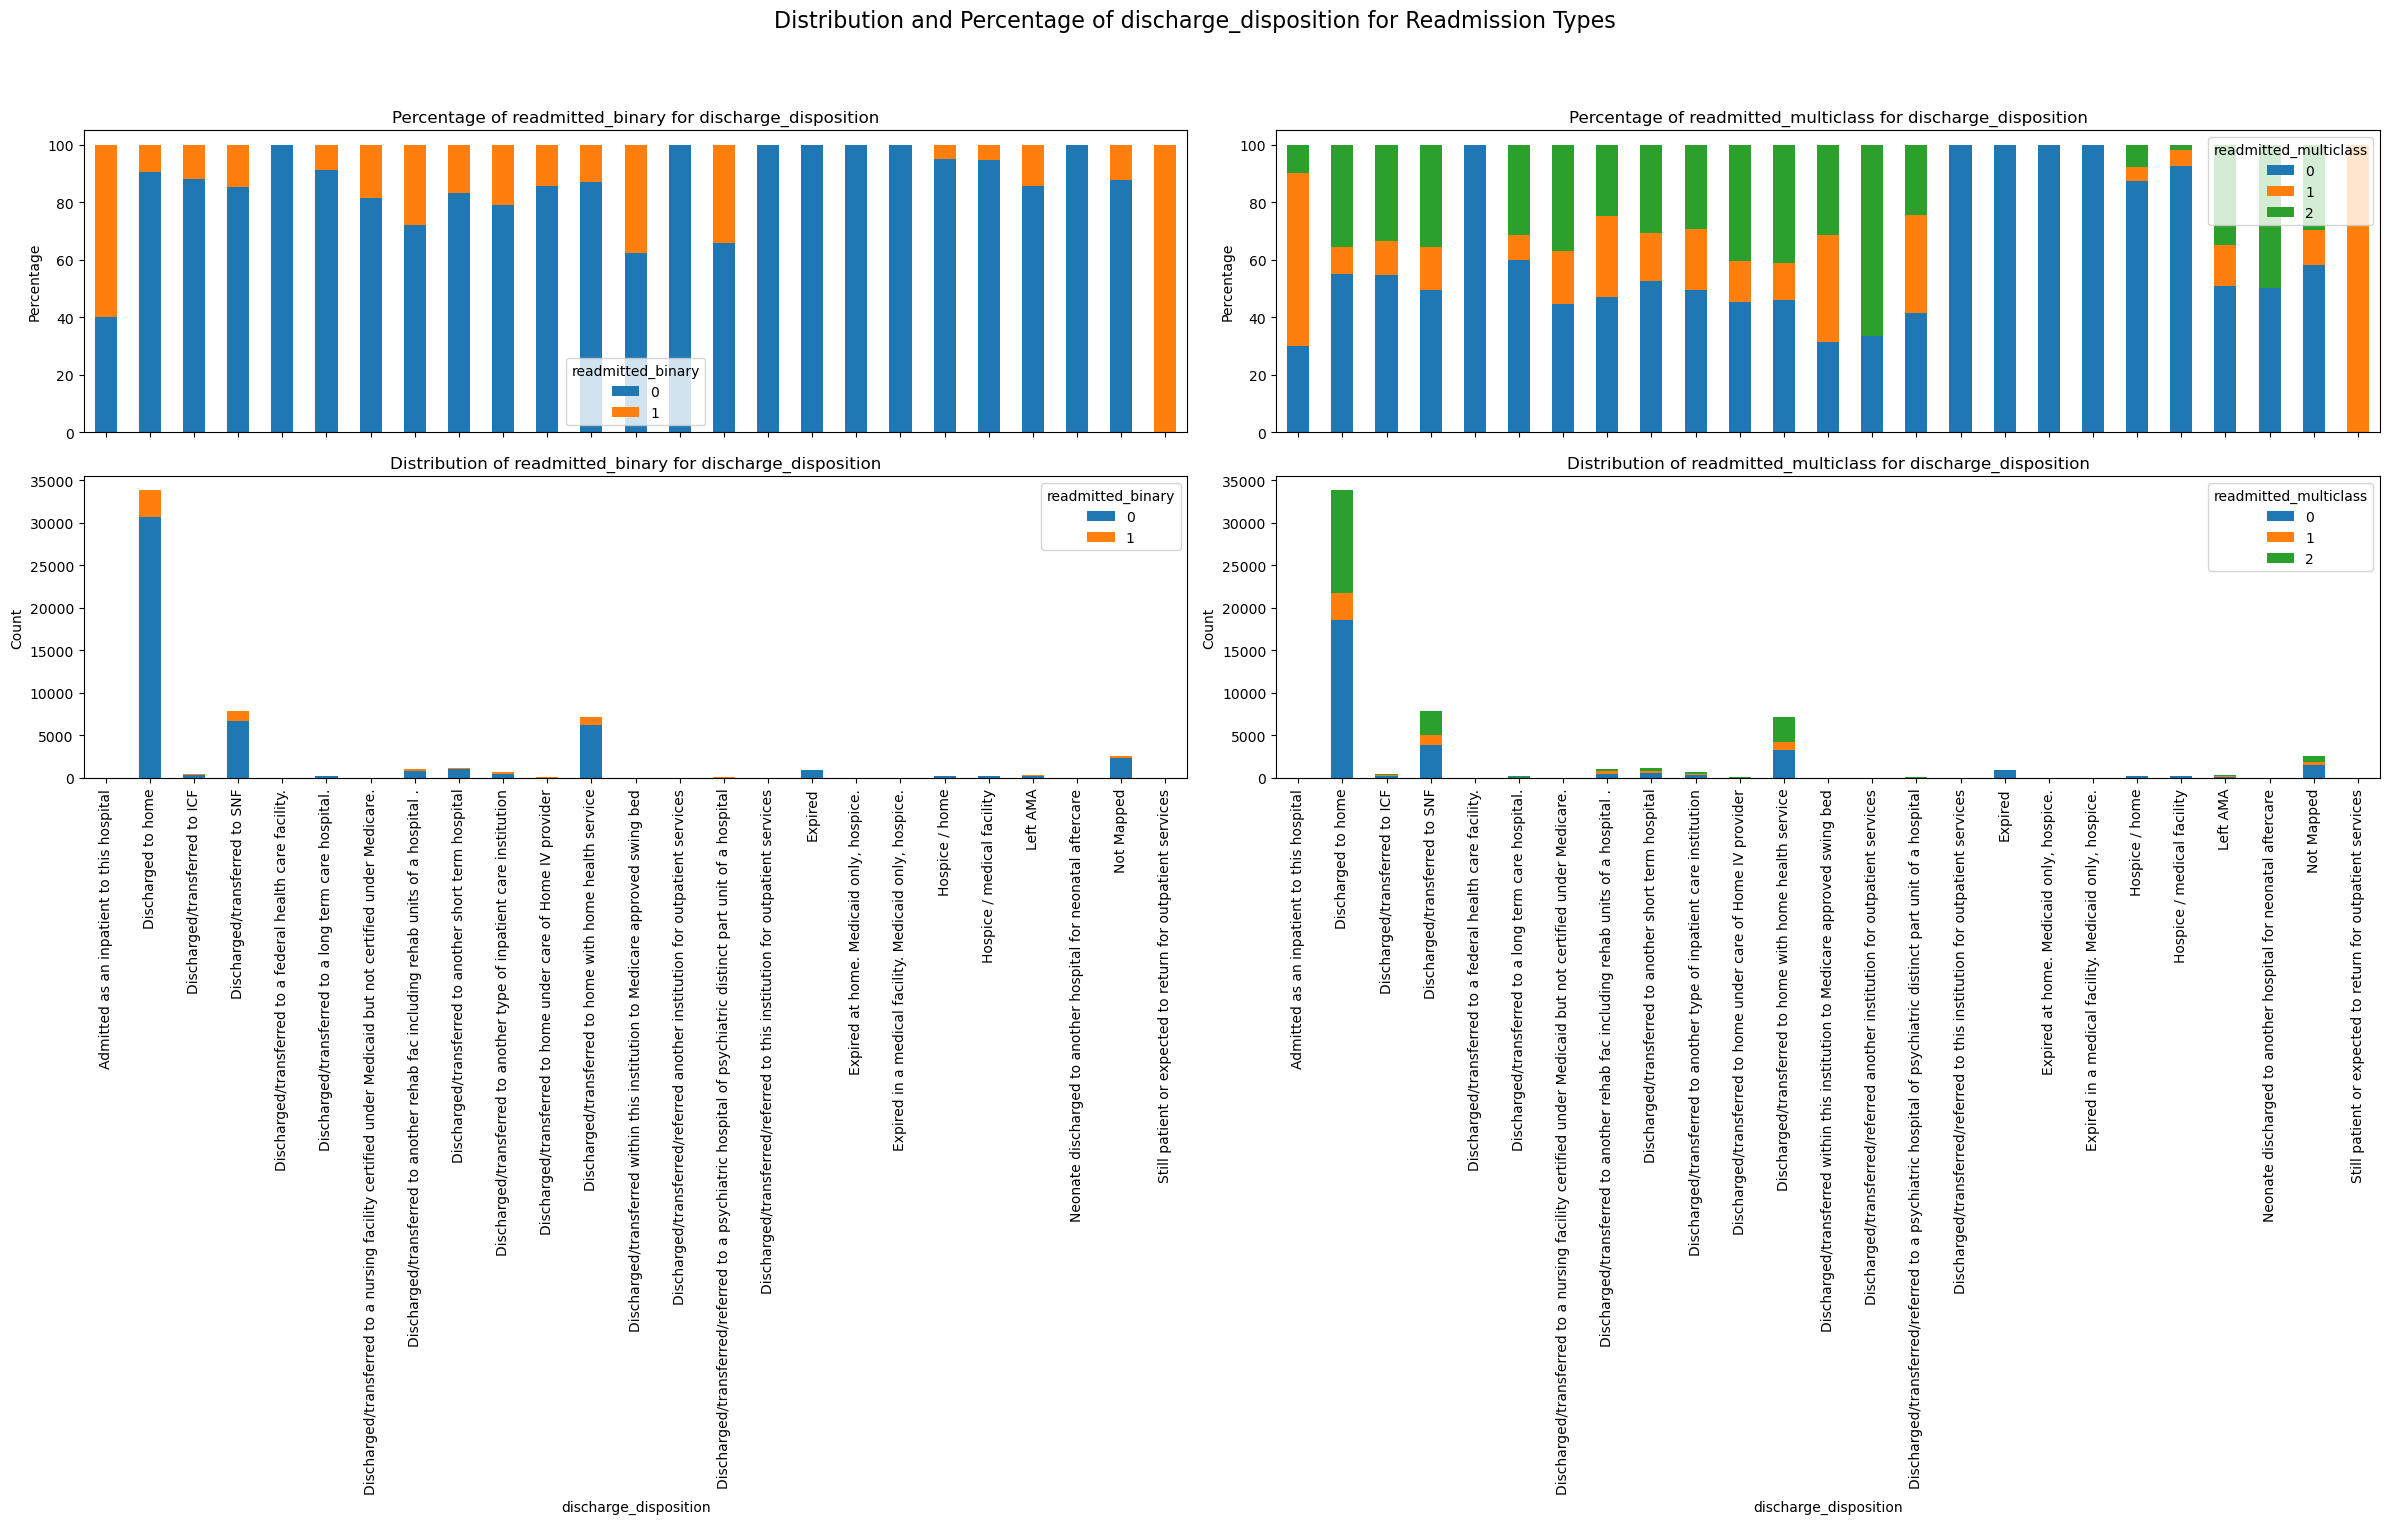

In [1545]:
plot_categorical_distribution(data_train, 'discharge_disposition')

In [1546]:
# combine categories that have 0% readmission rate

data_train['discharge_disposition'] = data_train['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Discharged/transferred/referred to this institution for outpatient services', 'Discharged/transferred/referred another institution for outpatient services', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired at home. Medicaid only, hospice.', 'Expired'], '100% Discharged')


data_val['discharge_disposition'] = data_val['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Discharged/transferred/referred to this institution for outpatient services', 'Discharged/transferred/referred another institution for outpatient services', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired at home. Medicaid only, hospice.', 'Expired'], '100% Discharged')


data_test['discharge_disposition'] = data_test['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Discharged/transferred/referred to this institution for outpatient services', 'Discharged/transferred/referred another institution for outpatient services', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired at home. Medicaid only, hospice.', 'Expired'], '100% Discharged')

#### admission_source

In [1547]:
data_train['admission_source'].value_counts()

admission_source
 Emergency Room                                               32188
 Physician Referral                                           16617
Transfer from a hospital                                       1782
 Transfer from another health care facility                    1255
Clinic Referral                                                 606
 Transfer from a Skilled Nursing Facility (SNF)                 488
HMO Referral                                                    104
 Not Mapped                                                      87
 Not Available                                                   67
 Court/Law Enforcement                                            8
 Transfer from hospital inpt/same fac reslt in a sep claim        7
 Transfer from critial access hospital                            5
 Transfer from Ambulatory Surgery Center                          2
 Extramural Birth                                                 1
 Sick Baby                     

In [1548]:
# fill missing values with 'Not Mapped'
data_train['admission_source'] = data_train['admission_source'].fillna('Not Mapped')
data_val['admission_source'] = data_val['admission_source'].fillna('Not Mapped')
data_test['admission_source'] = data_test['admission_source'].fillna('Not Mapped')

# replace not mapped values with 'Not Available'
data_train['admission_source'] = data_train['admission_source'].replace('Not Mapped', 'Not Available')
data_val['admission_source'] = data_val['admission_source'].replace('Not Mapped', 'Not Available')
data_test['admission_source'] = data_test['admission_source'].replace('Not Mapped', 'Not Available')

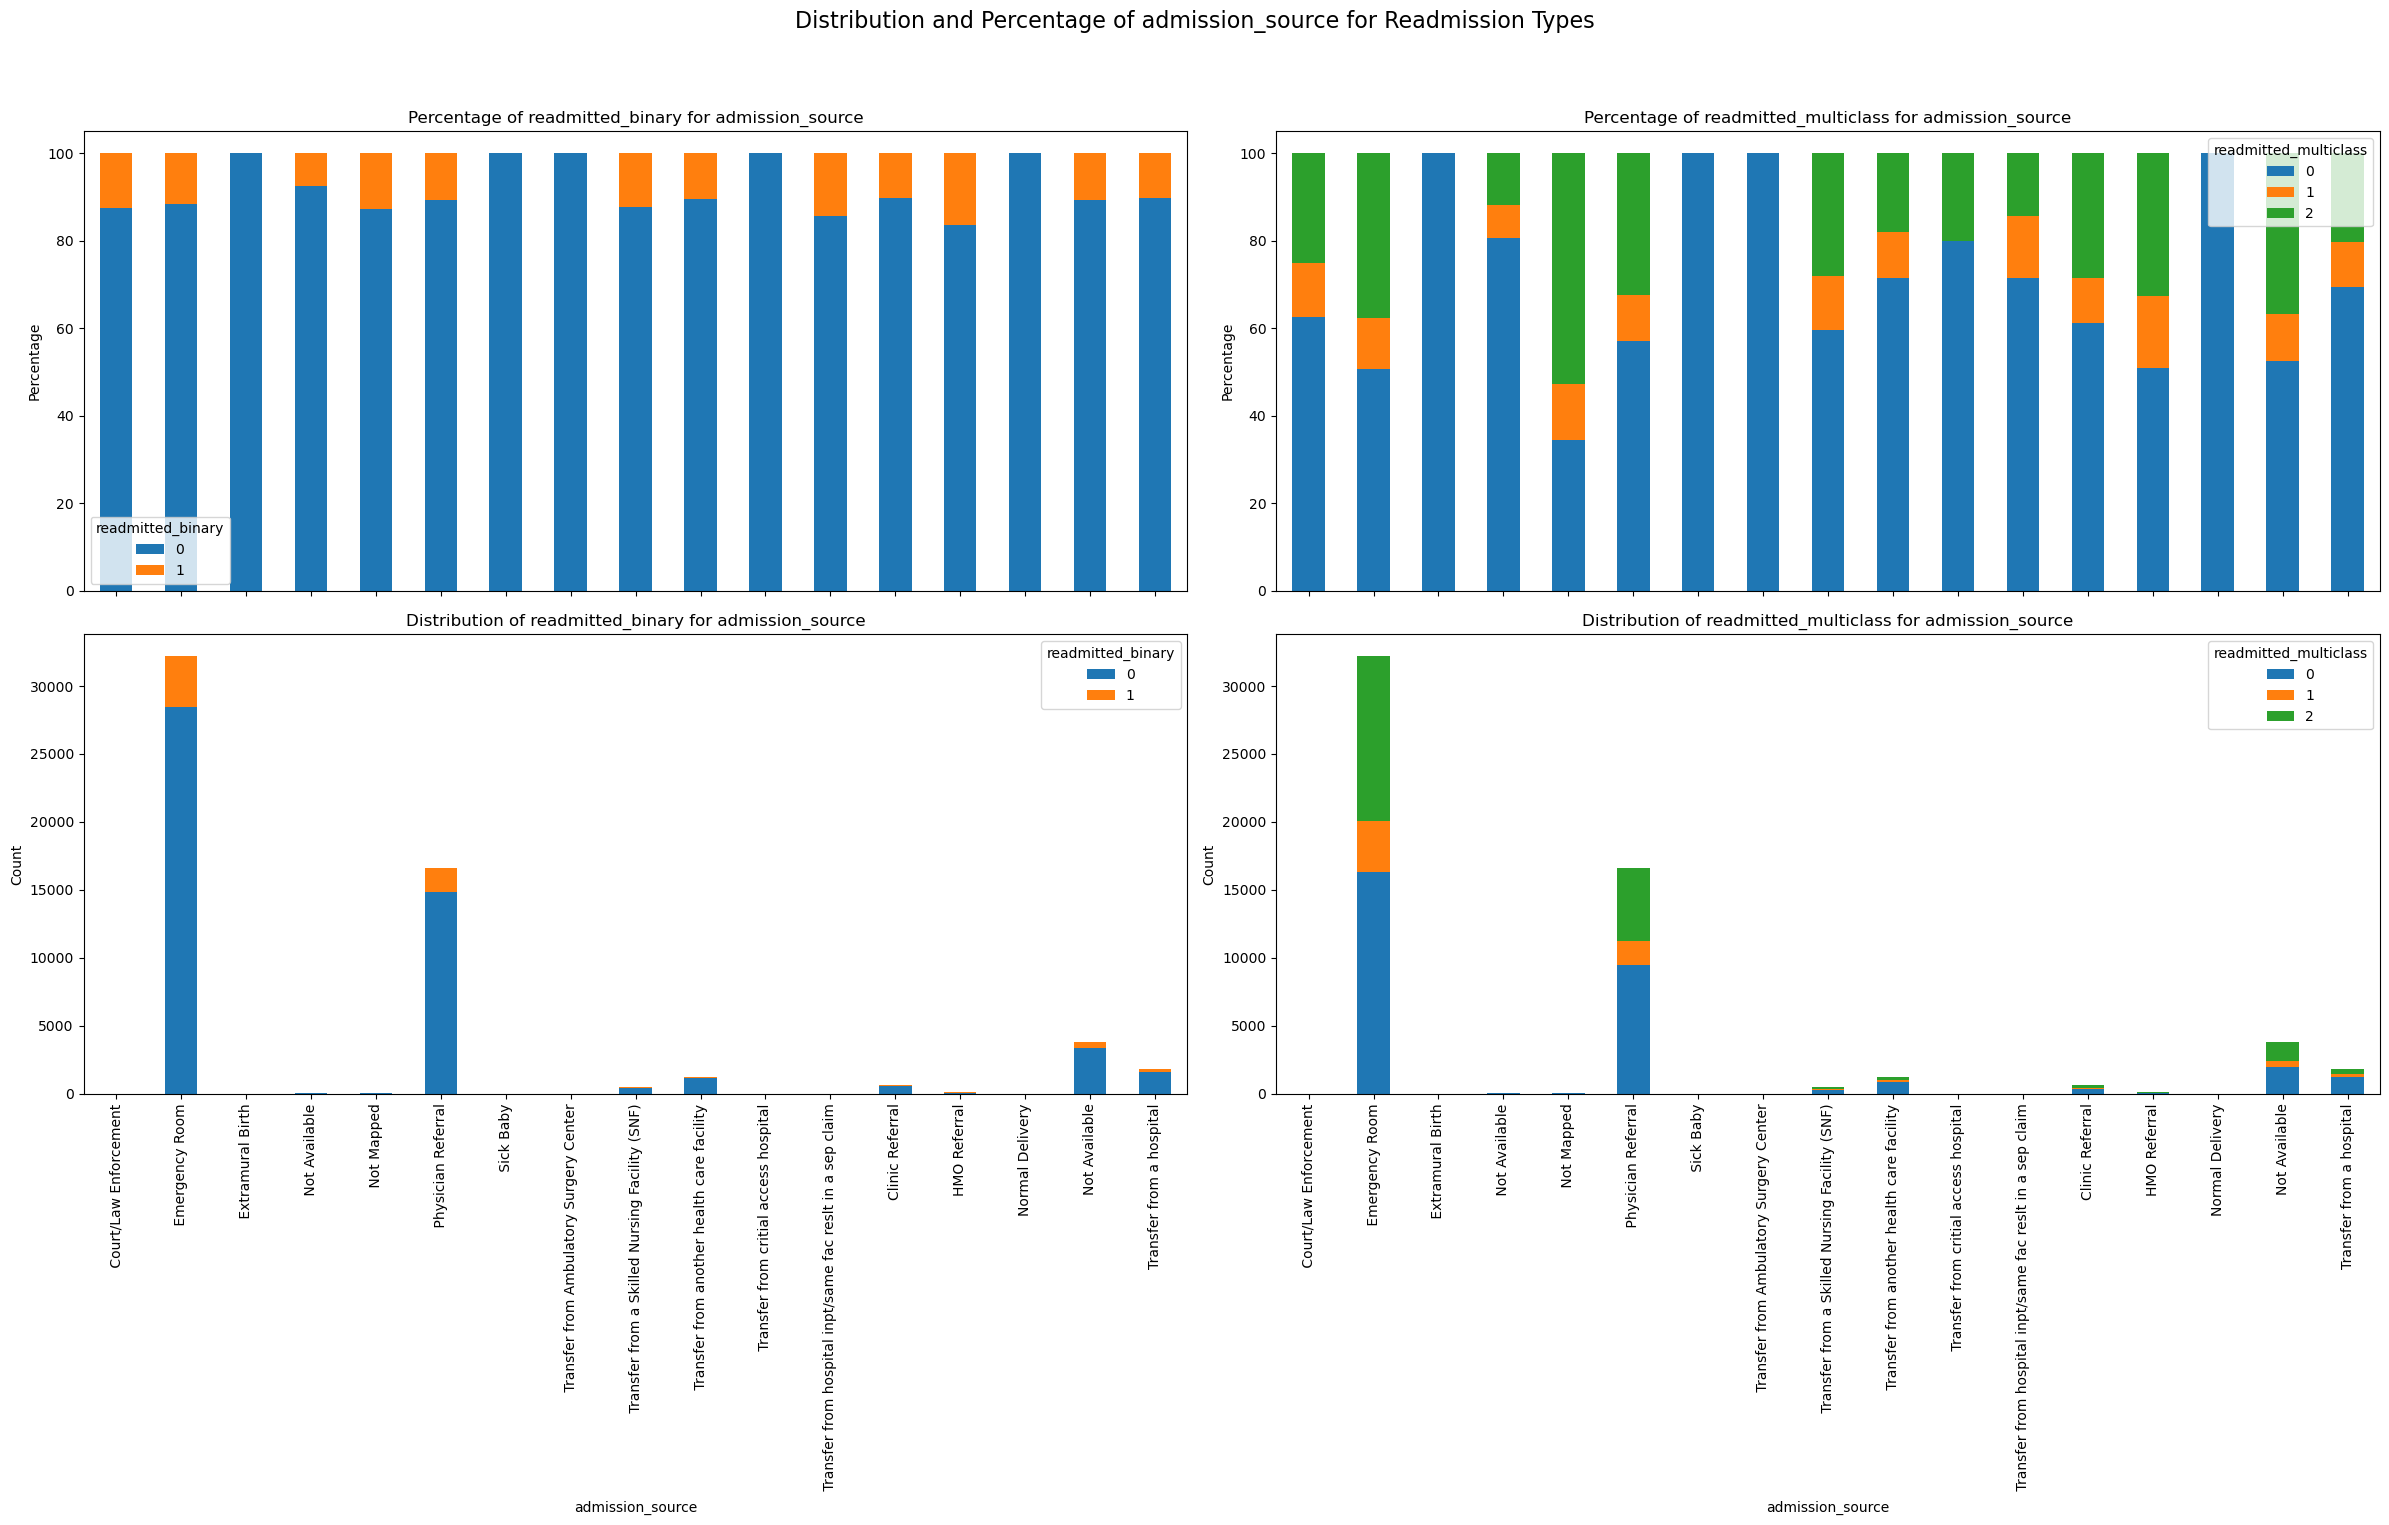

In [1549]:
plot_categorical_distribution(data_train, 'admission_source')

In [1550]:
# combine similar values based on training data
replace_dict = {' Sick Baby': 'Baby Delivery', 'Normal Delivery': 'Baby Delivery', ' Extramural Birth': 'Baby Delivery', ' Transfer from critial access hospital': 'Transfer with no readmission', ' Transfer from Ambulatory Surgery Center': 'Transfer with no readmission'}

data_train['admission_source'].replace(replace_dict, inplace=True)
data_val['admission_source'].replace(replace_dict, inplace=True)
data_test['admission_source'].replace(replace_dict, inplace=True)

#### length_of_stay_in_hospital

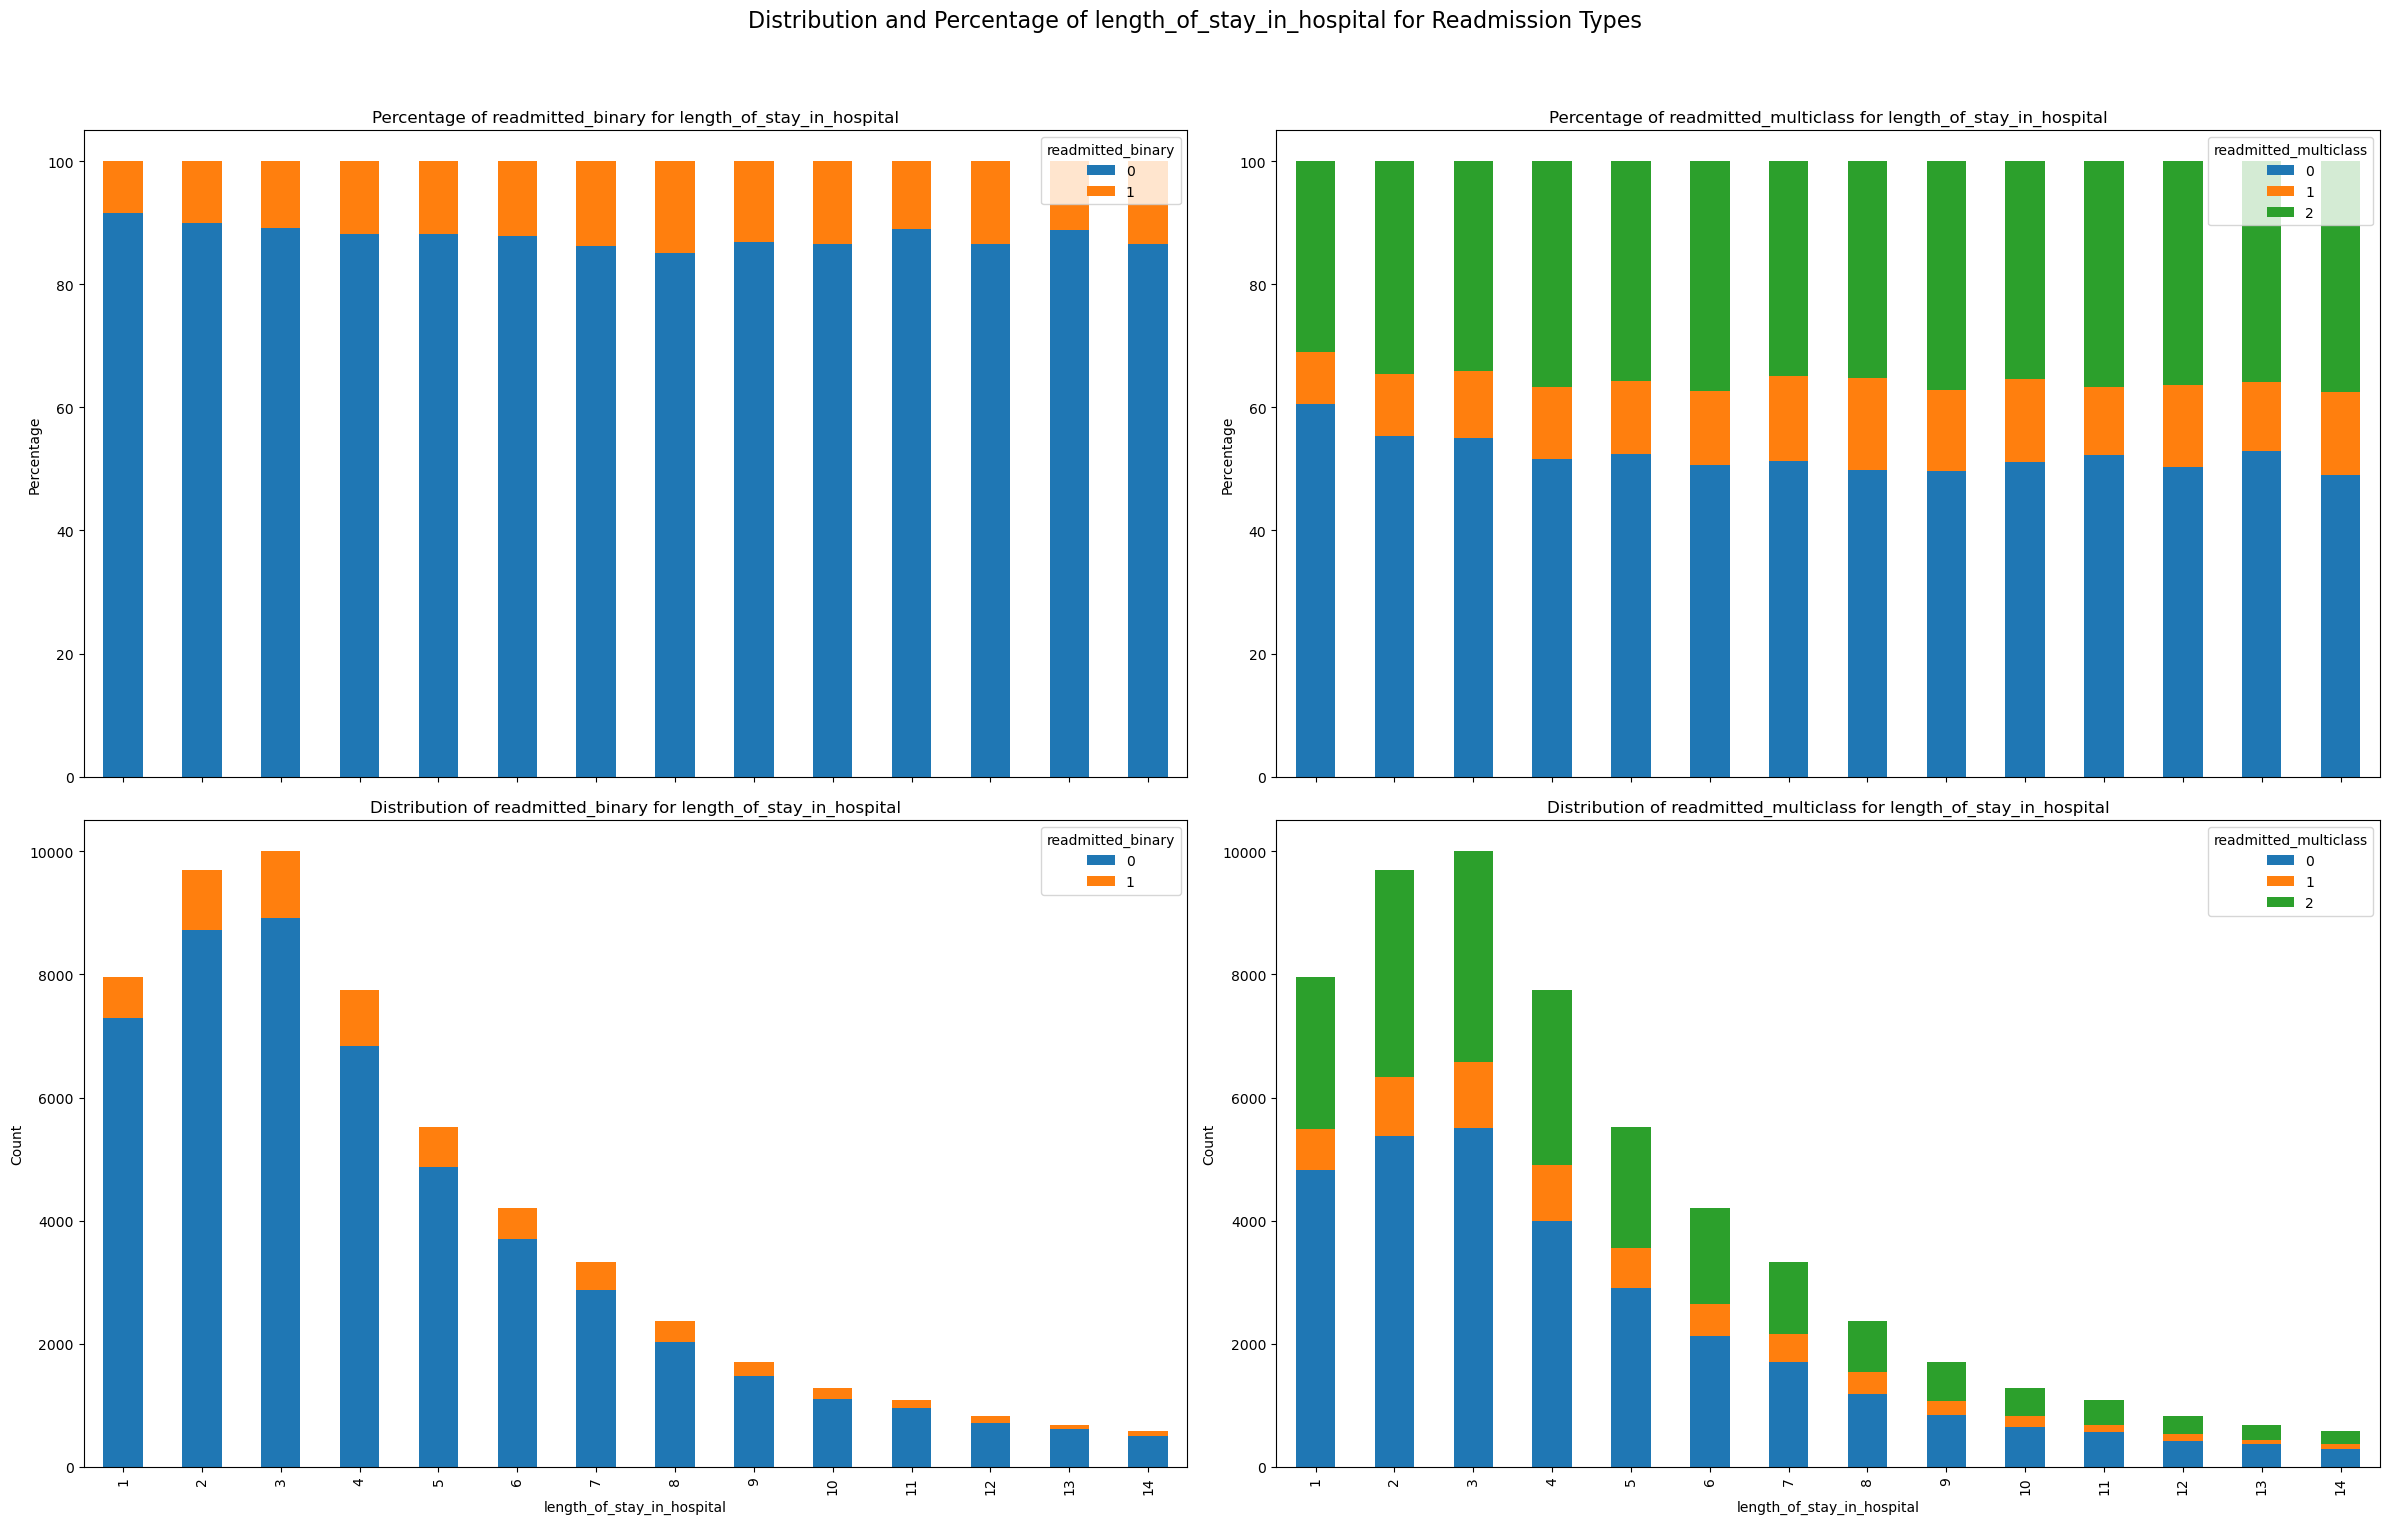

In [1551]:
plot_categorical_distribution(data_train, 'length_of_stay_in_hospital')

In [1552]:
# show 99th percentile
data_train['length_of_stay_in_hospital'].quantile(0.99)

# therefore we keep as it is

14.0

#### number_lab_tests

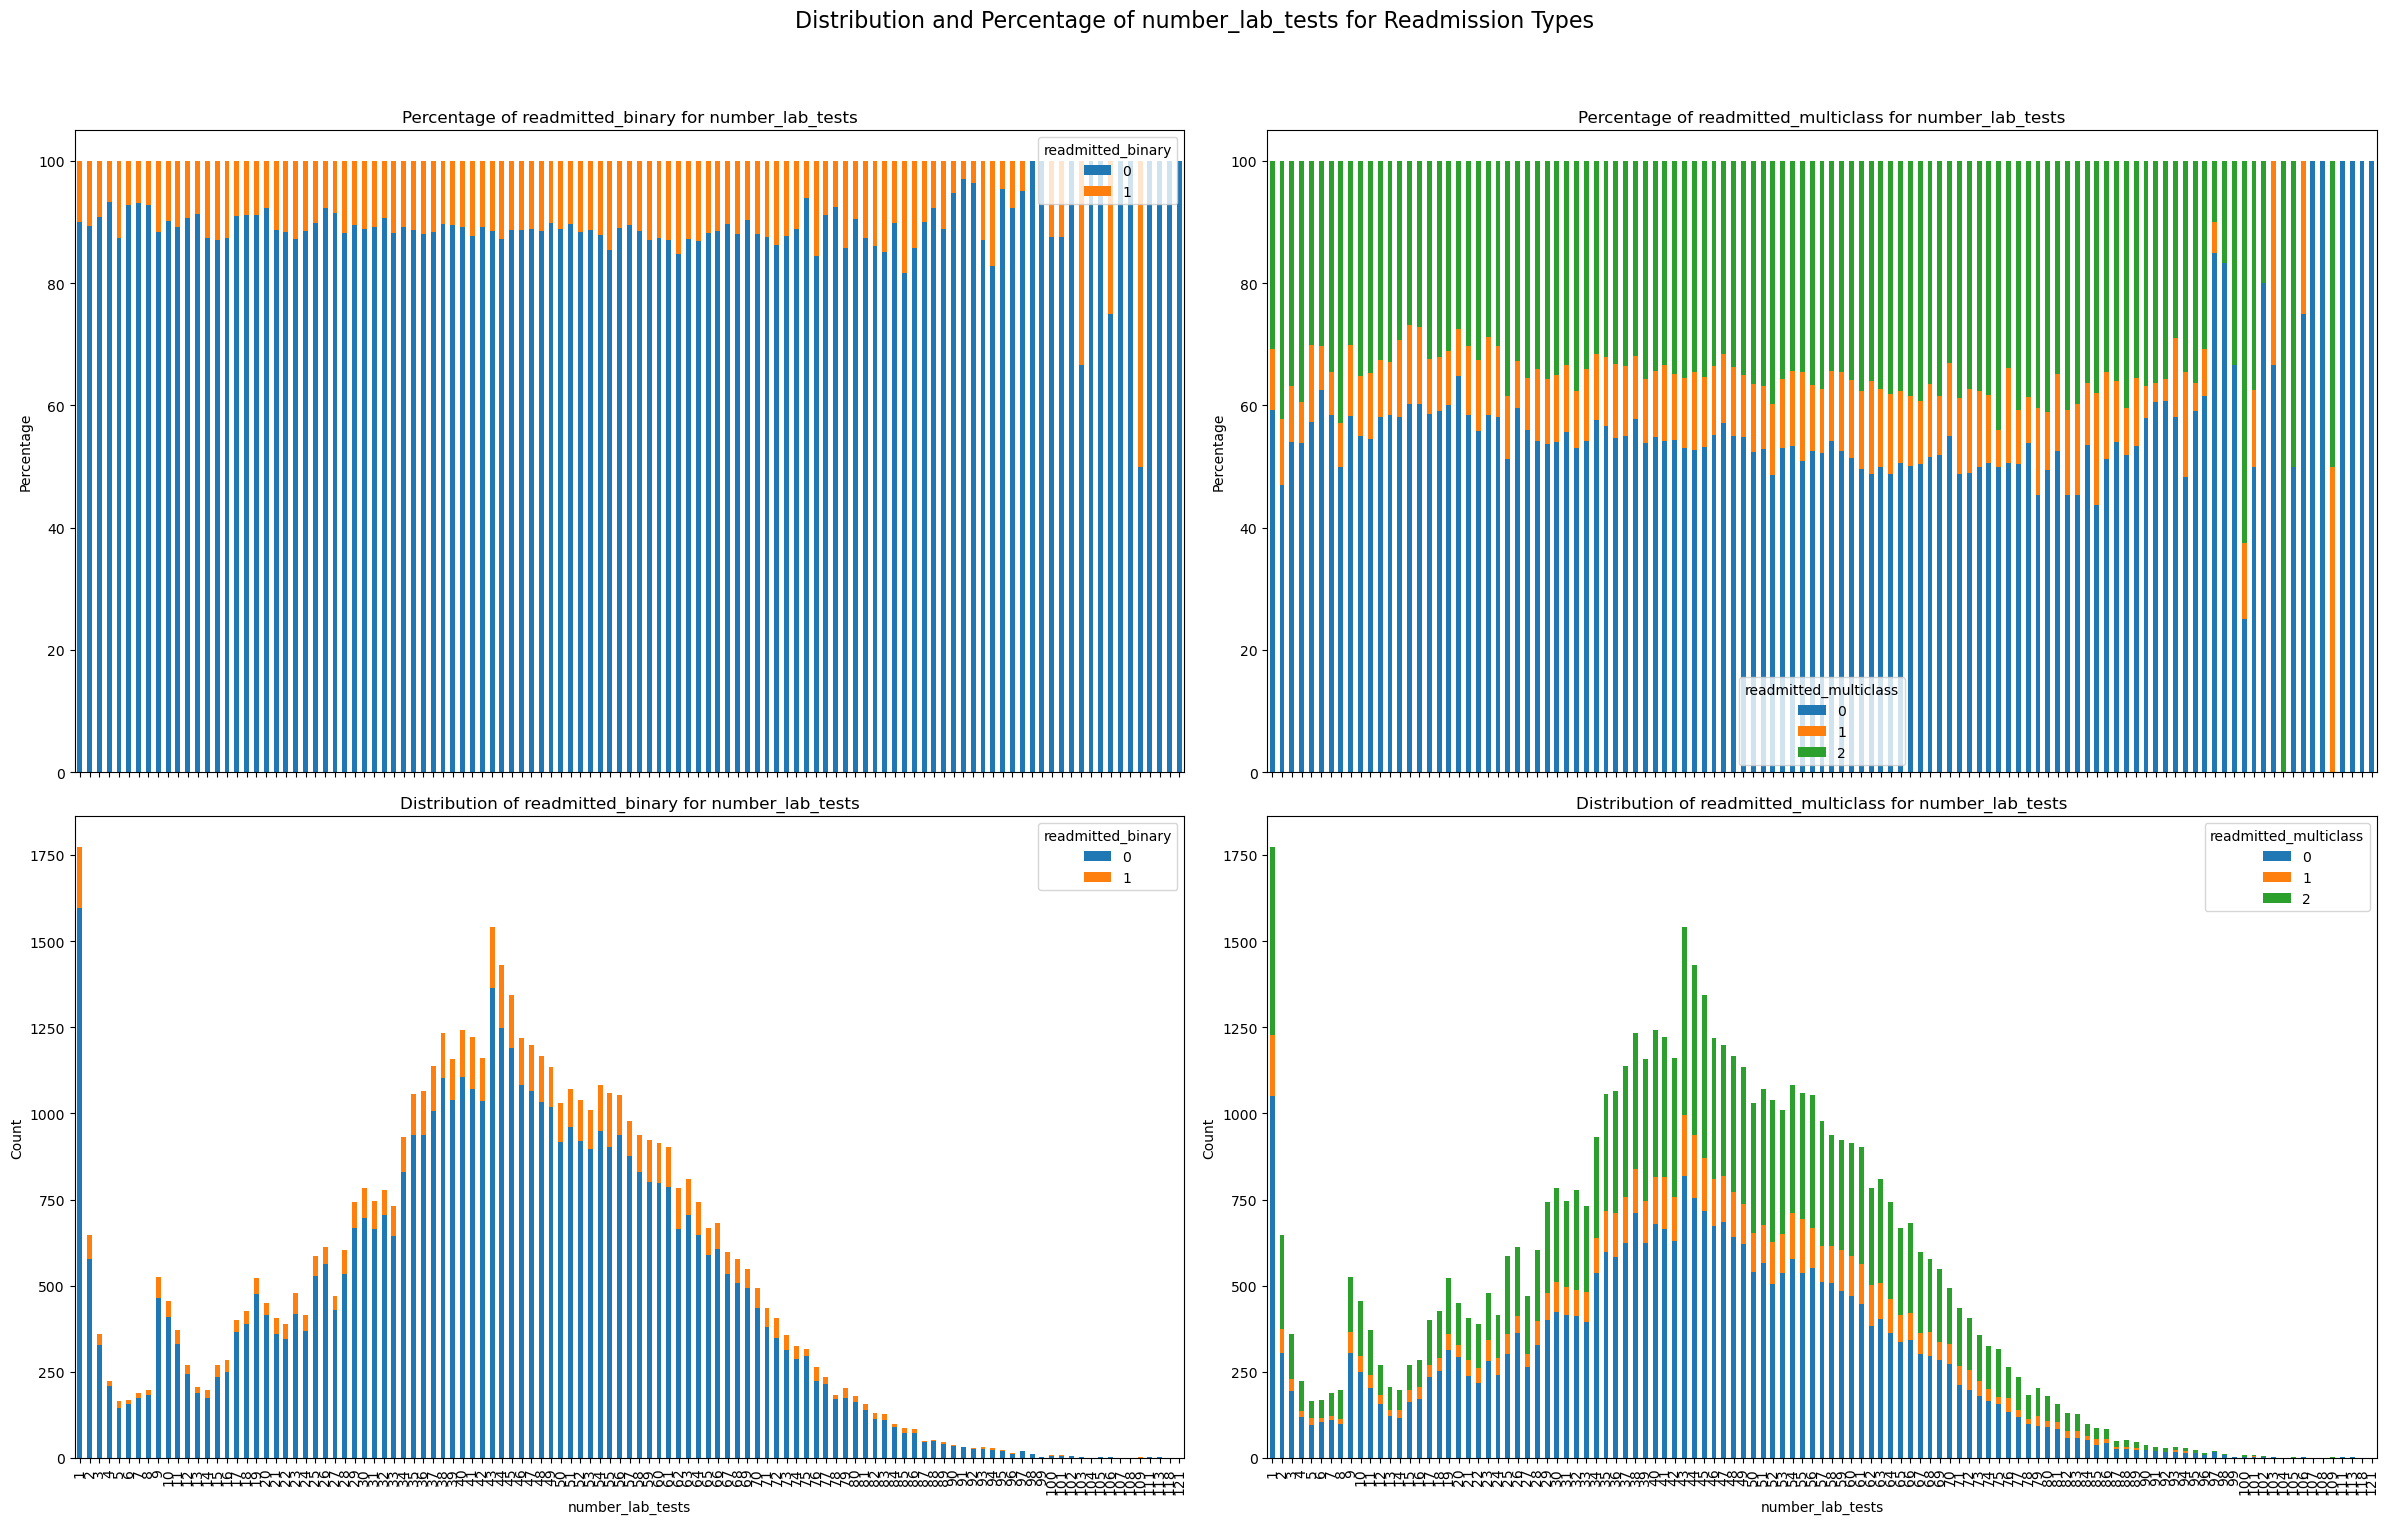

In [1553]:
plot_categorical_distribution(data_train, 'number_lab_tests')

In [1554]:
# clip outliers as before
cap_lab_tests = cap_outliers(data_train, 'number_lab_tests', 0.99)
data_val['number_lab_tests'] = data_val['number_lab_tests'].clip(upper=cap_lab_tests)
data_test['number_lab_tests'] = data_test['number_lab_tests'].clip(upper=cap_lab_tests)

#### non_lab_procedures

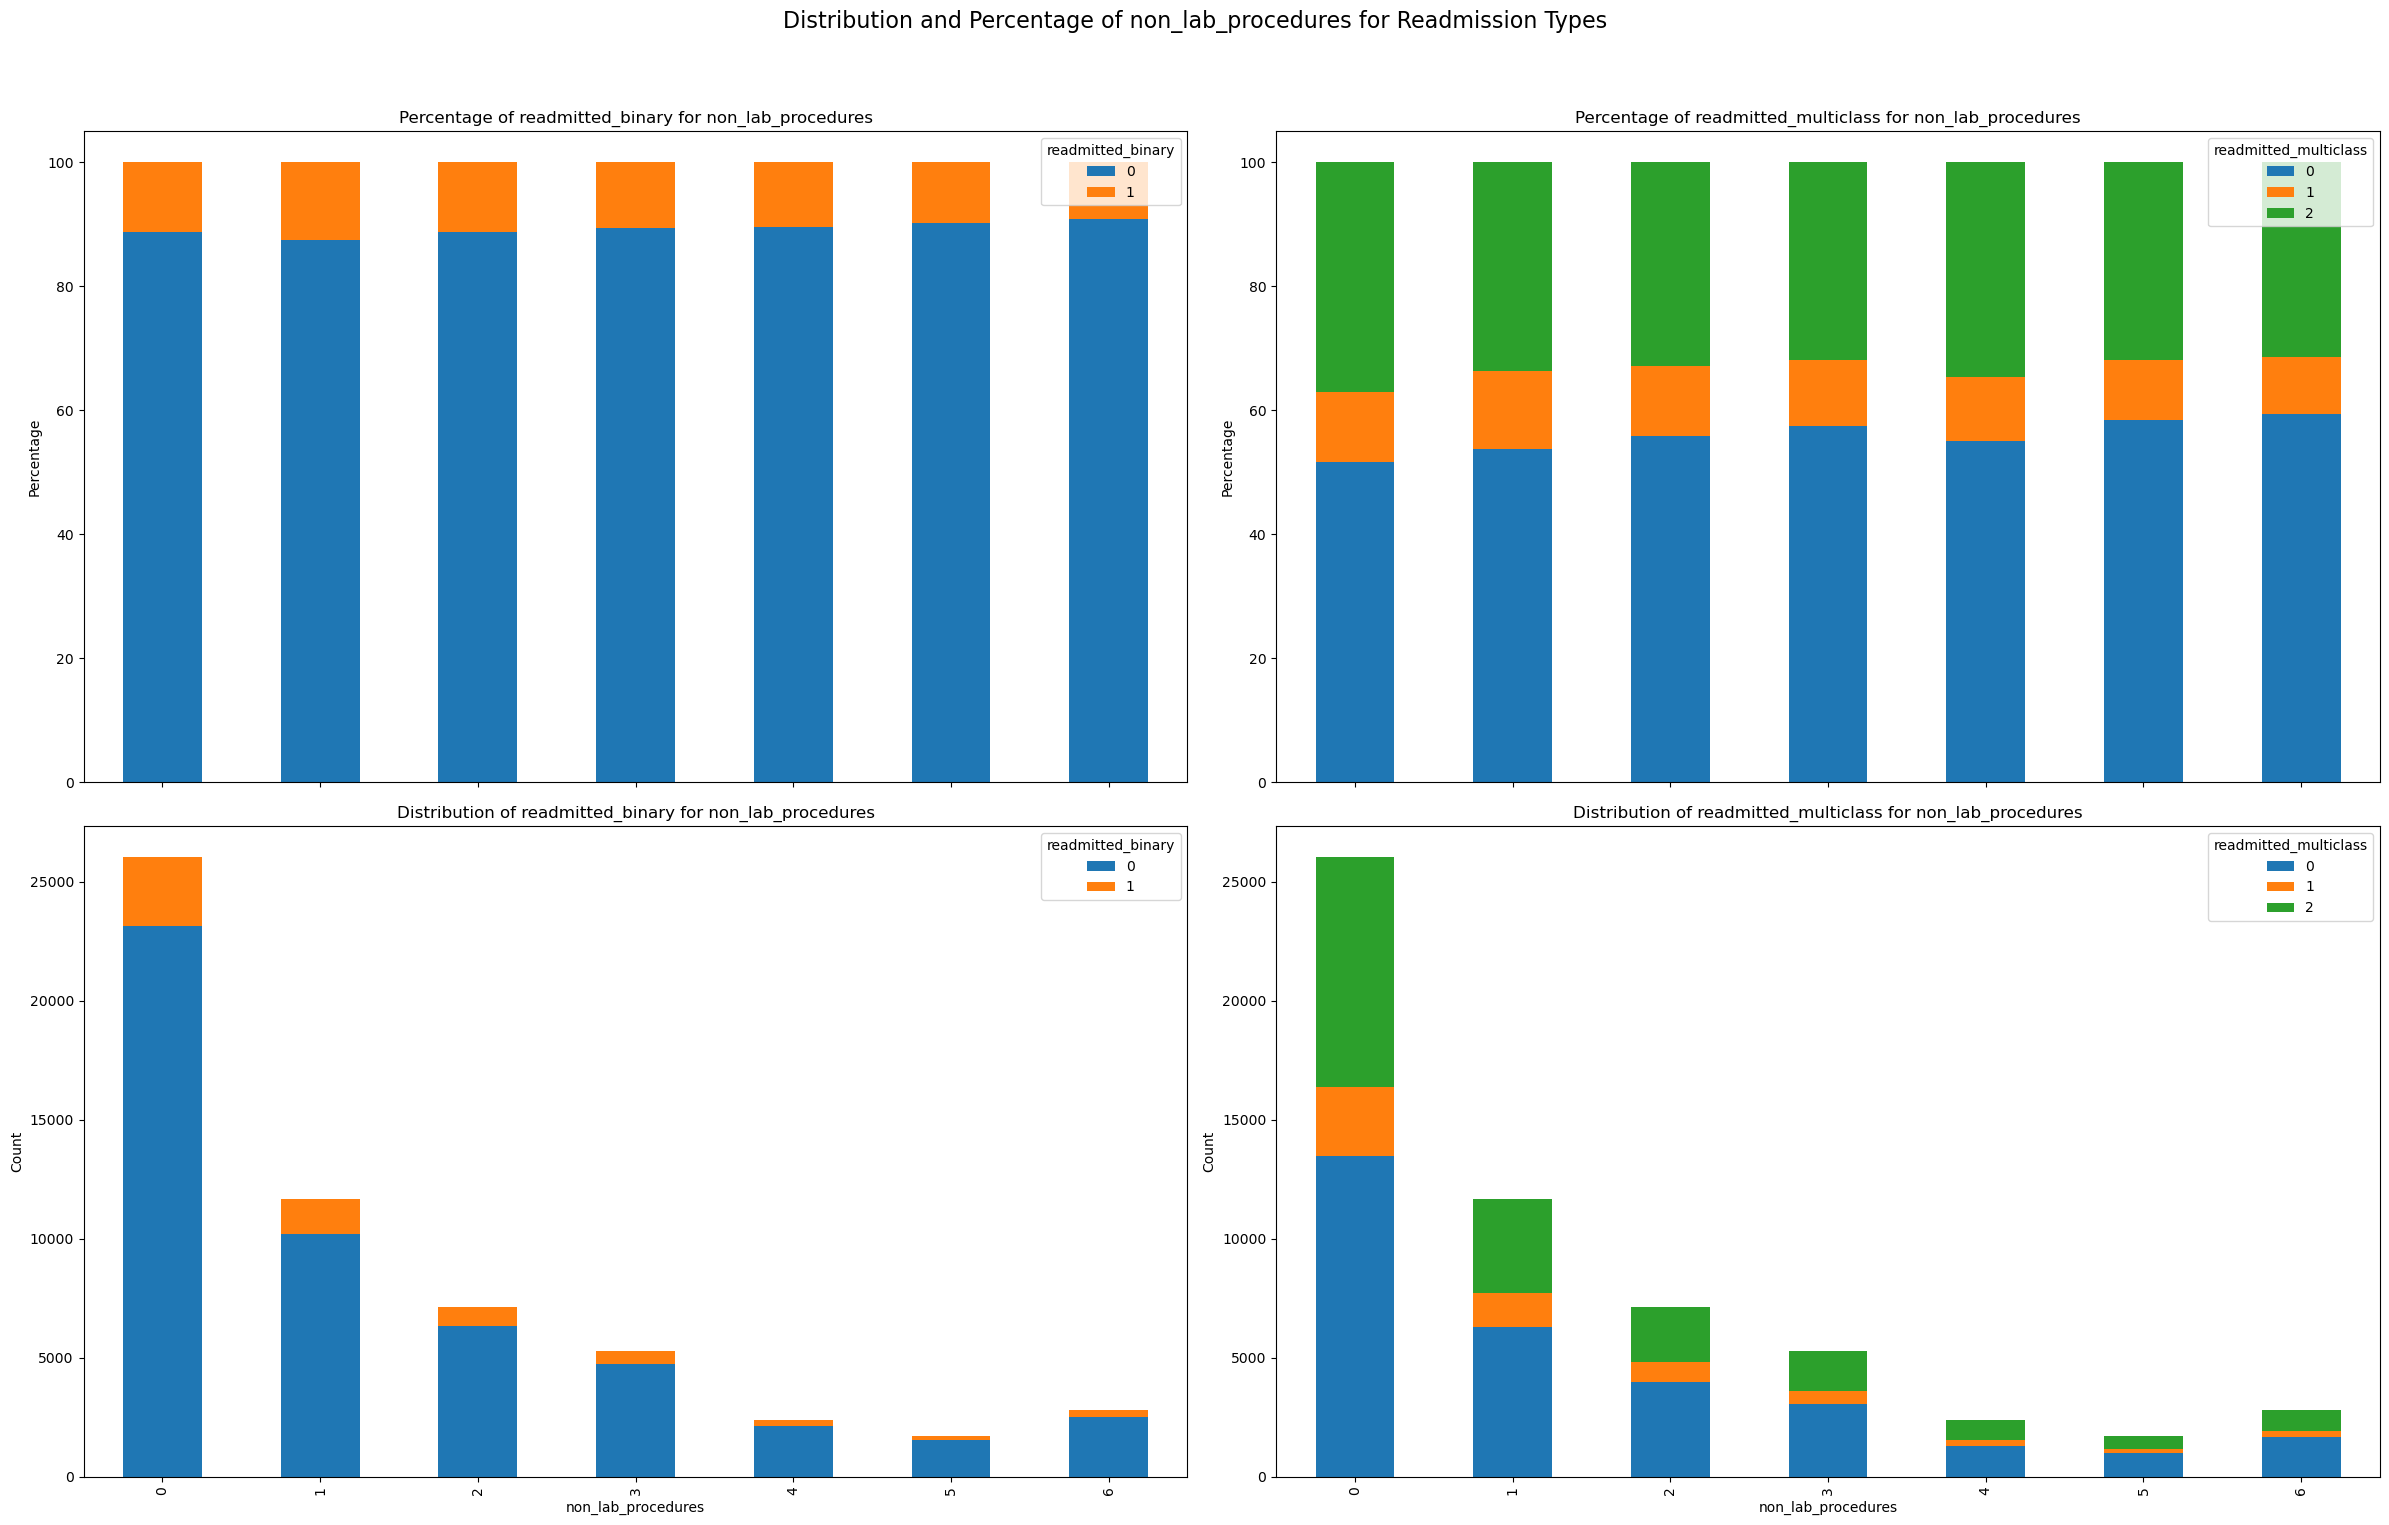

In [1555]:
plot_categorical_distribution(data_train, 'non_lab_procedures')

In [1556]:
# keep as it is for now

#### number_of_medications

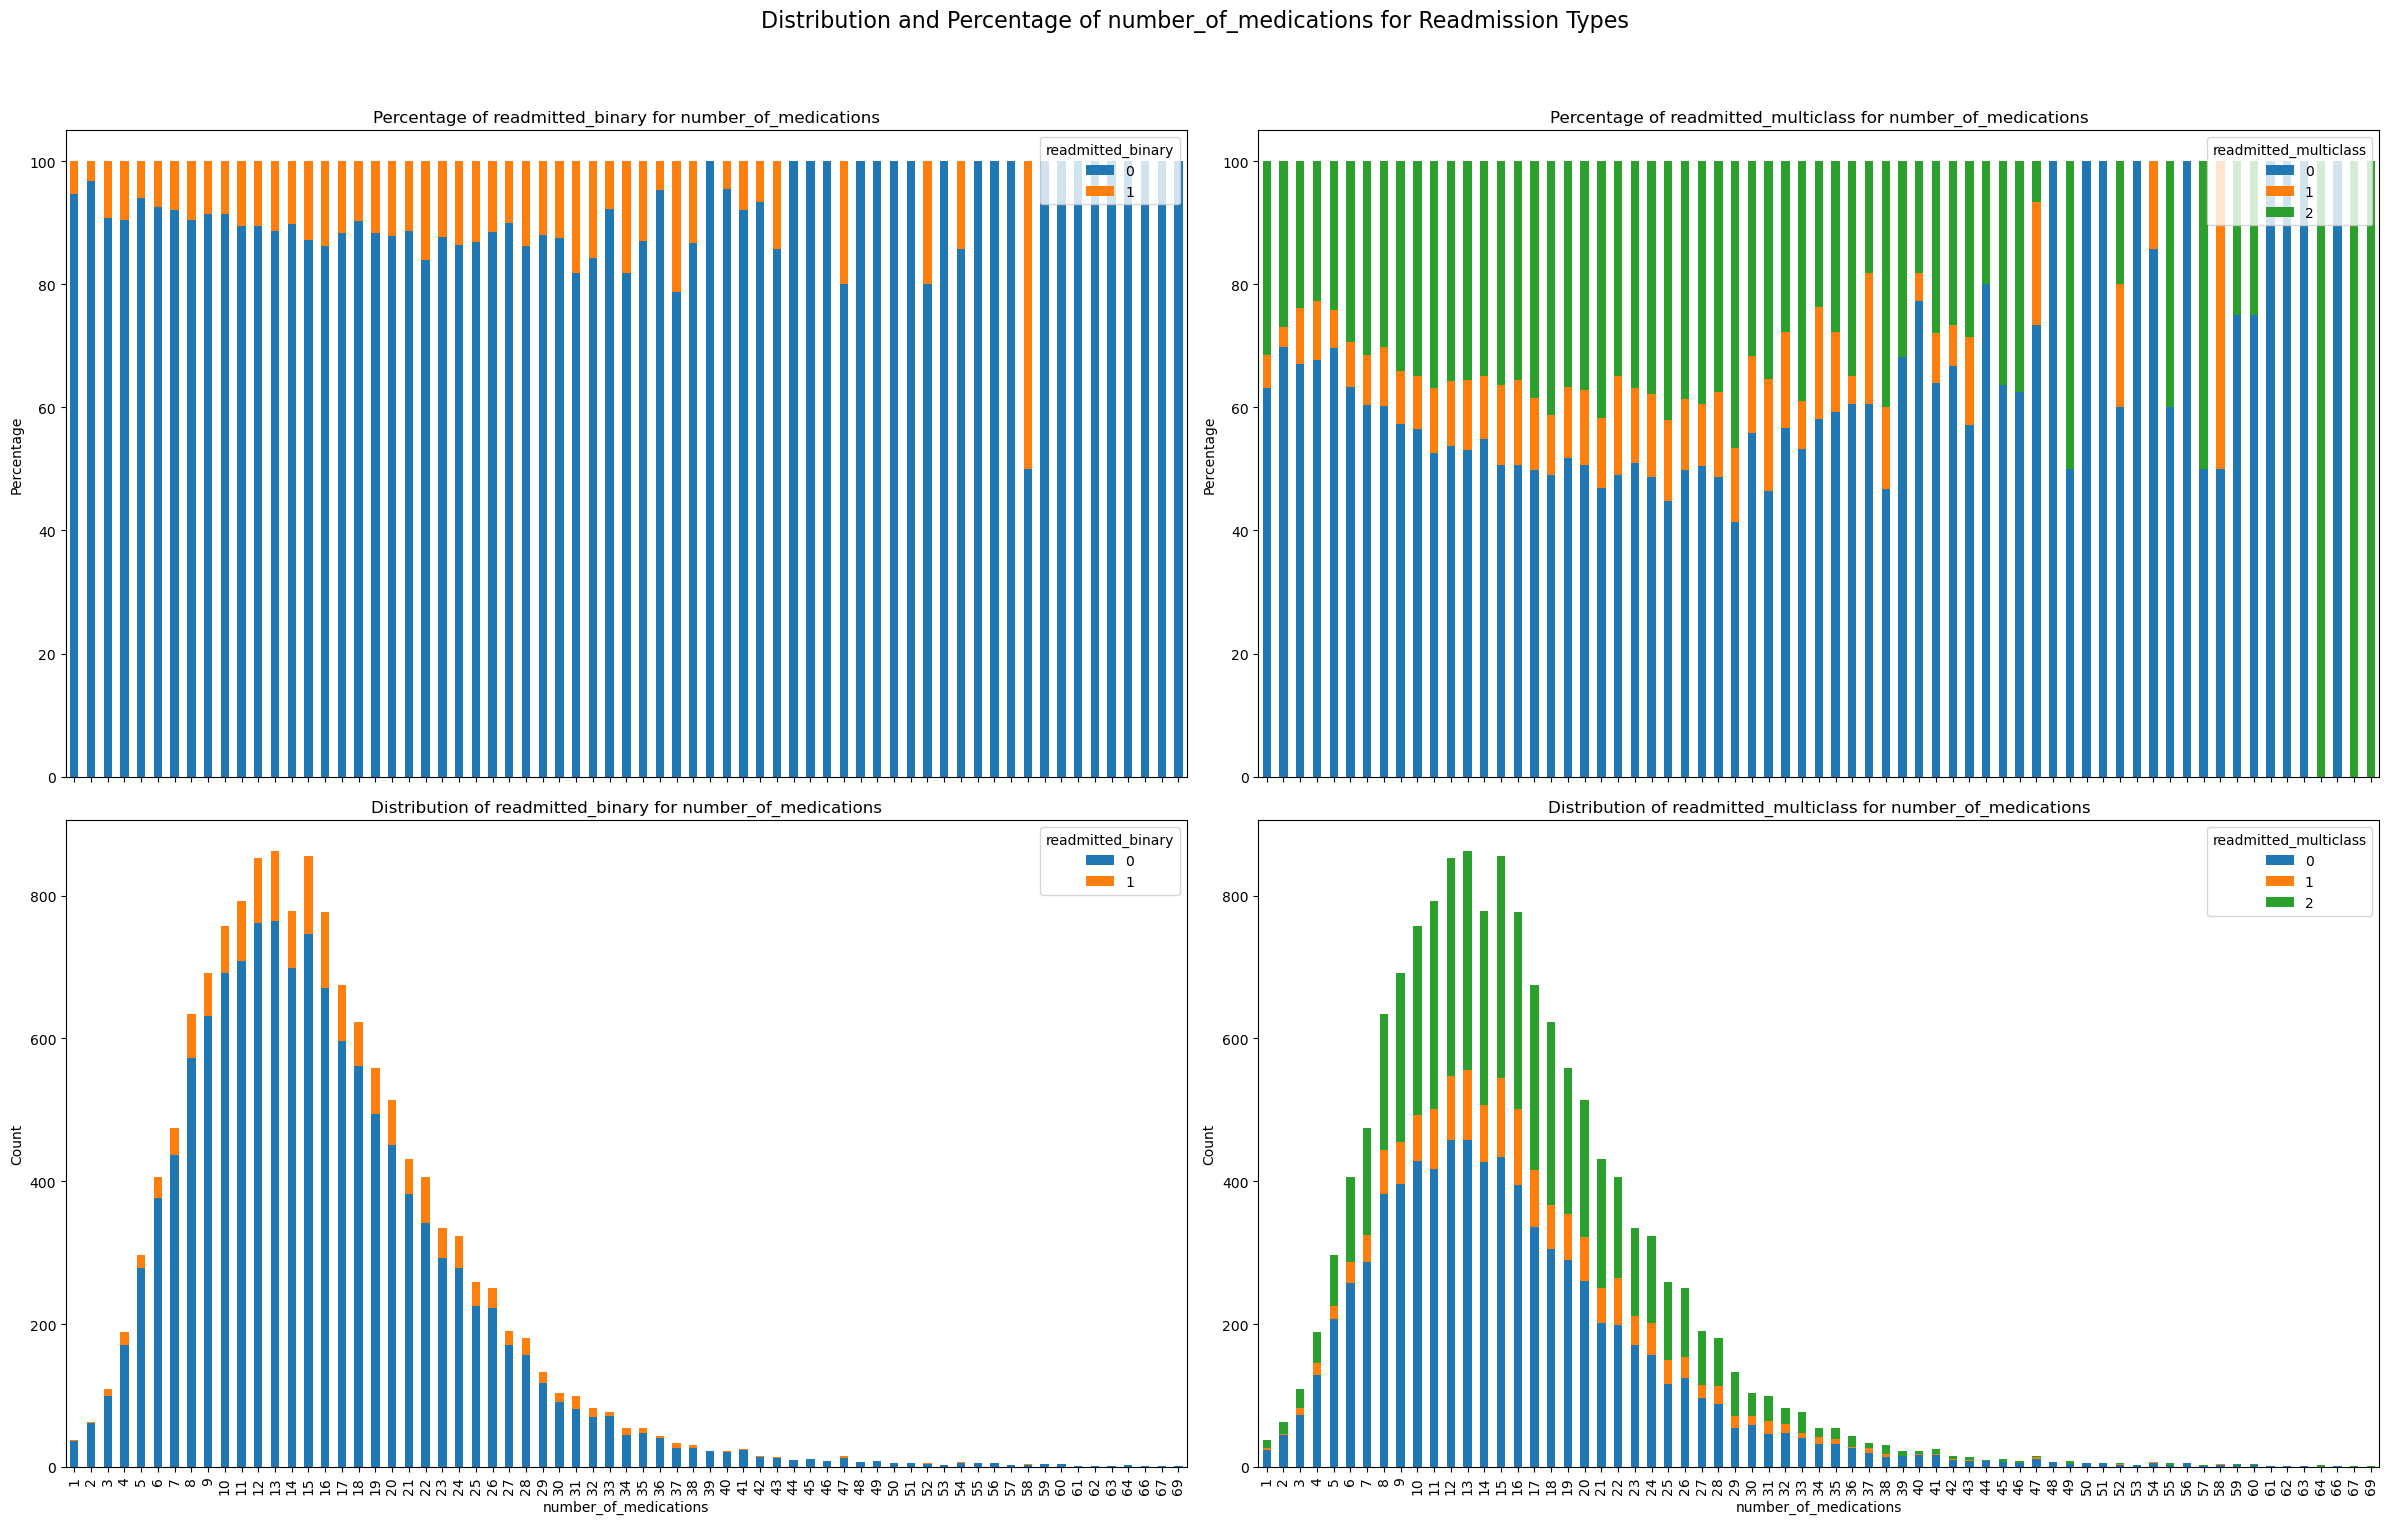

In [1557]:
plot_categorical_distribution(data_val, 'number_of_medications')

In [1558]:
# clip outliers as before
cap_medications = cap_outliers(data_train, 'number_of_medications', 0.99)
data_val['number_of_medications'] = data_val['number_of_medications'].clip(upper=cap_medications)
data_test['number_of_medications'] = data_test['number_of_medications'].clip(upper=cap_medications)

#### primary_diagnosis, secondary_diagnosis, additional_diagnosis

In [1559]:
# Mapping function
def map_icd9_code(code):
    code_str = str(code)  # Convert code to string

    try:
        code_int = int(float(code_str))  # Convert to integer if possible
    except ValueError:
        code_int = None  # Keep the code as None if it's not a number

    if code_int is not None:
        if 1 <= code_int <= 139:
            return 'Infectious and Parasitic Diseases'
        elif 140 <= code_int <= 239:
            return 'Neoplasms'
        elif 240 <= code_int <= 279:
            return 'Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders'
        elif 280 <= code_int <= 289:
            return 'Diseases of the Blood and Blood-forming Organs'
        elif 290 <= code_int <= 319:
            return 'Mental Disorders'
        elif 320 <= code_int <= 389:
            return 'Diseases of the Nervous System and Sense Organs'
        elif 390 <= code_int <= 459:
            return 'Diseases of the Circulatory System'
        elif 460 <= code_int <= 519:
            return 'Diseases of the Respiratory System'
        elif 520 <= code_int <= 579:
            return 'Diseases of the Digestive System'
        elif 580 <= code_int <= 629:
            return 'Diseases of the Genitourinary System'
        elif 630 <= code_int <= 679:
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif 680 <= code_int <= 709:
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif 710 <= code_int <= 739:
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif 740 <= code_int <= 759:
            return 'Congenital Anomalies'
        elif 760 <= code_int <= 779:
            return 'Certain Conditions Originating in the Perinatal Period'
        elif 780 <= code_int <= 799:
            return 'Symptoms, Signs, and Ill-Defined Conditions'
        elif 800 <= code_int <= 999:
            return 'Injury and Poisoning'
    else:
        if code_str.startswith('E') or code_str.startswith('V'):
            return 'external causes of injury and supplemental classification'
        # Handle other alphanumeric codes if necessary

    return 'Unknown Category'  # Default category for anything else

In [1560]:
data_train['primary_diagnosis'] = data_train['primary_diagnosis'].apply(map_icd9_code)
data_val['primary_diagnosis'] = data_val['primary_diagnosis'].apply(map_icd9_code)
data_test['primary_diagnosis'] = data_test['primary_diagnosis'].apply(map_icd9_code)

In [1561]:
data_train['secondary_diagnosis'] = data_train['secondary_diagnosis'].apply(map_icd9_code)
data_val['secondary_diagnosis'] = data_val['secondary_diagnosis'].apply(map_icd9_code)
data_test['secondary_diagnosis'] = data_test['secondary_diagnosis'].apply(map_icd9_code)

In [1562]:
data_train['additional_diagnosis'] = data_train['additional_diagnosis'].apply(map_icd9_code)
data_val['additional_diagnosis'] = data_val['additional_diagnosis'].apply(map_icd9_code)
data_test['additional_diagnosis'] = data_test['additional_diagnosis'].apply(map_icd9_code)

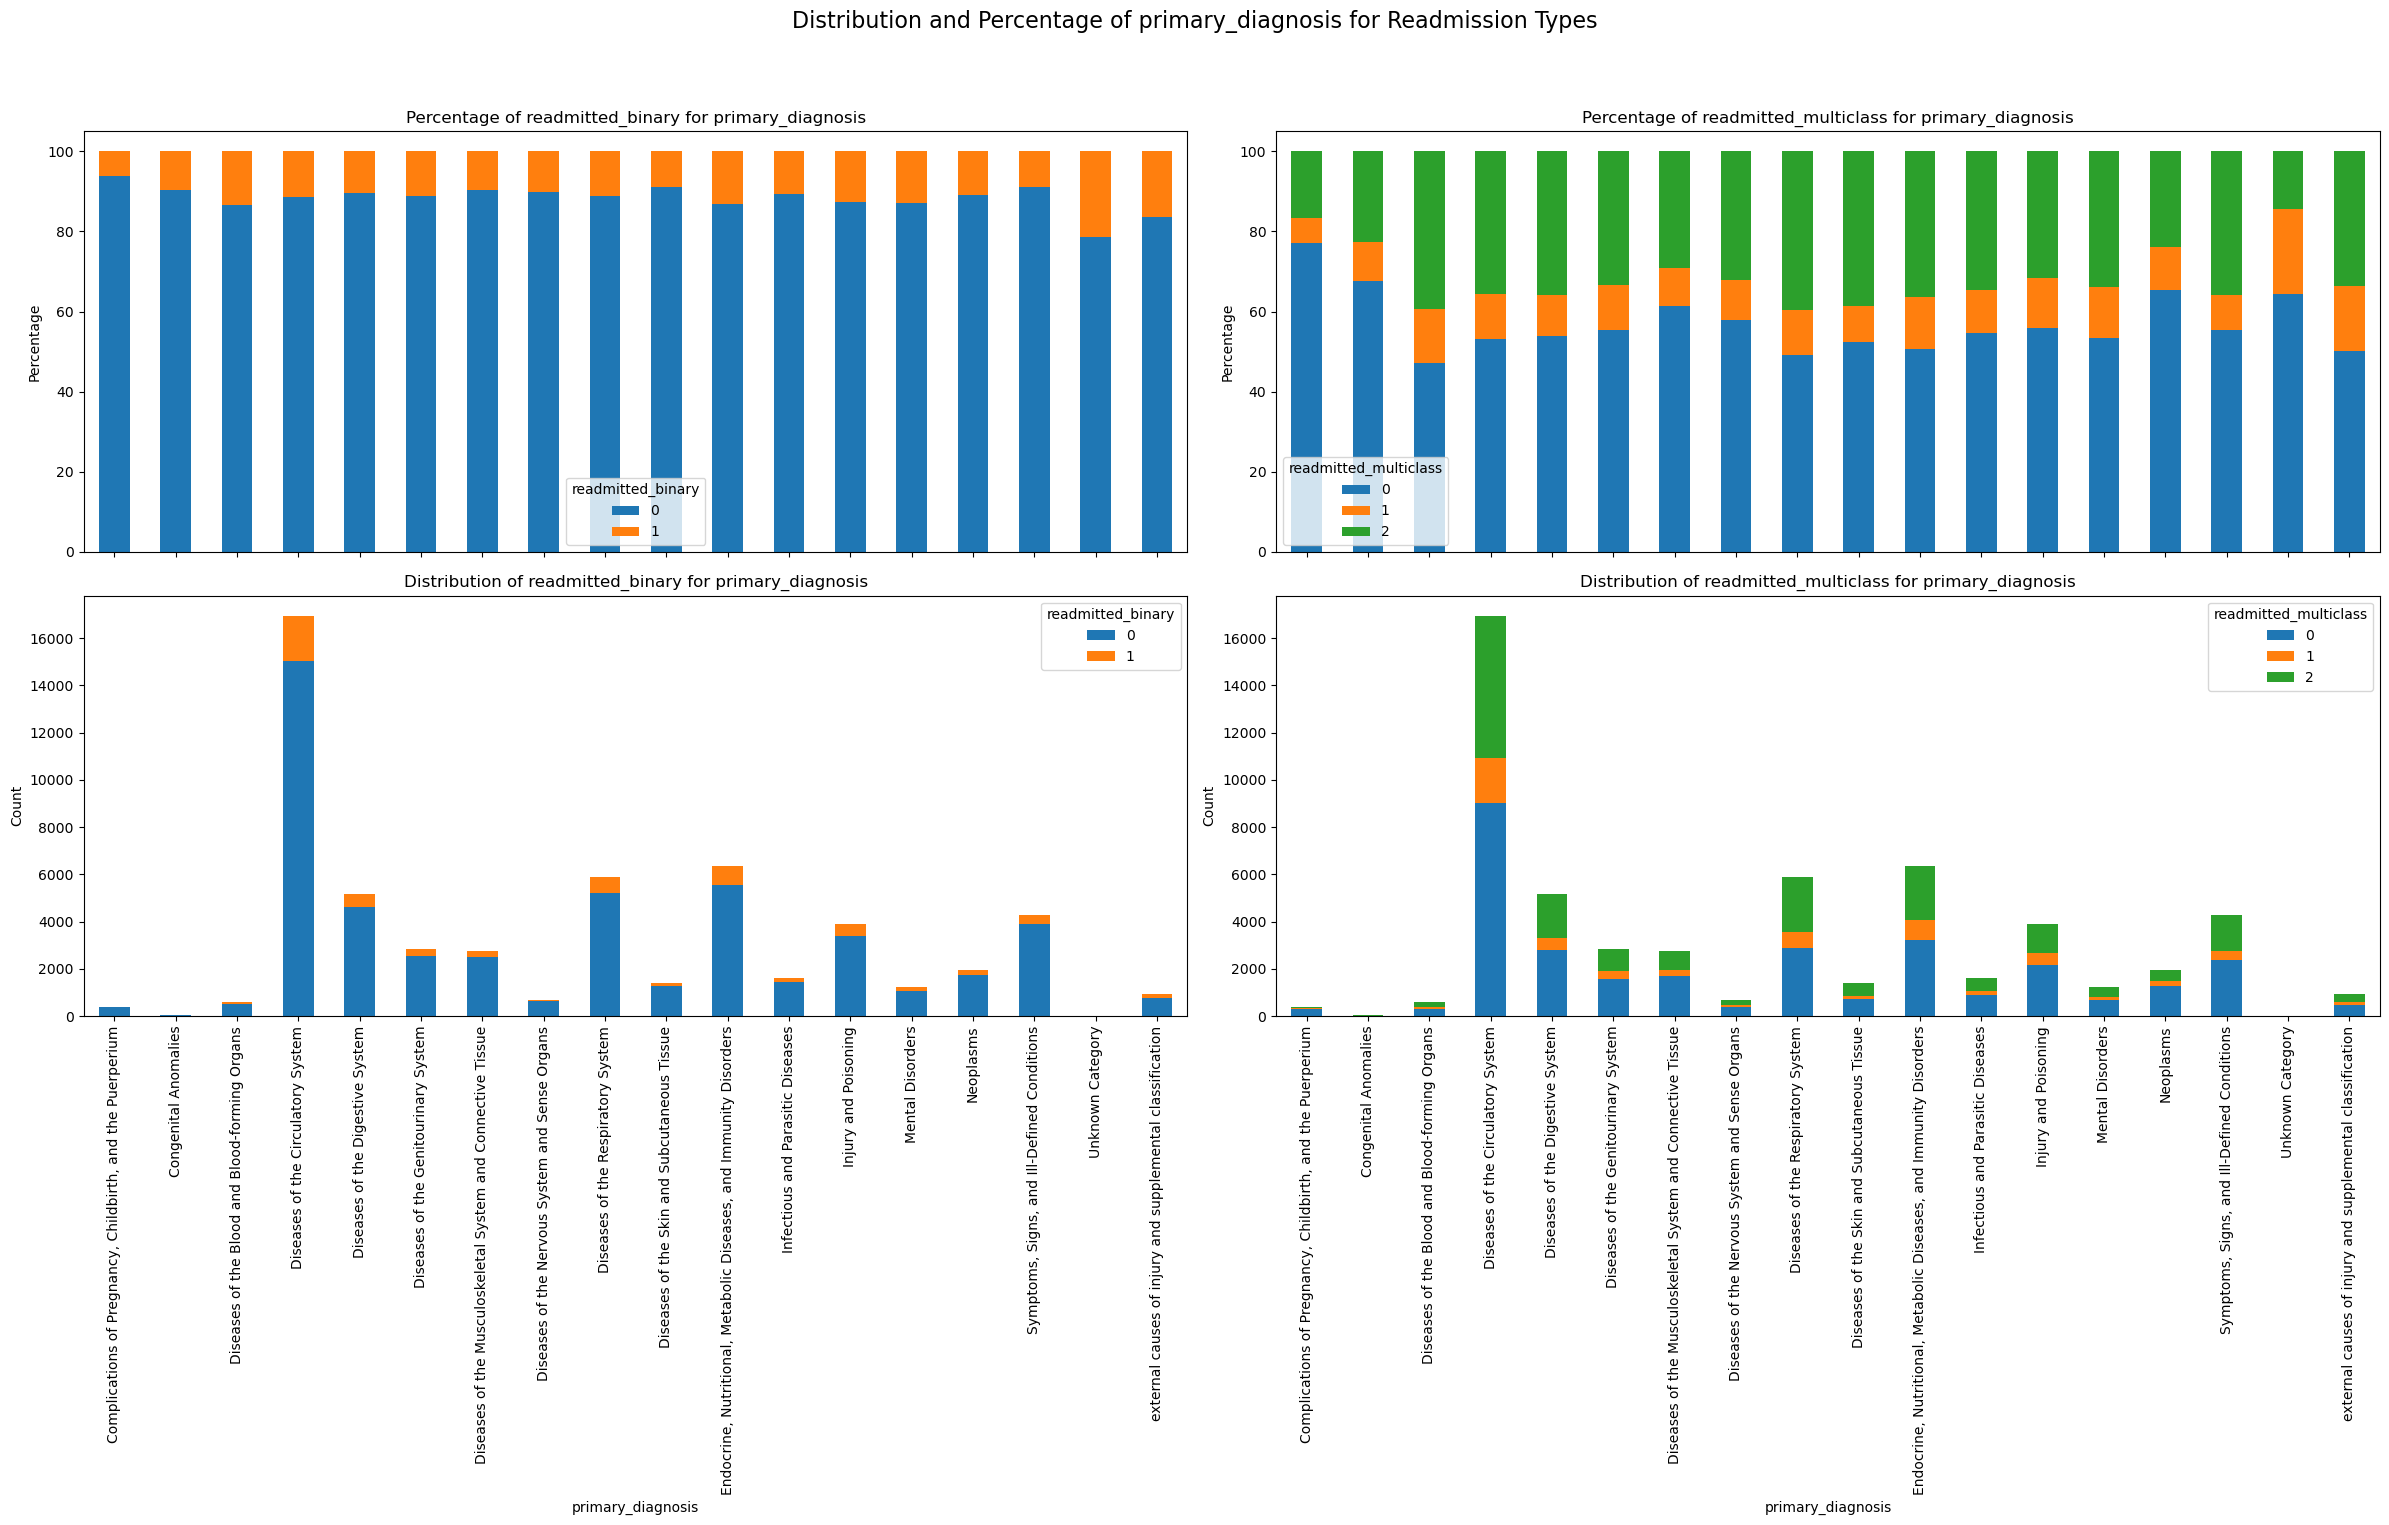

In [1563]:
plot_categorical_distribution(data_train, 'primary_diagnosis')

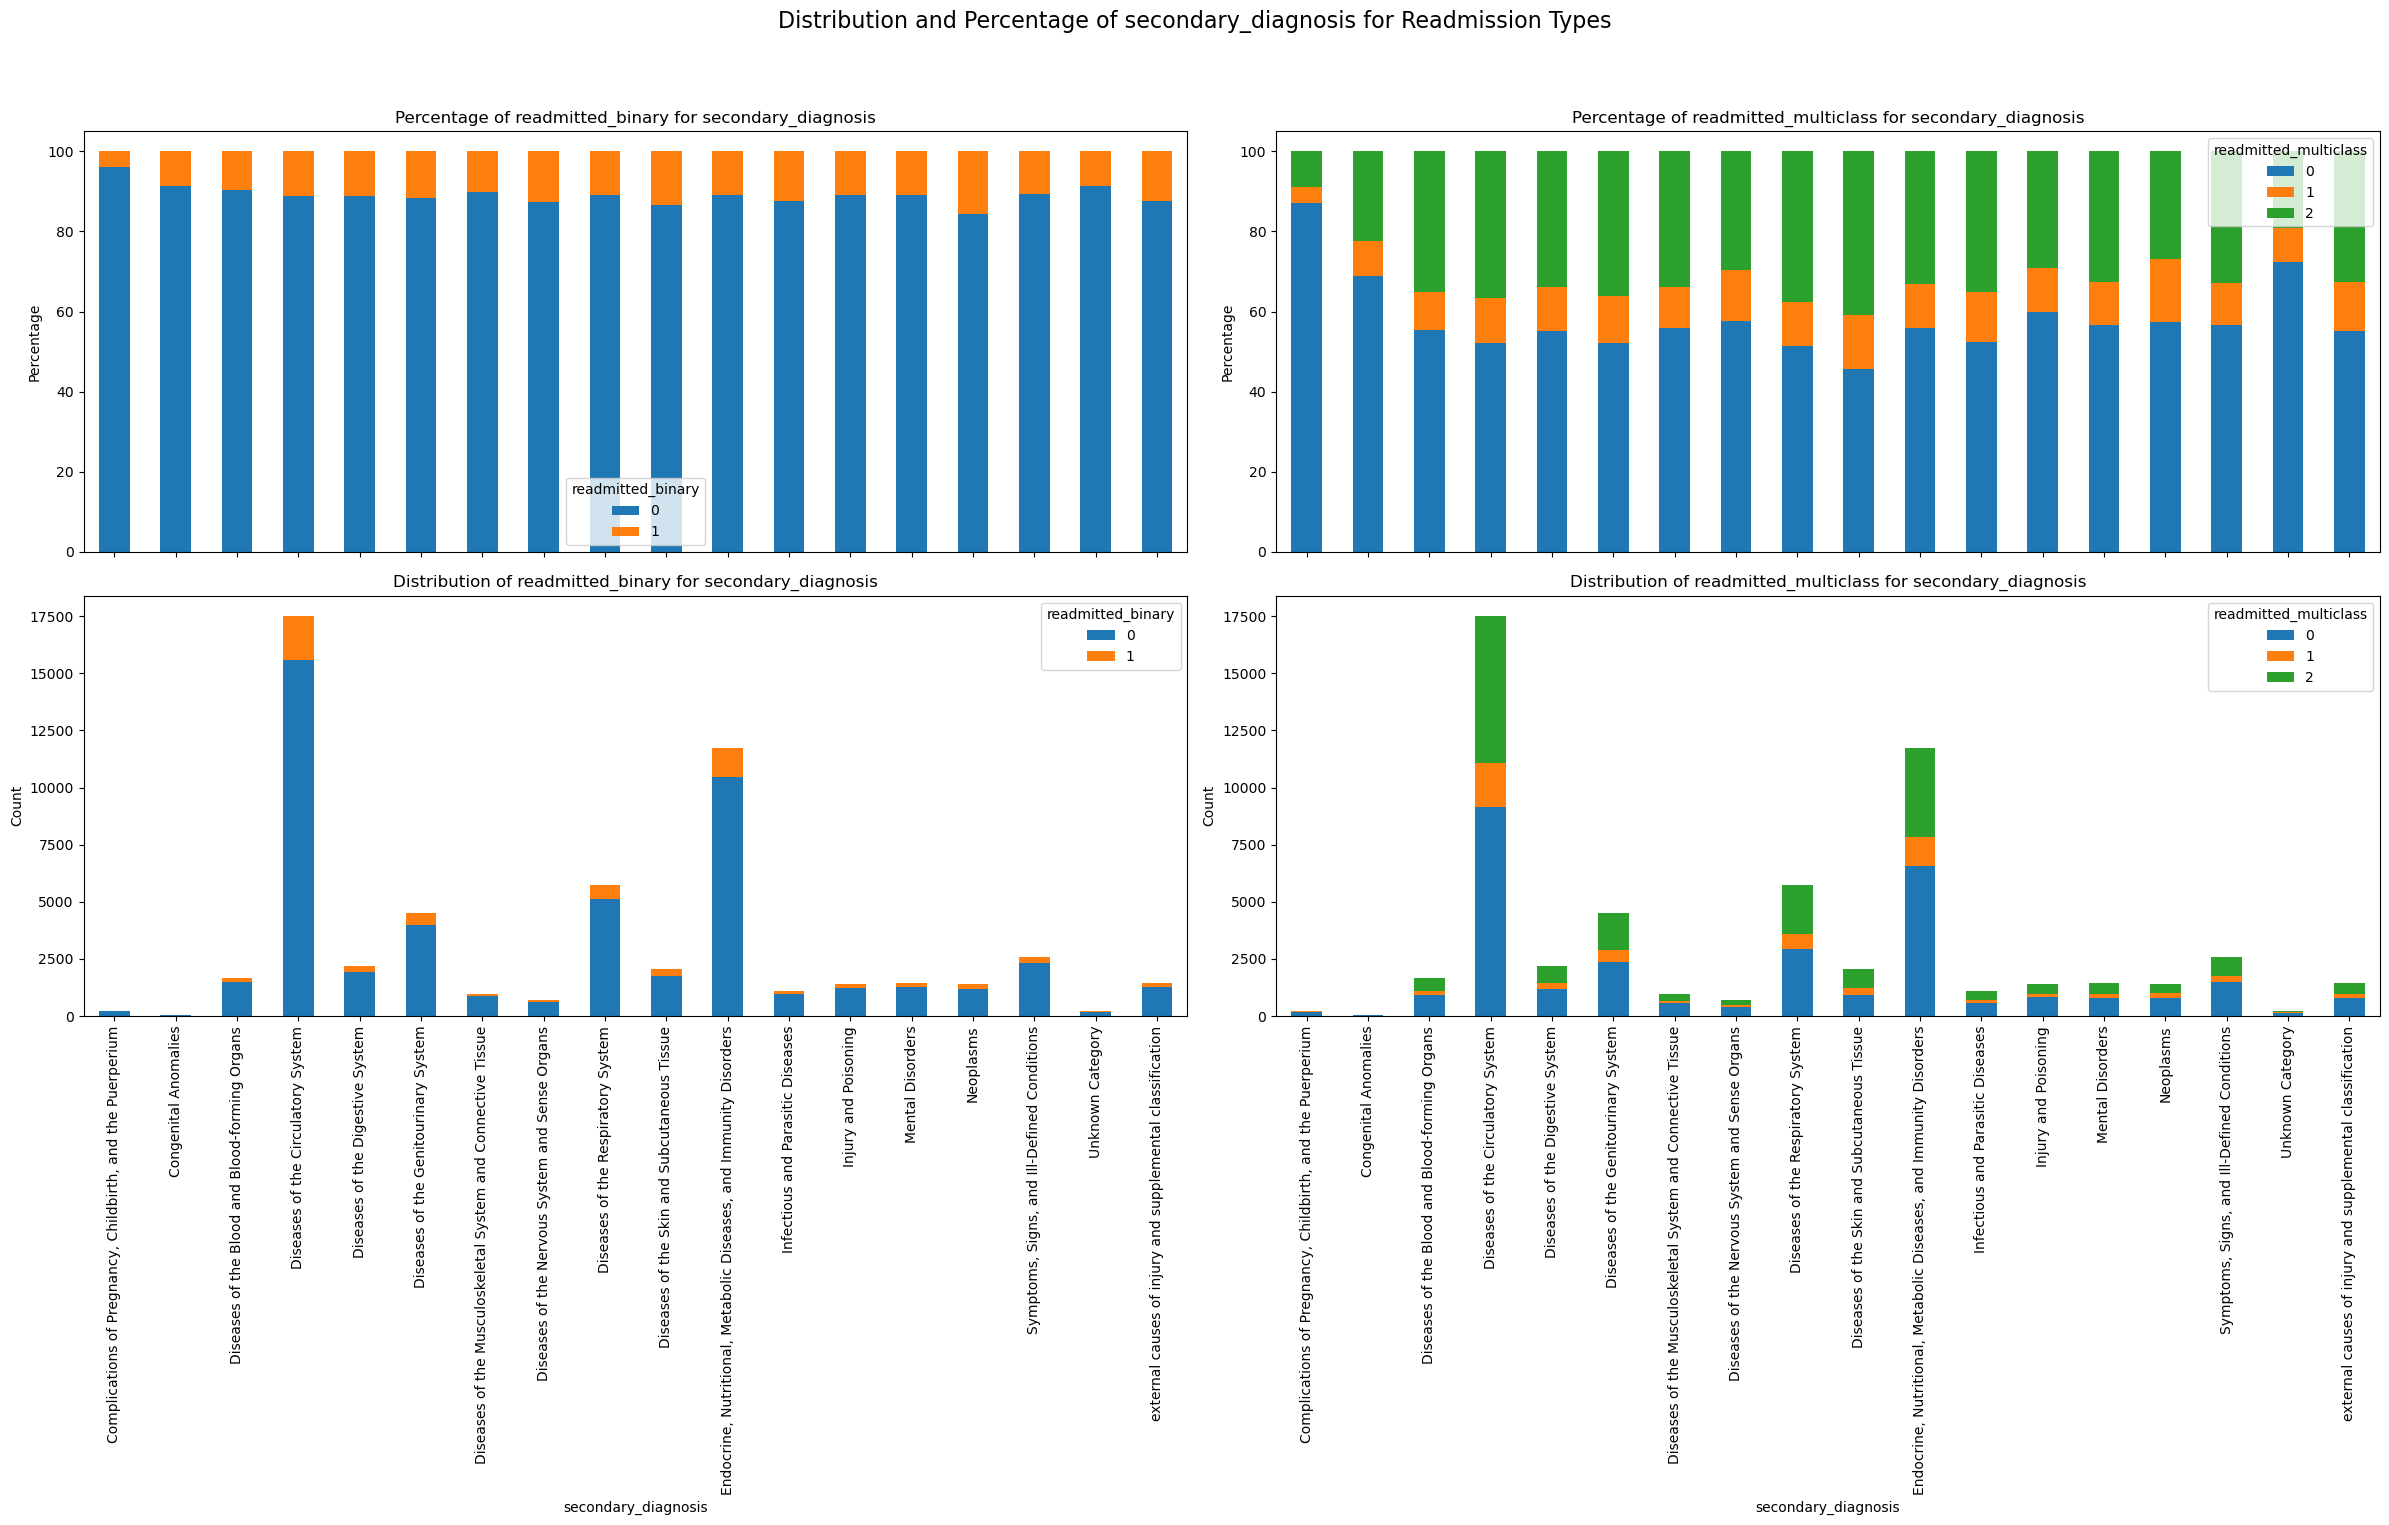

In [1564]:
plot_categorical_distribution(data_train, 'secondary_diagnosis')

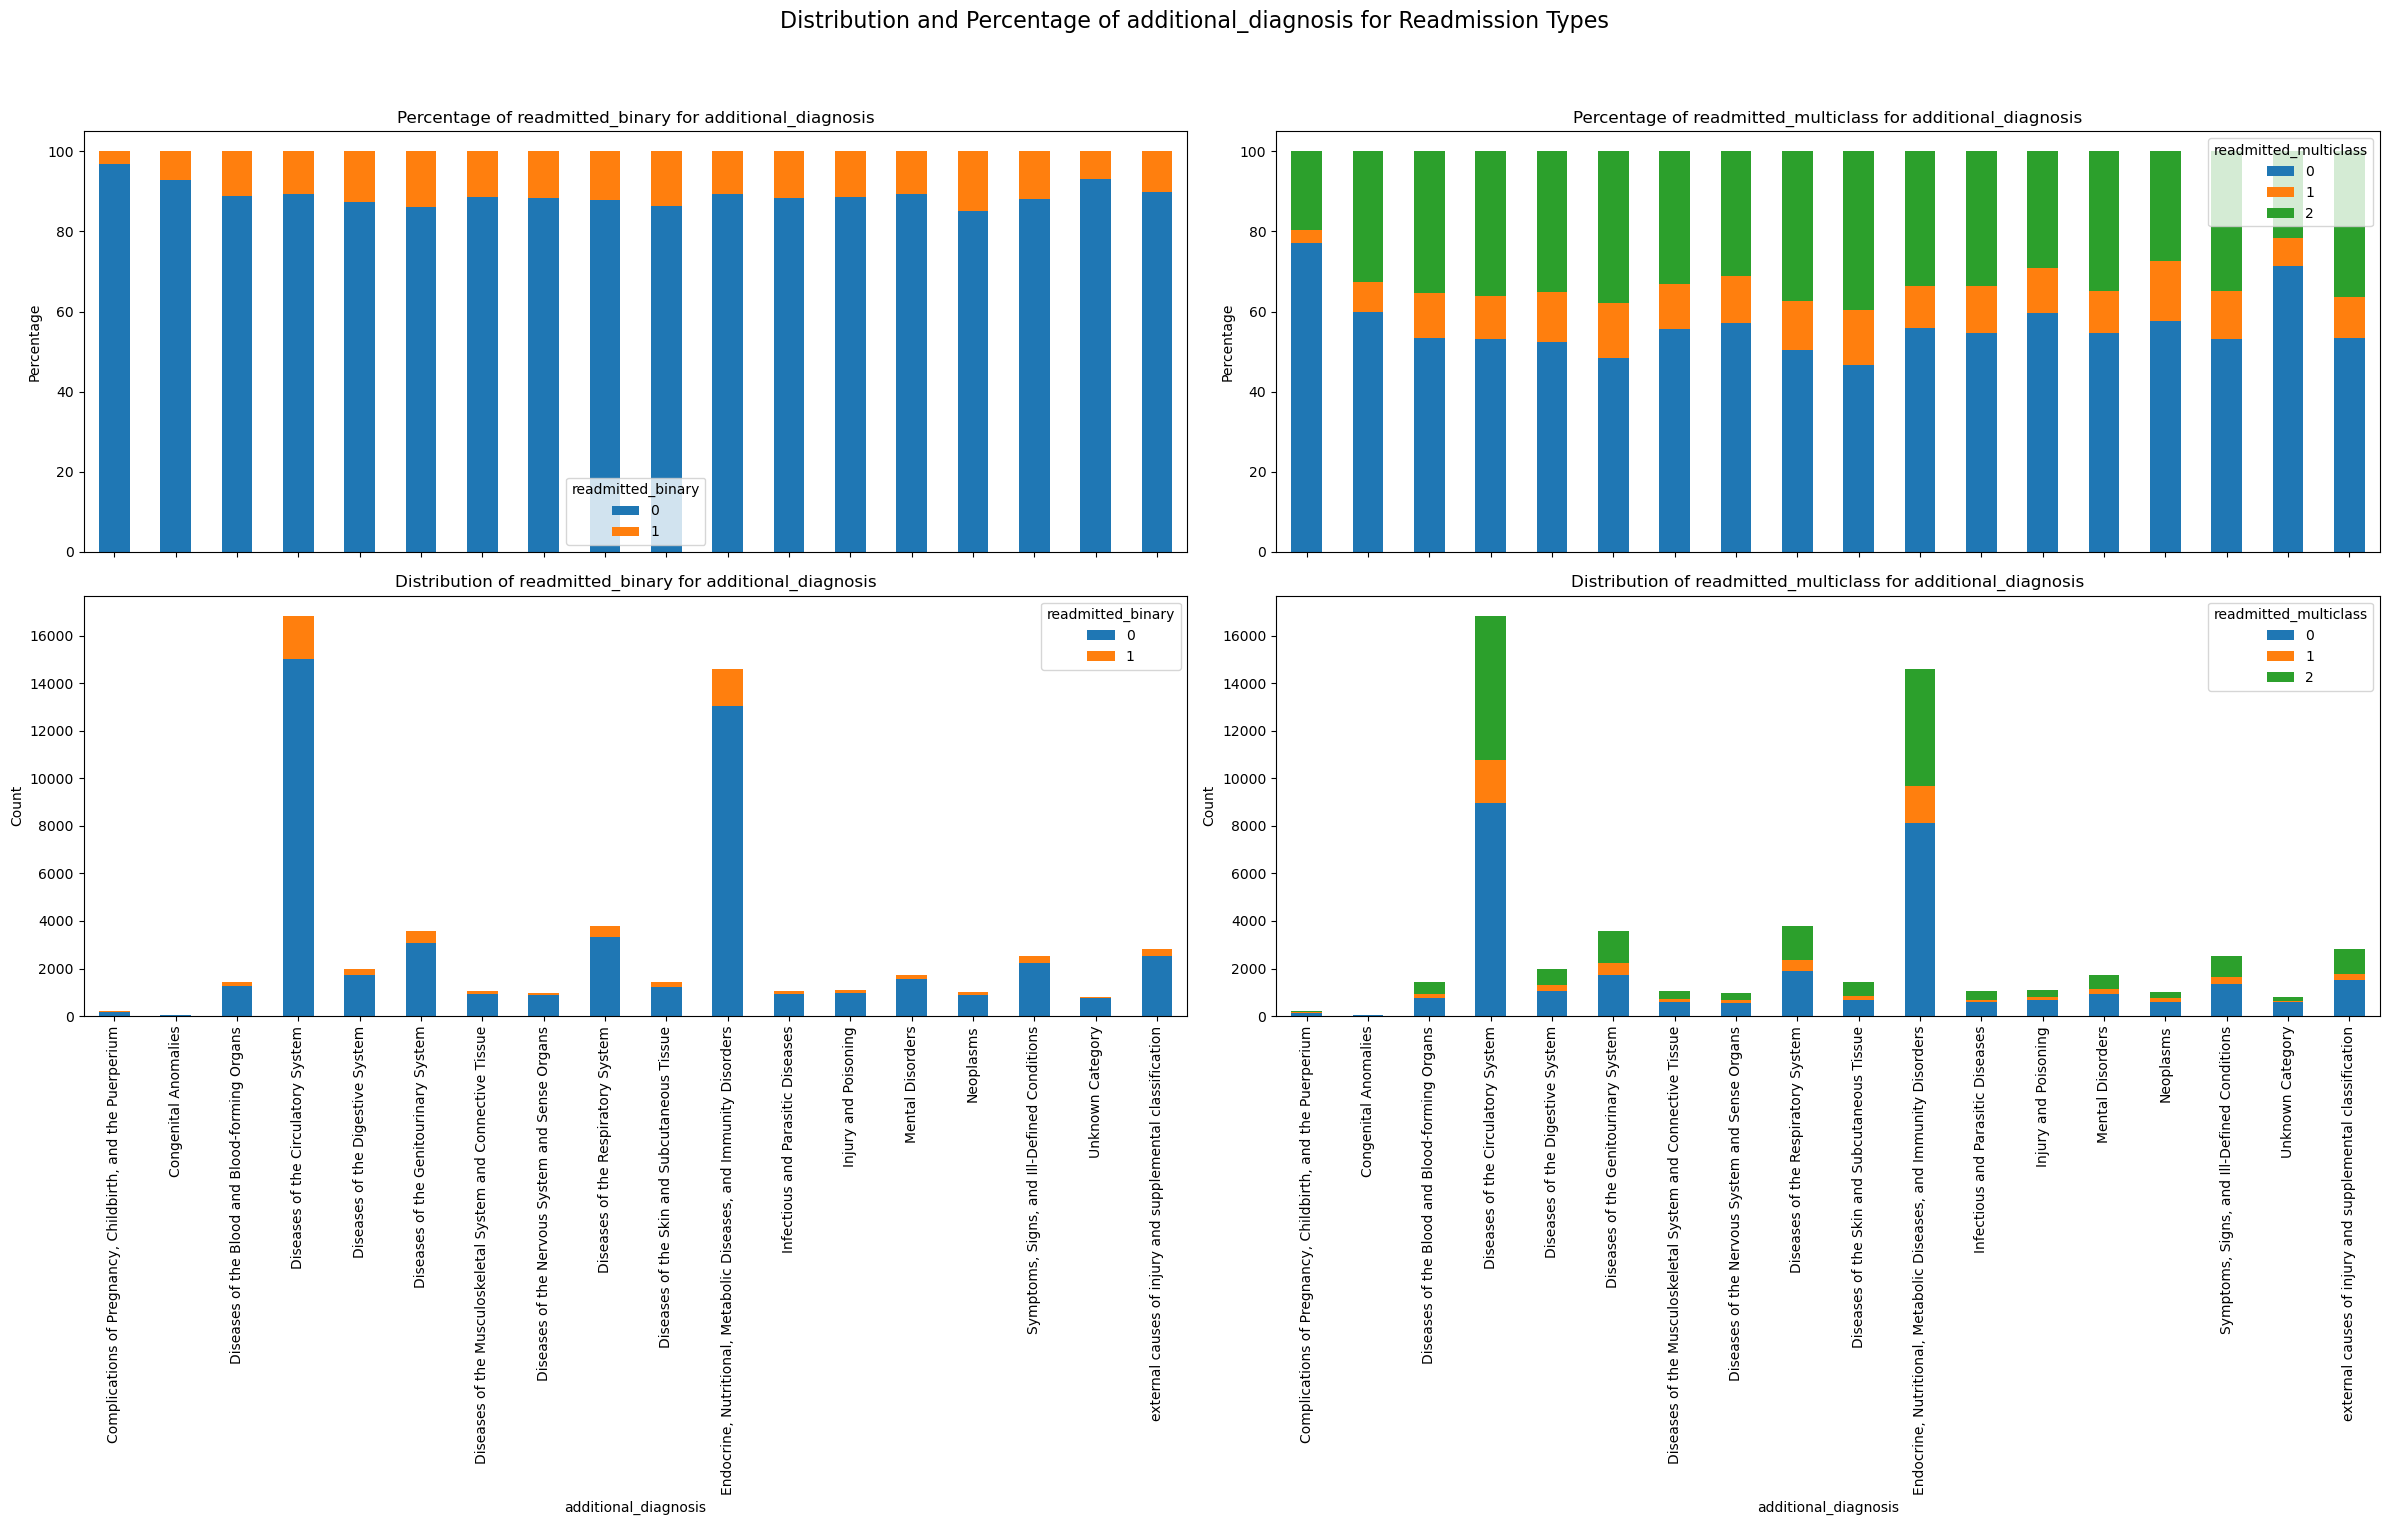

In [1565]:
plot_categorical_distribution(data_train, 'additional_diagnosis')

In [1566]:
# secondary_diagnosis and additional_diagnosis have similar distributions, so we will drop additional_diagnosis
data_train.drop(['additional_diagnosis'], axis=1, inplace=True)
data_val.drop(['additional_diagnosis'], axis=1, inplace=True)
data_test.drop(['additional_diagnosis'], axis=1, inplace=True)

#### number_diagnoses

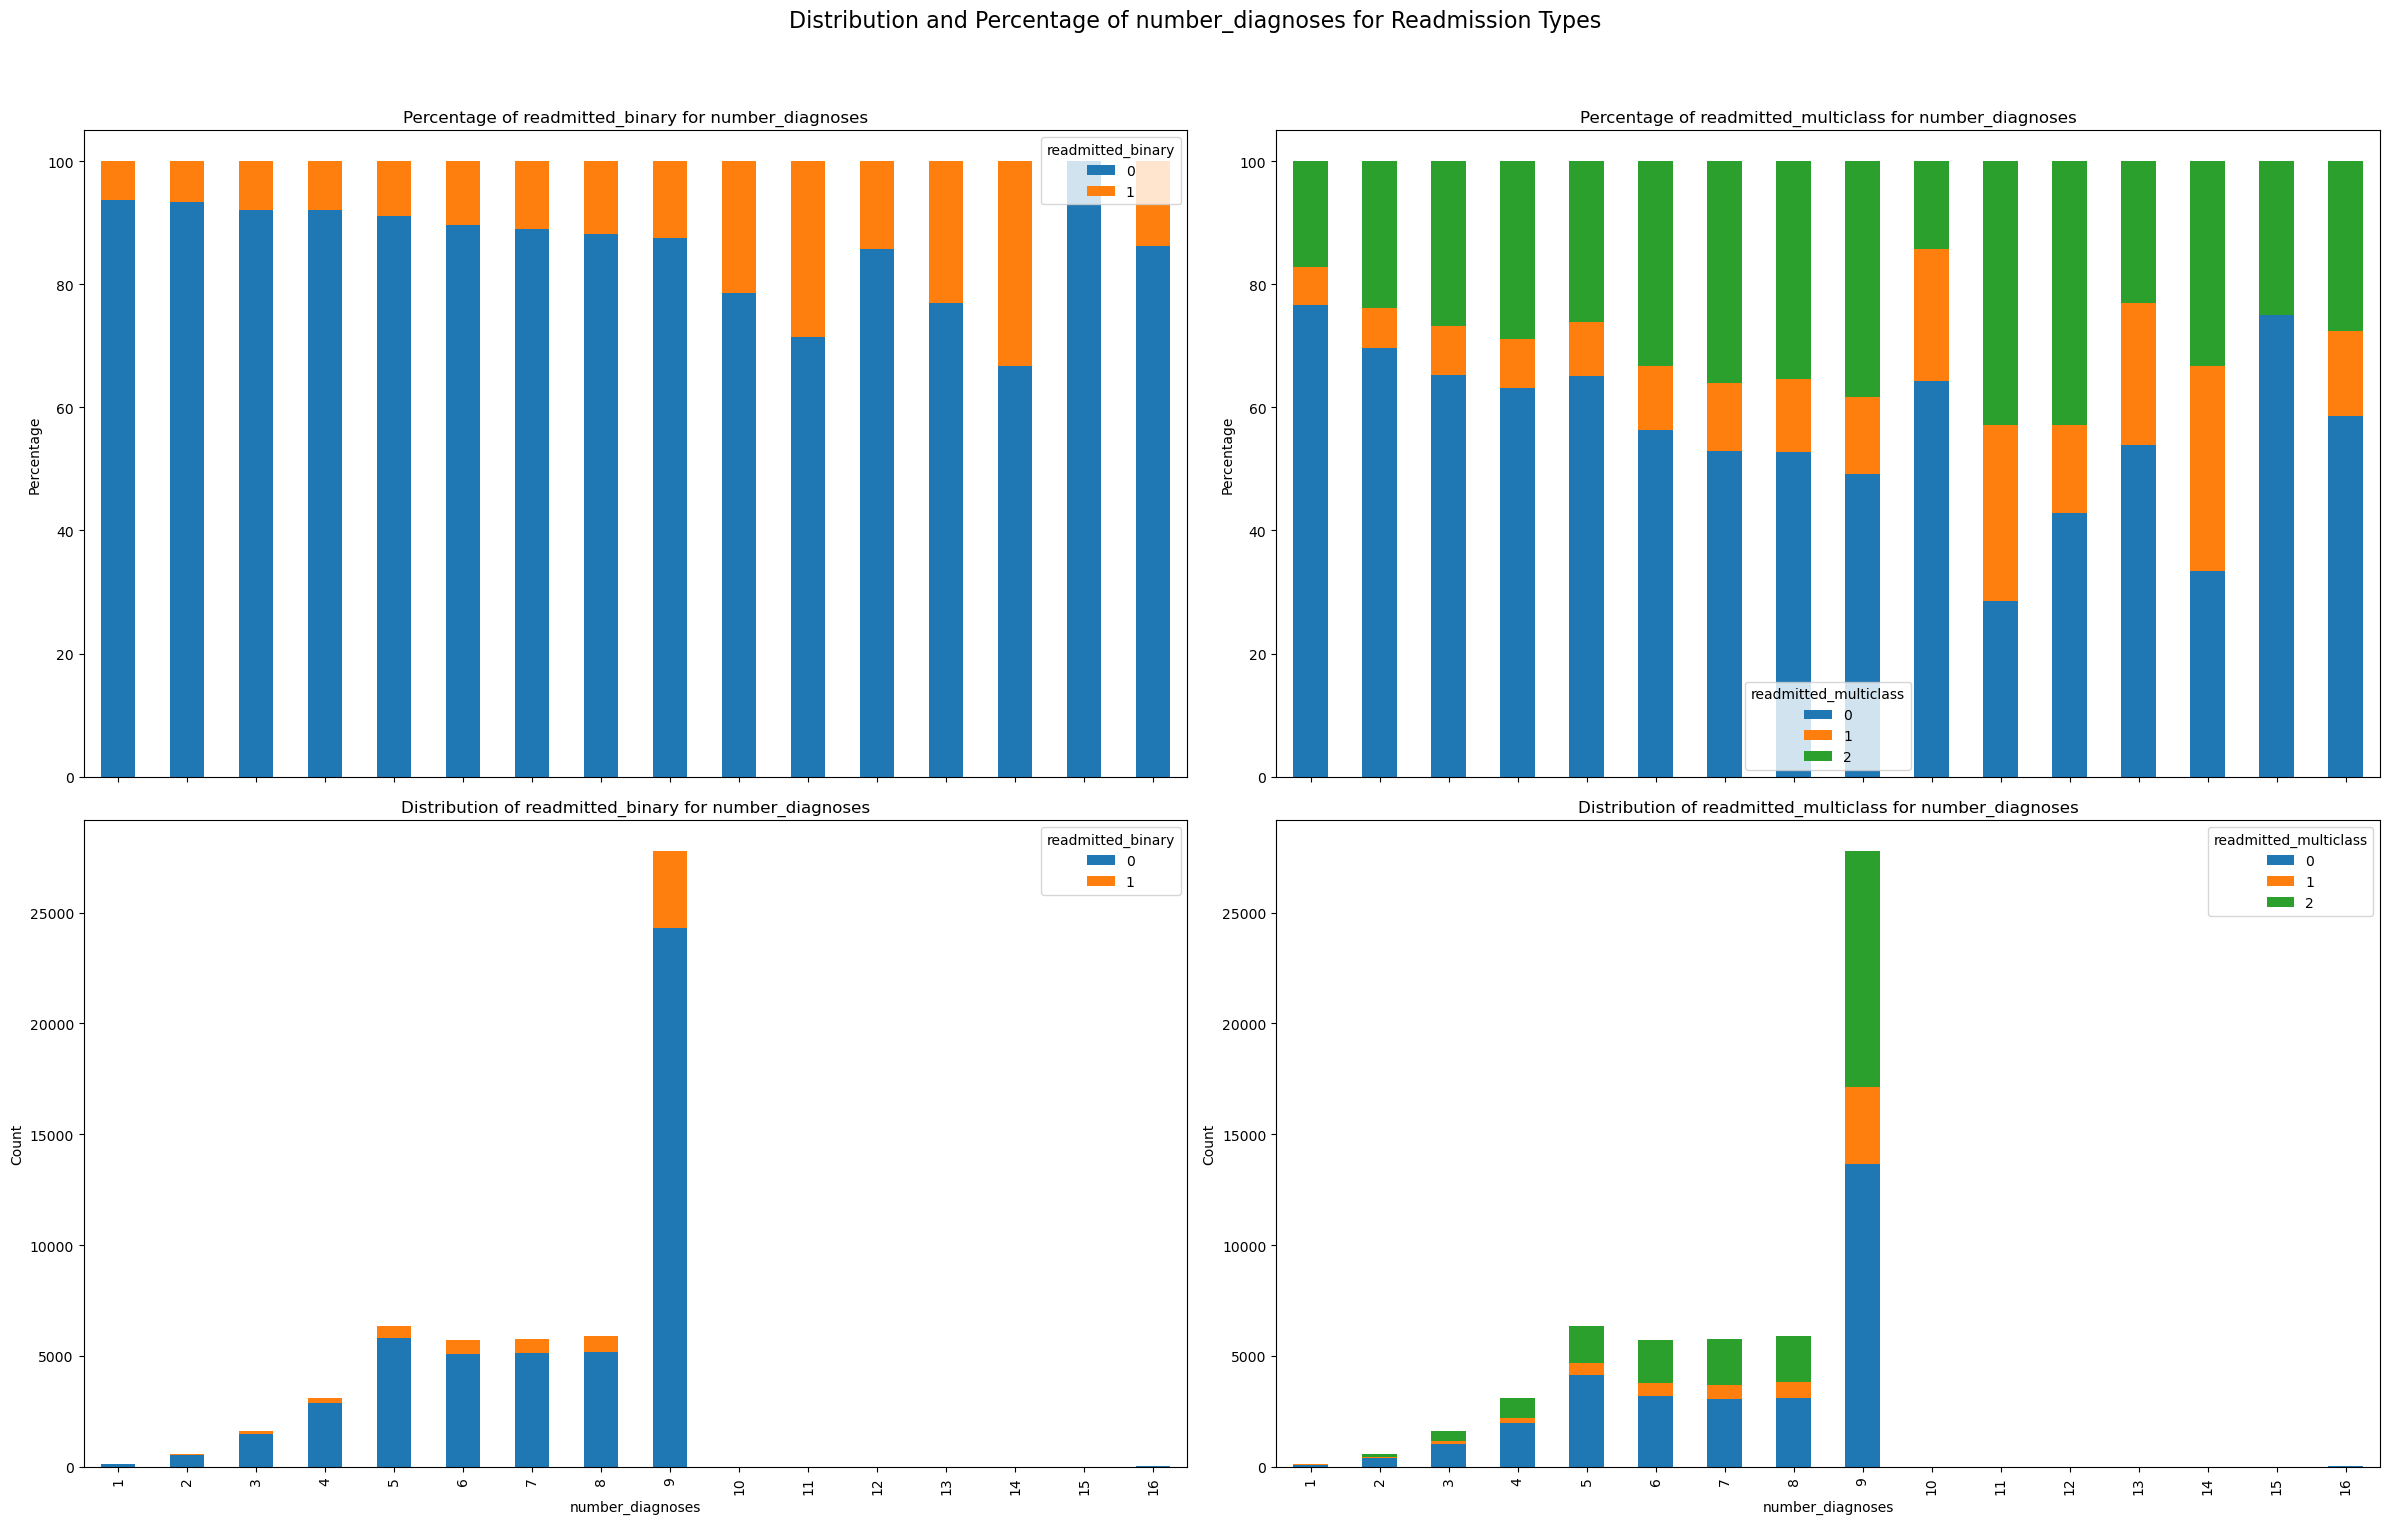

In [1567]:
plot_categorical_distribution(data_train, 'number_diagnoses')

In [1568]:
# clip outliers as before
# cap_diagnoses = cap_outliers(data_train, 'number_diagnoses', 0.99)
# data_val['number_diagnoses'] = data_val['number_diagnoses'].clip(upper=cap_diagnoses)
# data_test['number_diagnoses'] = data_test['number_diagnoses'].clip(upper=cap_diagnoses)

#### glucose_test_result

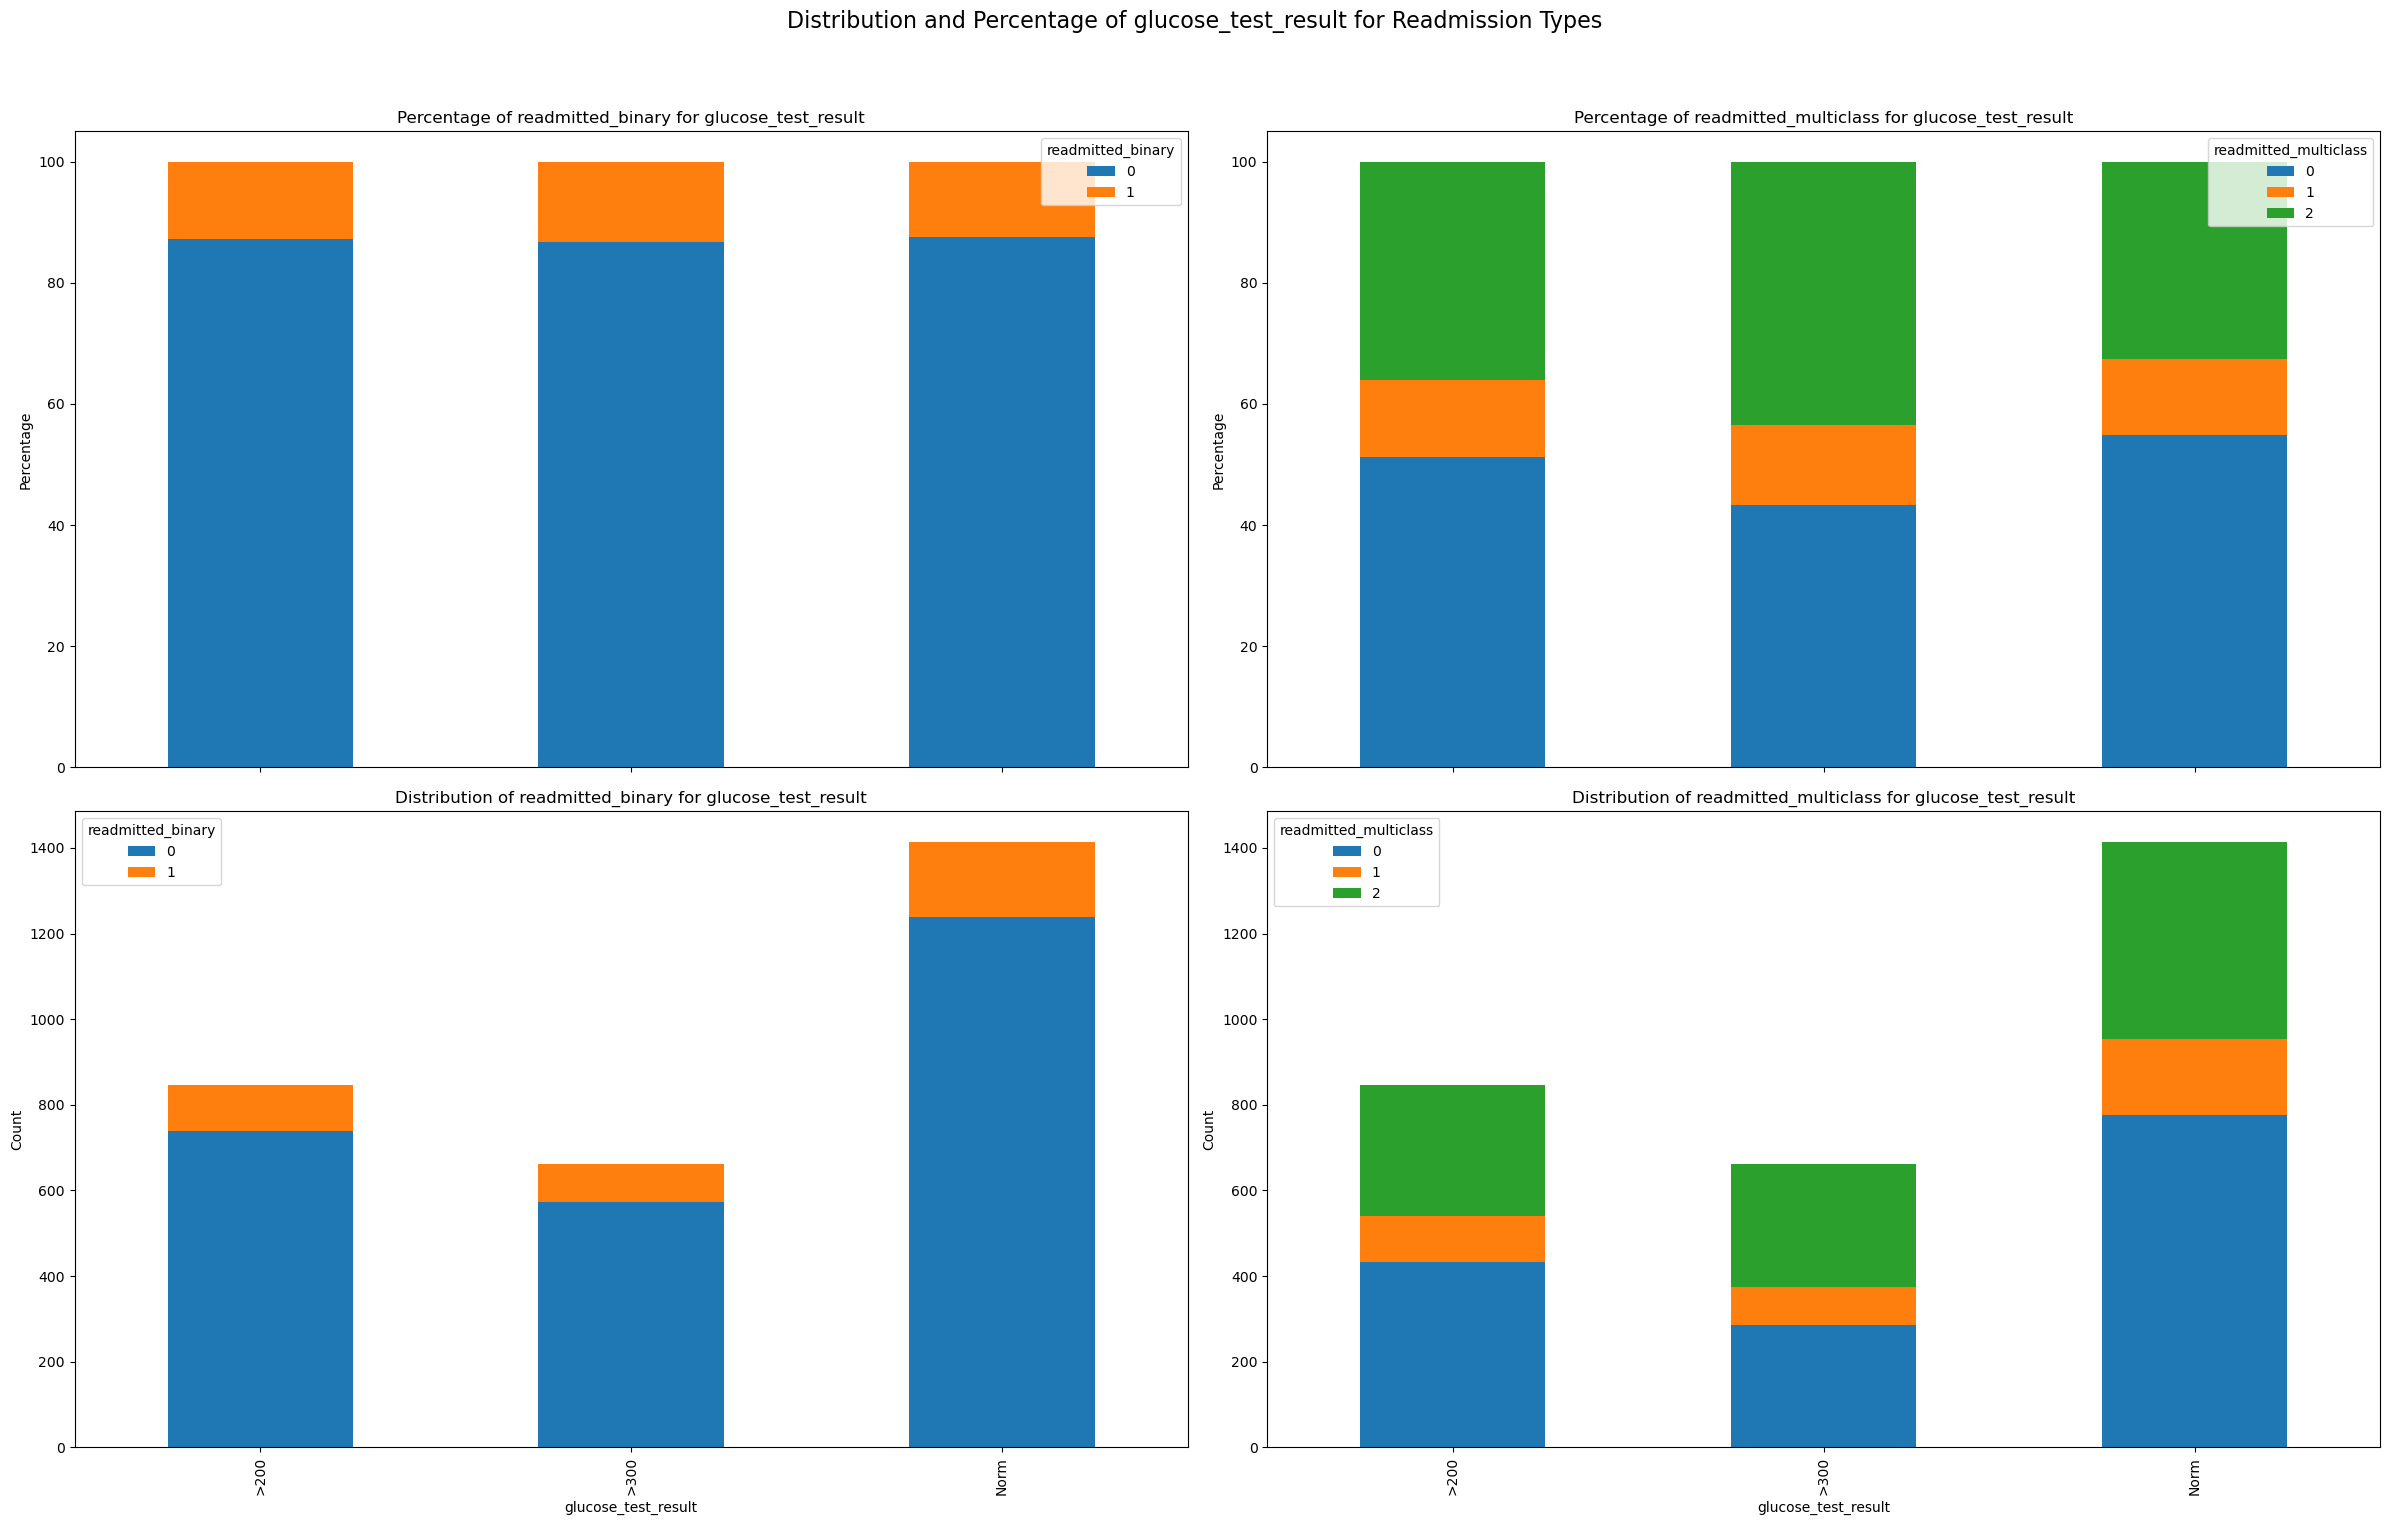

In [1569]:
plot_categorical_distribution(data_train, 'glucose_test_result')

In [1570]:
# fill missing values with 'Not Performed'
data_train['glucose_test_result'] = data_train['glucose_test_result'].fillna('Not Performed')
data_val['glucose_test_result'] = data_val['glucose_test_result'].fillna('Not Performed')
data_test['glucose_test_result'] = data_test['glucose_test_result'].fillna('Not Performed')

#### a1c_test_result

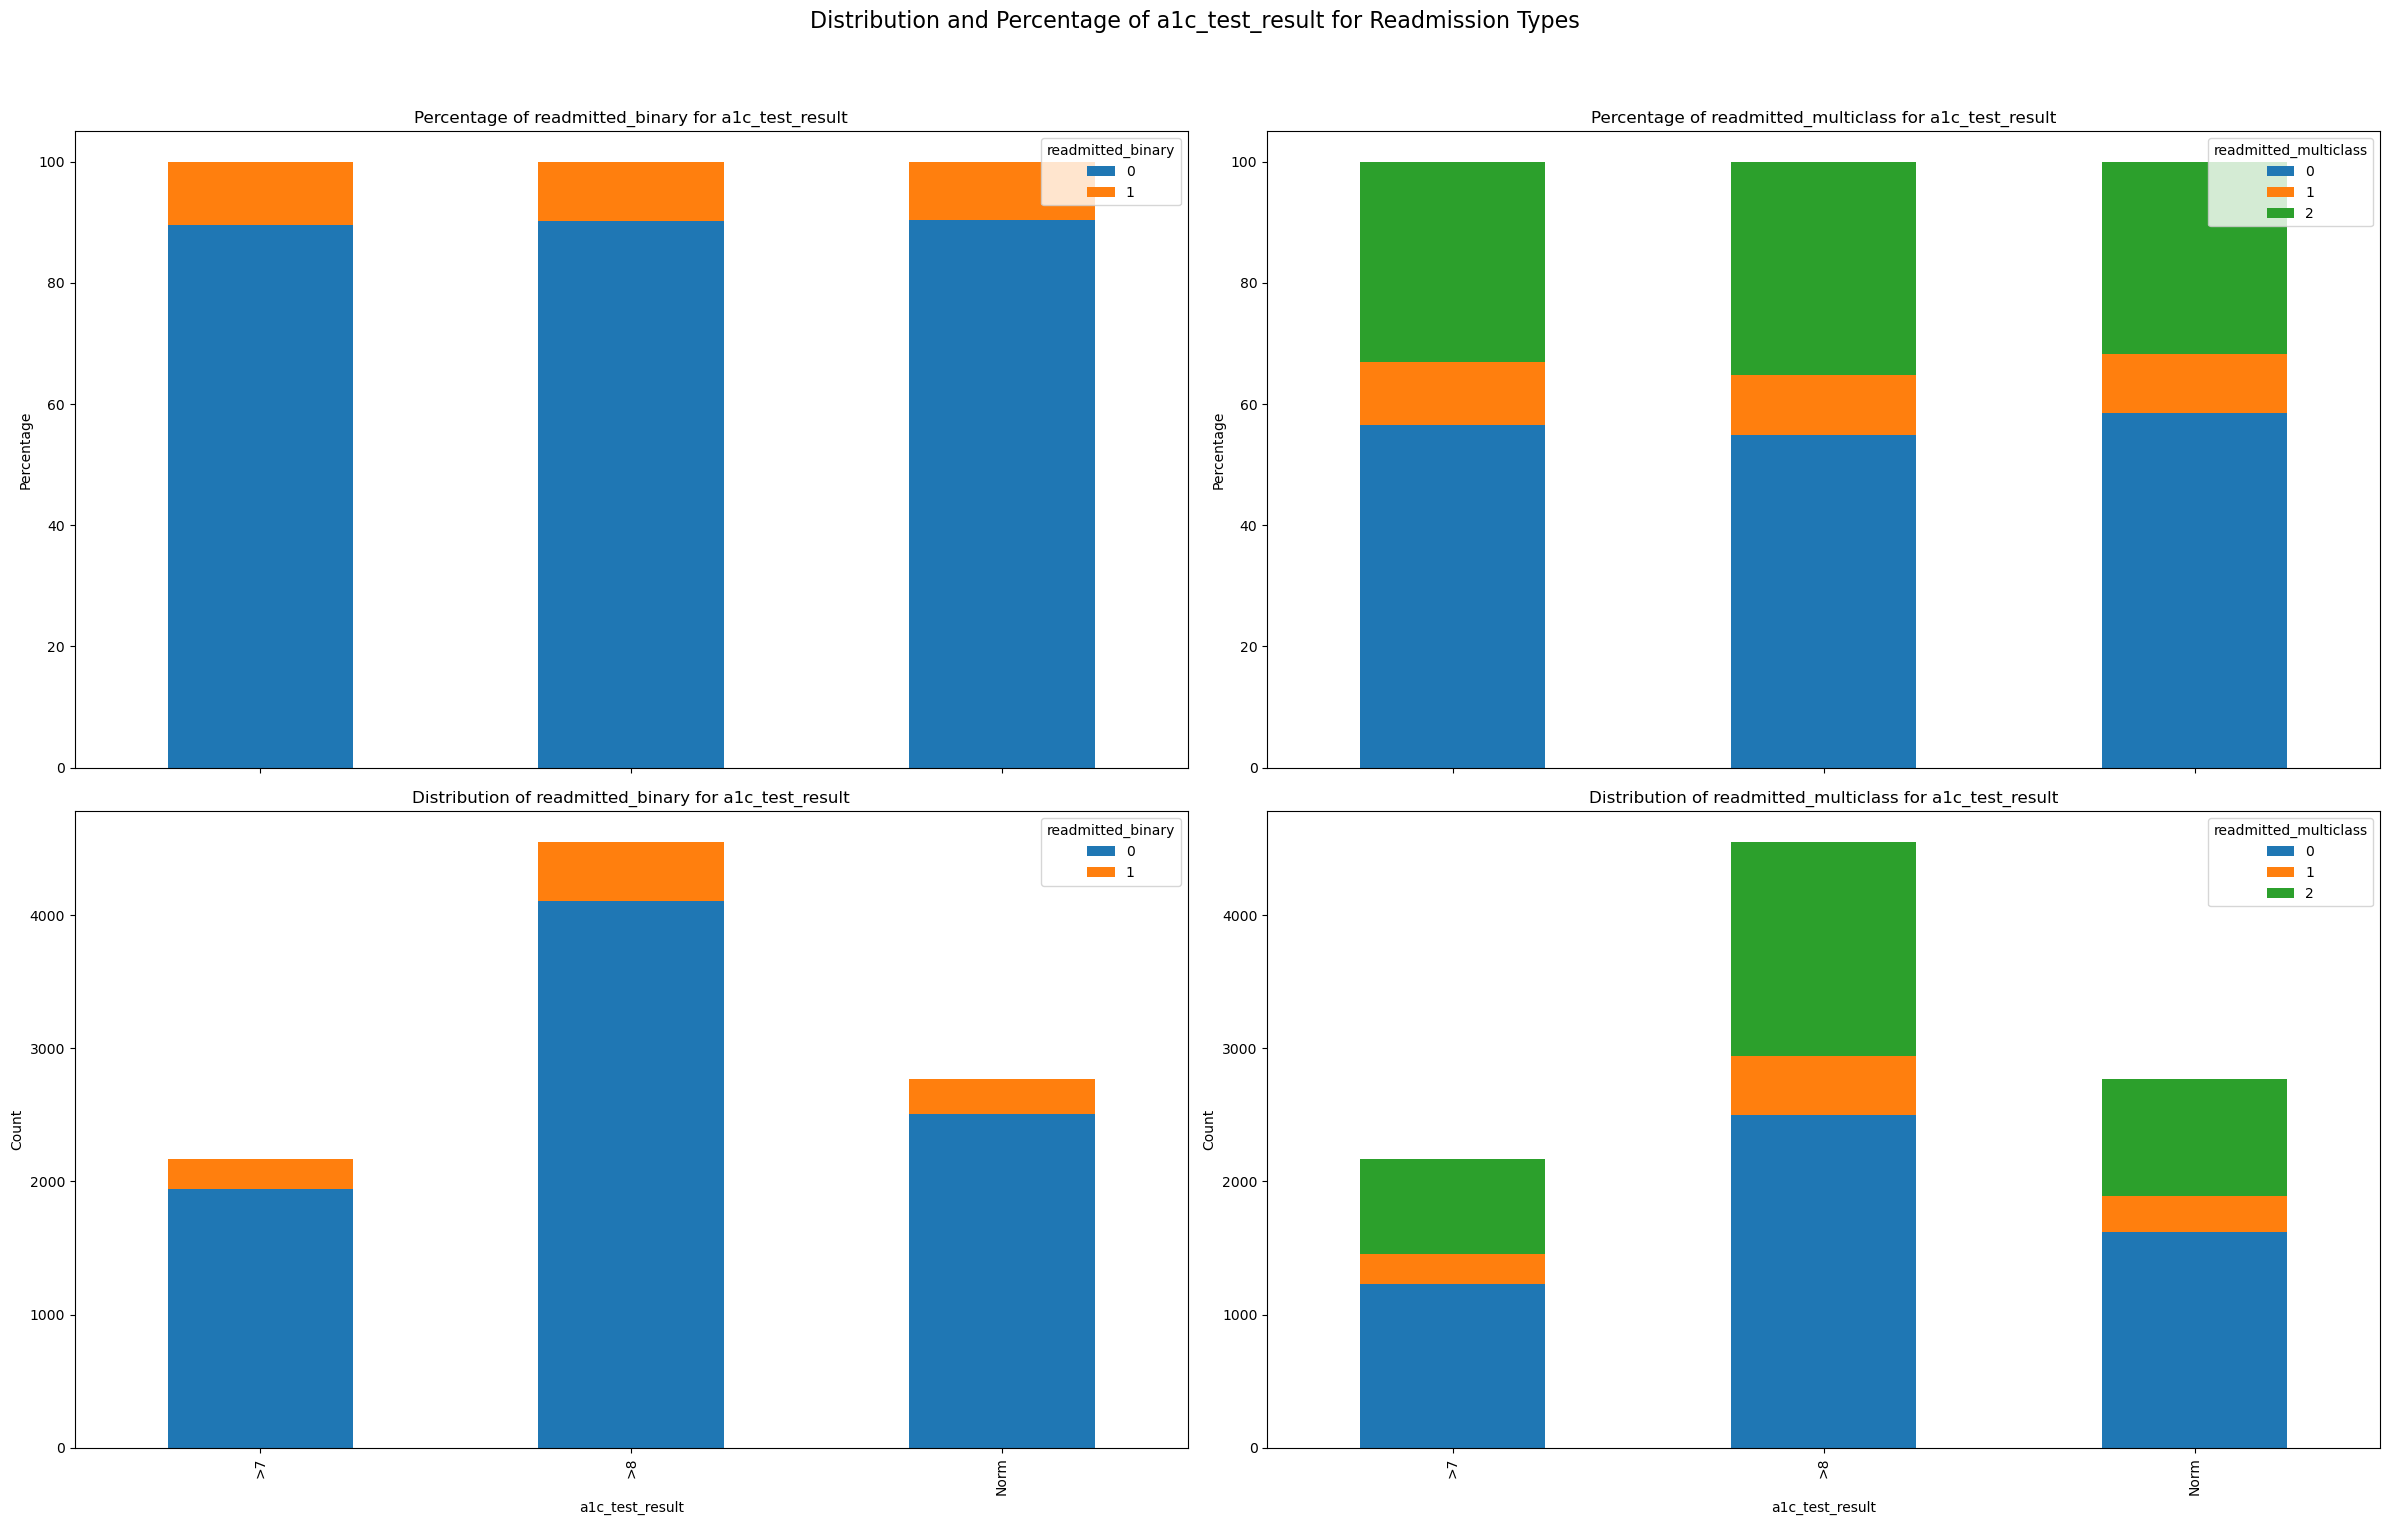

In [1571]:
plot_categorical_distribution(data_train, 'a1c_test_result')

In [1572]:
# fill missing values with 'Not Performed'
data_train['a1c_test_result'] = data_train['a1c_test_result'].fillna('Not Performed')
data_val['a1c_test_result'] = data_val['a1c_test_result'].fillna('Not Performed')
data_test['a1c_test_result'] = data_test['a1c_test_result'].fillna('Not Performed')

#### change_in_meds_during_hospitalization

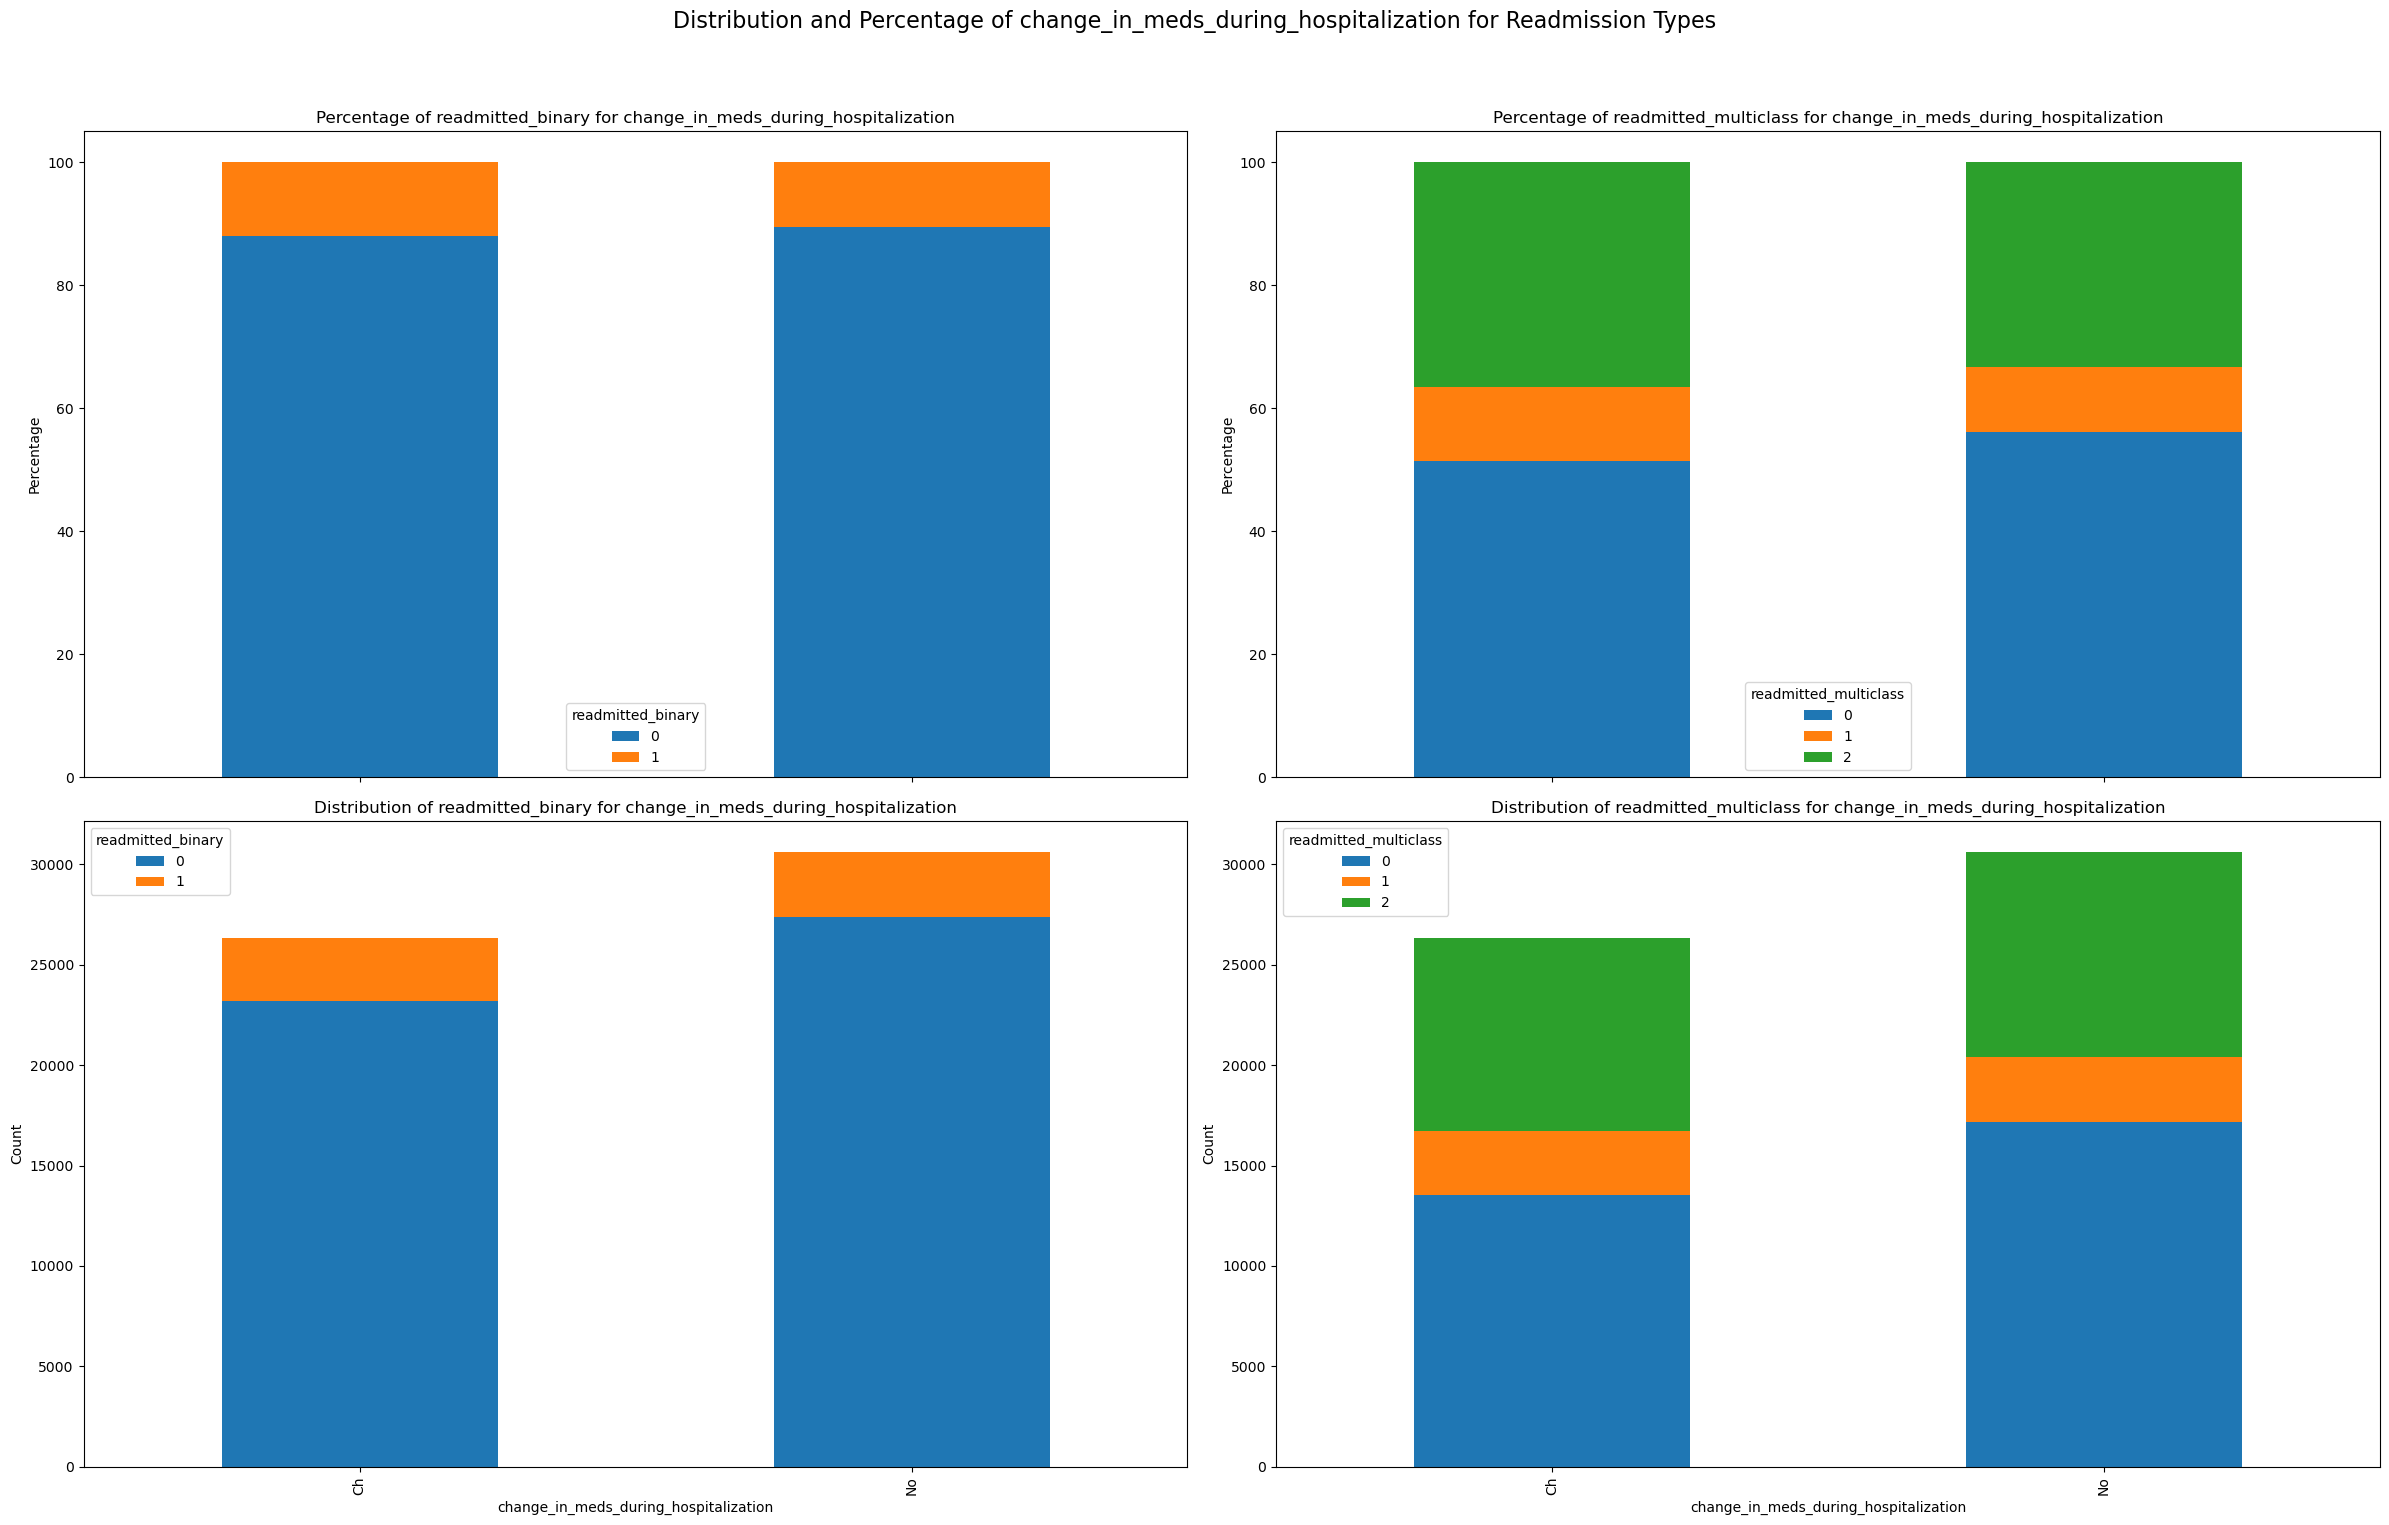

In [1573]:
plot_categorical_distribution(data_train, 'change_in_meds_during_hospitalization')

In [1574]:
# replace 'Ch' and 'No' with 1 and 0
data_train['change_in_meds_during_hospitalization'] = data_train['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})
data_val['change_in_meds_during_hospitalization'] = data_val['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})
data_test['change_in_meds_during_hospitalization'] = data_test['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})

#### prescribed_diabetes_meds

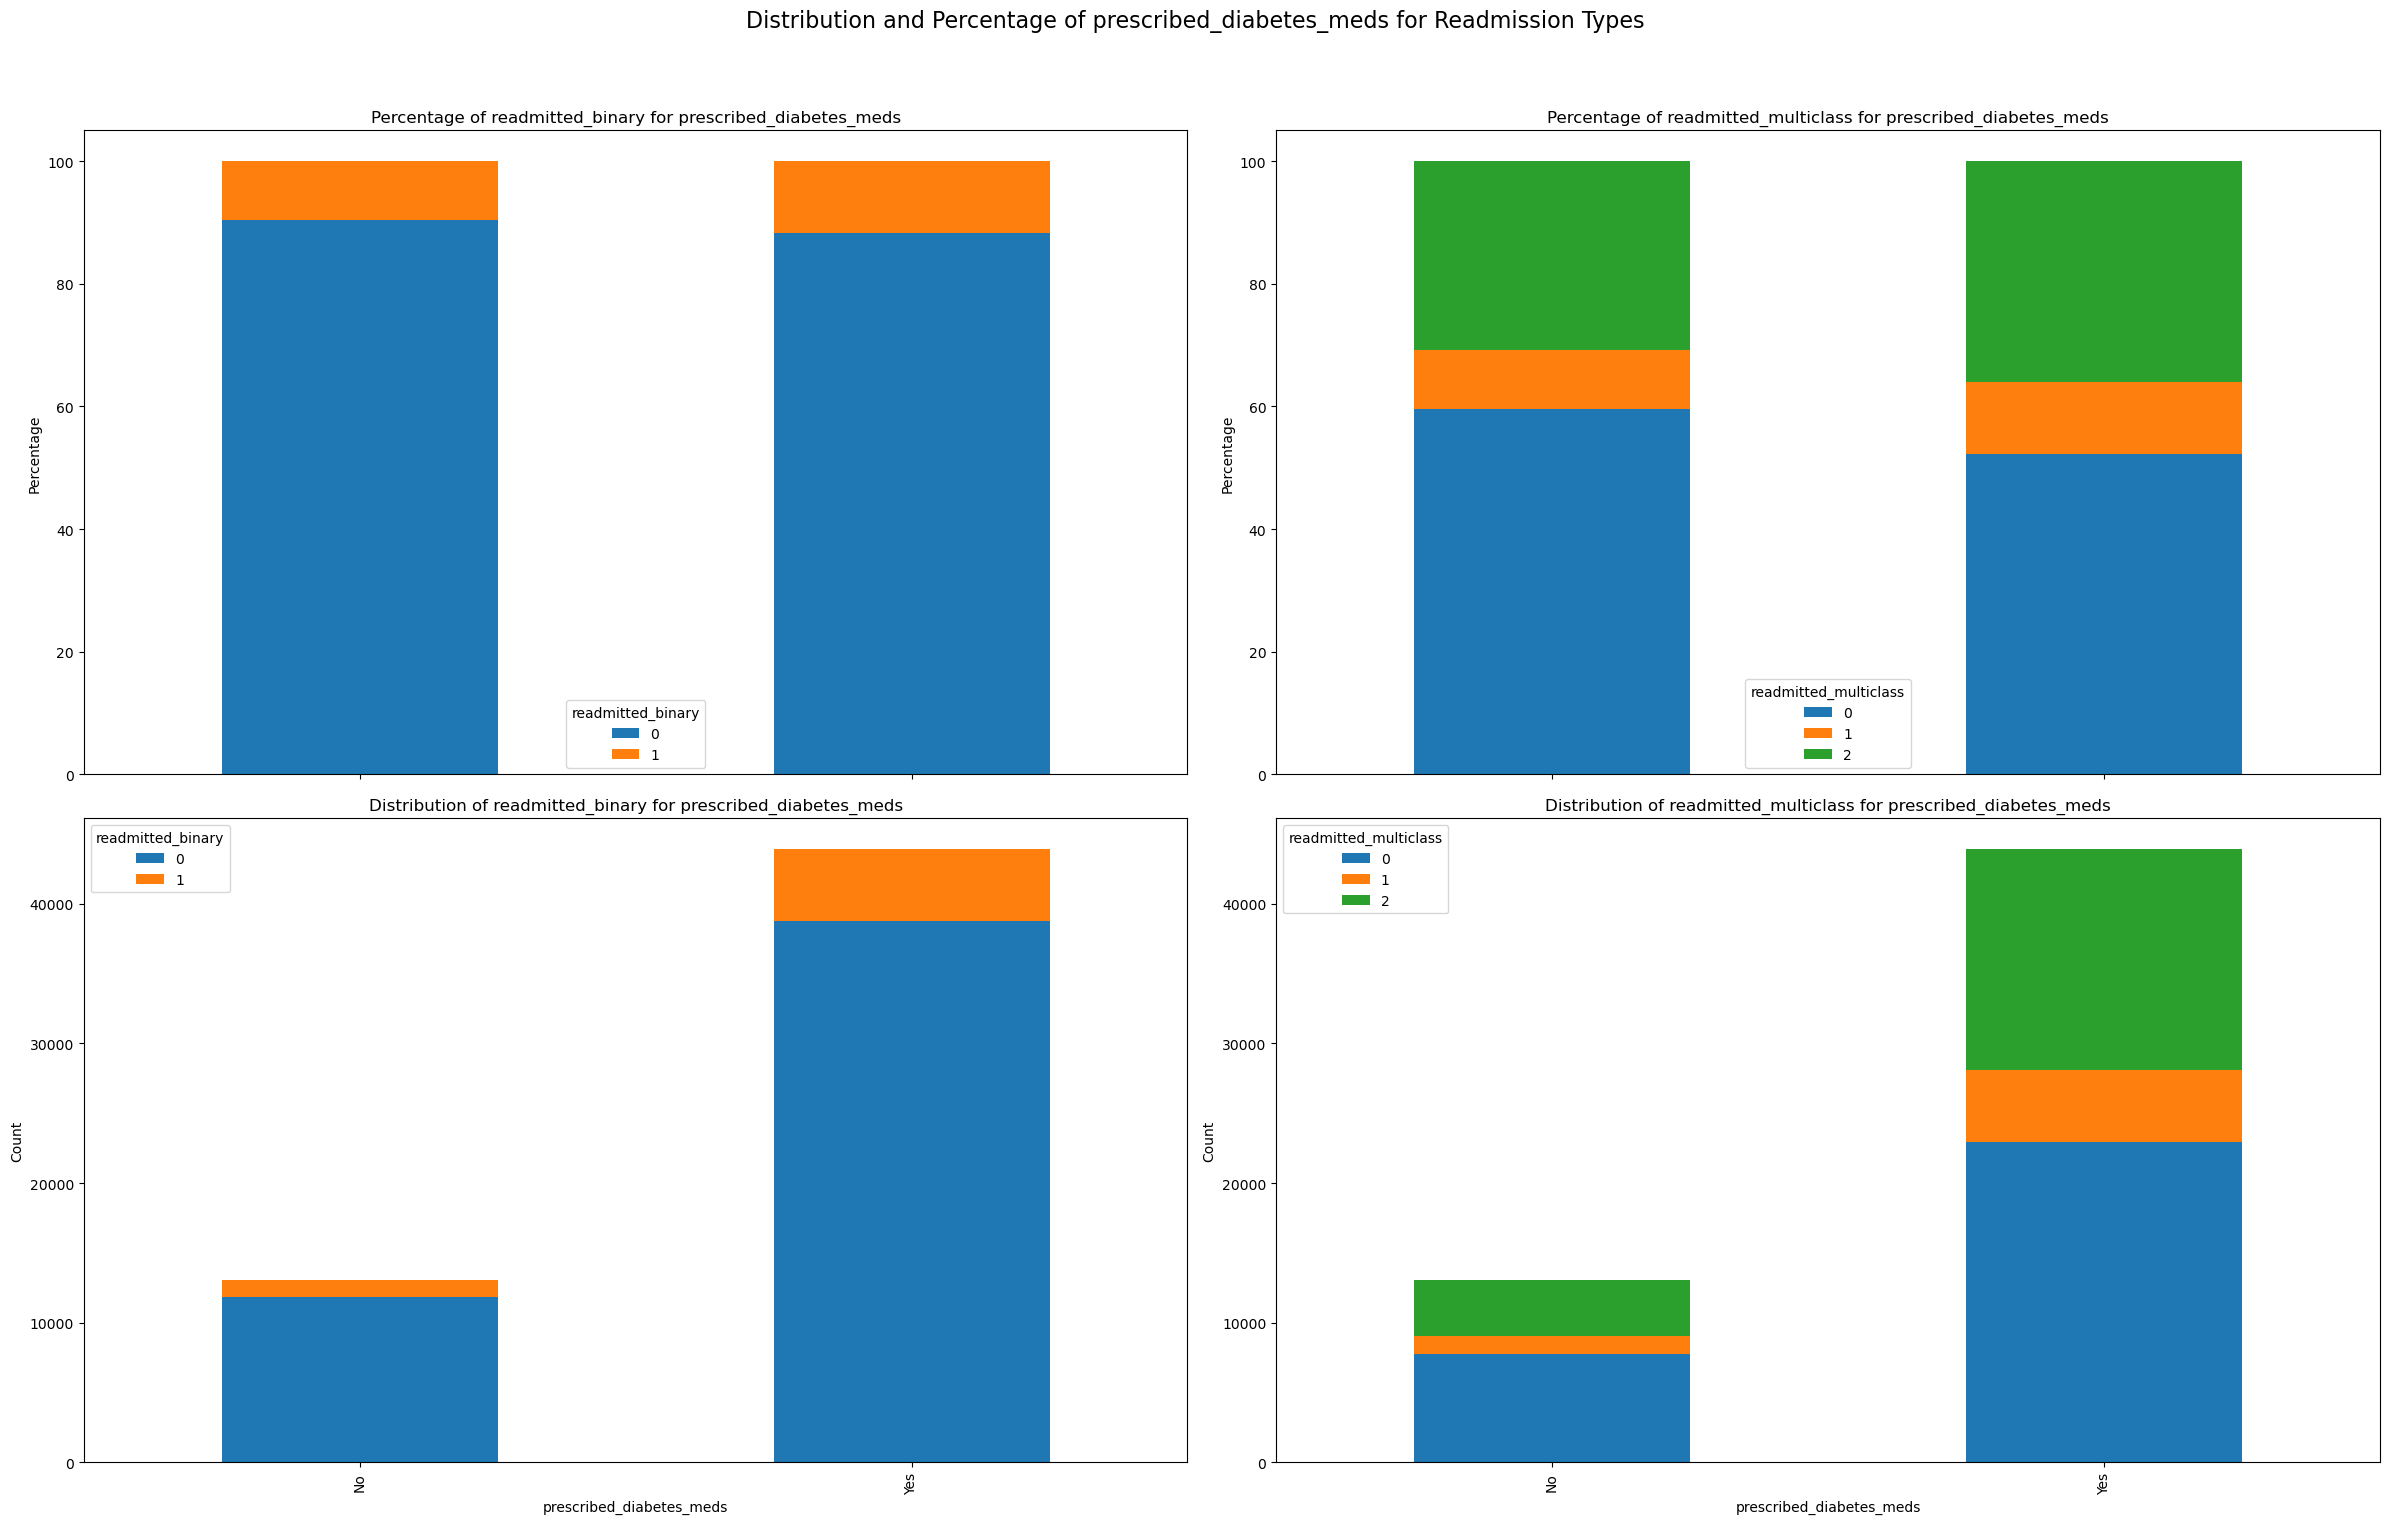

In [1575]:
plot_categorical_distribution(data_train, 'prescribed_diabetes_meds')

In [1576]:
# replace 'Yes' and 'No' with 1 and 0
data_train['prescribed_diabetes_meds'] = data_train['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})
data_val['prescribed_diabetes_meds'] = data_val['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})
data_test['prescribed_diabetes_meds'] = data_test['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})

#### medication

In [1577]:
data_train['medication'].value_counts()

medication
['insulin']                                                          17425
[]                                                                   13068
['metformin']                                                         2538
['metformin', 'insulin']                                              2436
['glipizide']                                                         2184
                                                                     ...  
['metformin', 'glimepiride', 'glipizide', 'glyburide', 'insulin']        1
['glimepiride', 'glyburide', 'pioglitazone', 'insulin']                  1
['metformin', 'nateglinide', 'glimepiride', 'glipizide']                 1
['nateglinide', 'glipizide', 'pioglitazone', 'insulin']                  1
['metformin', 'glyburide', 'acarbose', 'insulin']                        1
Name: count, Length: 283, dtype: int64

In [1578]:
# Extract unique medications from the 'medication' column in data_train_copy
unique_medications = set()

# Iterate through each row in the 'medication' column of data_train_copy and add the medications to the set
for medication_list in data_train['medication']:
    medications = medication_list.strip('[]').replace(" ", "").split(',')
    unique_medications.update(medications)

# Convert the set to a list to count the unique medications
unique_medications_list = list(unique_medications)

# Create binary columns for each unique medication in data_train_copy and set values to 1 if present, 0 if not
for medication in unique_medications_list:
    data_train[medication] = data_train['medication'].apply(lambda x: 1 if medication in x else 0)

# Drop the original 'medication' column from data_train_copy
# data_train_copy = data_train_copy.drop(columns=['medication'])

# Repeat the process for data_validation_copy using the unique medications extracted from data_train_copy
for medication in unique_medications_list:
    data_val[medication] = data_val['medication'].apply(lambda x: 1 if medication in x else 0)
    data_test[medication] = data_test['medication'].apply(lambda x: 1 if medication in x else 0)

# Drop the original 'medication'
data_train.drop(columns=['medication'], inplace=True)
data_val.drop(columns=['medication'], inplace=True)
data_test.drop(columns=['medication'], inplace=True)


# Encoding

In [1579]:
columns_to_hot_encode = ['race', 'admission_type', 'discharge_disposition', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'glucose_test_result', 'a1c_test_result']

In [1580]:
# Initialize the OneHotEncoder with handle_unknown='ignore' to ignore unknown categories
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

# Fit the encoder on the training data
encoder.fit(data_train[columns_to_hot_encode])

# Transform both training and testing data
train_encoded = encoder.transform(data_train[columns_to_hot_encode])
val_encoded = encoder.transform(data_val[columns_to_hot_encode])
test_encoded = encoder.transform(data_test[columns_to_hot_encode])

# Convert the encoded matrices to DataFrames
# Ensure the index is aligned with the original DataFrame's index
train_encoded_df = pd.DataFrame(train_encoded.toarray(), 
                                index=data_train.index,
                                columns=encoder.get_feature_names_out(columns_to_hot_encode))

val_encoded_df = pd.DataFrame(val_encoded.toarray(),
                                index=data_val.index,
                                columns=encoder.get_feature_names_out(columns_to_hot_encode))

test_encoded_df = pd.DataFrame(test_encoded.toarray(), 
                               index=data_test.index,
                               columns=encoder.get_feature_names_out(columns_to_hot_encode))

# Concatenate the encoded columns back to the original dataframes
data_train = pd.concat([data_train.drop(columns=columns_to_hot_encode), train_encoded_df], axis=1)
data_val = pd.concat([data_val.drop(columns=columns_to_hot_encode), val_encoded_df], axis=1)
data_test = pd.concat([data_test.drop(columns=columns_to_hot_encode), test_encoded_df], axis=1)

# Scaling

In [1581]:
columns_to_scale = ['age', 'previous_admissions', 'outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']

In [1582]:
# scale the columns
scaler = MinMaxScaler()

# fit the scaler on the training data
scaler.fit(data_train[columns_to_scale])

# transform both training and testing data
data_train[columns_to_scale] = scaler.transform(data_train[columns_to_scale])
data_val[columns_to_scale] = scaler.transform(data_val[columns_to_scale])
data_test[columns_to_scale] = scaler.transform(data_test[columns_to_scale])

## Remaining missing values

In [1583]:
features_for_imputation = ['previous_admissions', 'outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Prepare the training data for imputation (excluding 'age')
train_data_for_imputation = data_train[features_for_imputation]

# Fit the imputer on the training data and transform the 'age' column
data_train['age'] = knn_imputer.fit_transform(data_train[['age']].join(train_data_for_imputation))[:, 0]

# Prepare the validation and test data for imputation (excluding 'age')
val_data_for_imputation = data_val[features_for_imputation]
test_data_for_imputation = data_test[features_for_imputation]

# Transform the 'age' column in validation and test data using the trained imputer
data_val['age'] = knn_imputer.transform(data_val[['age']].join(val_data_for_imputation))[:, 0]
data_test['age'] = knn_imputer.transform(data_test[['age']].join(test_data_for_imputation))[:, 0]

# Save and Reload

In [1584]:
# use pickle to save the data_train, data_val and data_test
with open('data_train.pkl', 'wb') as f:
    pickle.dump(data_train, f)

with open('data_val.pkl', 'wb') as f:
    pickle.dump(data_val, f)

with open('data_test.pkl', 'wb') as f:
    pickle.dump(data_test, f)

In [1585]:
# load the data_train, data_val and data_test
with open('data_train.pkl', 'rb') as f:
    data_train = pickle.load(f)

with open('data_val.pkl', 'rb') as f:
    data_val = pickle.load(f)

with open('data_test.pkl', 'rb') as f:
    data_test = pickle.load(f)



# Feature Engineering

# Binary Classification

In [1586]:
# define X_train, y_train, X_val, y_val
X_train = data_train.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1)
y_train = data_train['readmitted_binary']

X_val = data_val.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1)
y_val = data_val['readmitted_binary']

X_test = data_test.copy()

### OverSampling

In [1587]:
# Create a pipeline that first applies SMOTE and then applies RandomUnderSampler
over = SMOTE(sampling_strategy=0.5, random_state=42)  # Oversample to 50% of majority class
under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # Undersample to equalize
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Apply the pipeline to your training data
X_train, y_train = pipeline.fit_resample(X_train, y_train)

### Feature Selection

In [1588]:
# use logistic regression in RFE to select best features

logreg = LogisticRegression(random_state=42, max_iter=1000)

# Assuming logreg is your logistic regression model
rfe = RFE(estimator=logreg, n_features_to_select=120)

# Fitting the RFE model
rfe = rfe.fit(X_train, y_train.values.ravel())

cols = X_train.columns[rfe.support_].tolist()

X_train = X_train[cols]
X_test = X_test[cols]

In [1589]:
X_val = X_val[cols]

### Models

In [1590]:
# create a function that will fit the model and print the f1 score

def fit_model(model, X_train, y_train, X_validation, y_validation):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    print('F1 score: {}'.format(f1_score(y_validation, y_pred)))
    return model

In [1591]:
# logistic regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg = fit_model(logreg, X_train, y_train, X_val, y_val)

F1 score: 0.29269216205982584


In [1592]:
# random forest
rf = RandomForestClassifier(random_state=42)
rf = fit_model(rf, X_train, y_train, X_val, y_val)

F1 score: 0.18133802816901406


In [1593]:
# xgboost
xgb = XGBClassifier(random_state=42)
xgb = fit_model(xgb, X_train, y_train, X_val, y_val)

F1 score: 0.1943171402383135


In [1594]:
# Parameter lists
n_estimators = 100
criterion = 'entropy'     # choose between 'gini', 'entropy', and 'log_loss'
max_depth = 30            # doesn't change after a certain value, around 30
min_samples_split = 4     # constant and then decreases
min_samples_leaf = 12     # around 12
min_weight_fraction_leaf = 0.0    # keep 0
max_features = 'sqrt'     # choose between 'auto', 'log2', and 'sqrt'
max_leaf_nodes = None
min_impurity_decrease = 0.0   # has to be 0
bootstrap = True         # choose between True and False, True seems better
oob_score = False        # only true if bootstrap is true, use false
n_jobs = None
verbose = 0              # keep 0
warm_start = False
class_weight = 'balanced'     # choose between 'balanced' and 'balanced_subsample', 'balanced' seems better
ccp_alpha = 0.0          # has to be 0
max_samples = None

# Create a random forest model with the specified parameters
rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                            min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, 
                            max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, 
                            bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, verbose=verbose, 
                            warm_start=warm_start, class_weight=class_weight, ccp_alpha=ccp_alpha, 
                            max_samples=max_samples)

# Fit the model to your training data
rf.fit(X_train, y_train)

# Make predictions on your test data
y_pred = rf.predict(X_val)

# Print the F1 score
print('F1 score:', f1_score(y_val, y_pred))

F1 score: 0.26421404682274247


### Gridsearch

### Submission

In [1595]:
# make predictions on validation set and save them in a csv file for submission with encounter_id as column and the predictions as values
y_pred = rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['readmitted_binary'])
y_pred['encounter_id'] = X_test.index
y_pred = y_pred[['encounter_id', 'readmitted_binary']].replace({1: 'Yes', 0: 'No'})
y_pred.to_csv('predictions_rf.csv', index=False)

# Multi Classification